# Bayesian Network Models for Enhanced Diagnosis  of Thyroid Disease
## Tapiwa Chatikobo 2442335s

## Library imports

In [1]:
# Standard library imports
import itertools
import pickle
import warnings

# Third-party imports
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import networkx as nx
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import tensorflow as tf
from joblib import Parallel, delayed
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# scikit-learn imports
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, f1_score, 
    log_loss, make_scorer, precision_score, recall_score, roc_auc_score
)
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, cross_val_score, cross_validate, train_test_split
)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Keras Tuner and optimizers
import keras_tuner as kt
from keras.optimizers import Adam, SGD
from scikeras.wrappers import KerasClassifier

# pgmpy imports
from pgmpy.base import DAG
from pgmpy.estimators import (
    AICScore, BDeuScore, BDsScore, BicScore, ExpectationMaximization, 
    HillClimbSearch, K2Score, MmhcEstimator, BayesianEstimator
)
from pgmpy.inference import VariableElimination
from pgmpy.inference.EliminationOrder import BaseEliminationOrder
from pgmpy.metrics import structure_score
from pgmpy.models import BayesianNetwork

# Ignore future warnings
warnings.filterwarnings('ignore', category=FutureWarning)

2024-11-11 21:59:10.537892: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-11 21:59:13.449096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 21:59:14.166059: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 21:59:14.456677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 21:59:16.039005: I tensorflow/core/platform/cpu_feature_guar

## Data import and preview

In [2]:
file_path = 'thyroid_data.data'

column_names = [
    'age', 'sex', 'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication',
    'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment', 'query_hypothyroid',
    'query_hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych',
    'TSH_measured', 'TSH', 'T3_measured', 'T3', 'TT4_measured', 'TT4',
    'T4U_measured', 'T4U', 'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
    'diagnosis'
]

df = pd.read_csv(file_path, delimiter=',', header=None, names=column_names)

In [3]:
df.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0   29   F            f                  f                         f    f   
1   29   F            f                  f                         f    f   
2   41   F            f                  f                         f    f   
3   36   F            f                  f                         f    f   
4   32   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... TT4_measured  \
0        f               f              f                 t  ...            f   
1        f               f              f                 f  ...            t   
2        f               f              f                 f  ...            f   
3        f               f              f                 f  ...            f   
4        f               f              f                 f  ...            f   

   TT4 T4U_measured T4U FTI_measured FTI TBG_measured TBG referral_source  \
0    ?            f   ?            f   ?            f   ?           other   
1  128            f   ?            f   ?            f   ?           other   
2    ?            f   ?            f   ?            t  11           other   
3    ?            f   ?            f   ?            t  26           other   
4    ?            f   ?            f   ?            t  36           other   

      diagnosis  
0  -[840801013]  
1  -[840801014]  
2  -[840801042]  
3  -[840803046]  
4  S[840803047]  

[5 rows x 30 columns]

In [4]:
# Replace all question marks with NaN
df.replace('?', np.nan, inplace=True)

In [5]:
df.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0   29   F            f                  f                         f    f   
1   29   F            f                  f                         f    f   
2   41   F            f                  f                         f    f   
3   36   F            f                  f                         f    f   
4   32   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ... TT4_measured  \
0        f               f              f                 t  ...            f   
1        f               f              f                 f  ...            t   
2        f               f              f                 f  ...            f   
3        f               f              f                 f  ...            f   
4        f               f              f                 f  ...            f   

   TT4 T4U_measured  T4U FTI_measured  FTI TBG_measured  TBG referral_source  \
0  NaN            f  NaN            f  NaN            f  NaN           other   
1  128            f  NaN            f  NaN            f  NaN           other   
2  NaN            f  NaN            f  NaN            t   11           other   
3  NaN            f  NaN            f  NaN            t   26           other   
4  NaN            f  NaN            f  NaN            t   36           other   

      diagnosis  
0  -[840801013]  
1  -[840801014]  
2  -[840801042]  
3  -[840803046]  
4  S[840803047]  

[5 rows x 30 columns]

In [6]:
def split_diagnosis(row):
        split_data = row['diagnosis'].split('[')
        diagnosis = split_data[0].strip()
        record_id = split_data[1].strip(']') if len(split_data) > 1 else None
        return pd.Series({'diagnosis': diagnosis, 'record_id': record_id})

df[['diagnosis', 'record_id']] = df.apply(split_diagnosis, axis=1)

In [7]:
df.head()

age sex on_thyroxine query_on_thyroxine on_antithyroid_medication sick  \
0   29   F            f                  f                         f    f   
1   29   F            f                  f                         f    f   
2   41   F            f                  f                         f    f   
3   36   F            f                  f                         f    f   
4   32   F            f                  f                         f    f   

  pregnant thyroid_surgery I131_treatment query_hypothyroid  ...  TT4  \
0        f               f              f                 t  ...  NaN   
1        f               f              f                 f  ...  128   
2        f               f              f                 f  ...  NaN   
3        f               f              f                 f  ...  NaN   
4        f               f              f                 f  ...  NaN   

  T4U_measured  T4U FTI_measured  FTI TBG_measured  TBG referral_source  \
0            f  NaN            f  NaN            f  NaN           other   
1            f  NaN            f  NaN            f  NaN           other   
2            f  NaN            f  NaN            t   11           other   
3            f  NaN            f  NaN            t   26           other   
4            f  NaN            f  NaN            t   36           other   

  diagnosis  record_id  
0         -  840801013  
1         -  840801014  
2         -  840801042  
3         -  840803046  
4         S  840803047  

[5 rows x 31 columns]

## Exploratory Data Analysis
### Initial Data Exploration

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        9172 non-null   int64 
 1   sex                        8865 non-null   object
 2   on_thyroxine               9172 non-null   object
 3   query_on_thyroxine         9172 non-null   object
 4   on_antithyroid_medication  9172 non-null   object
 5   sick                       9172 non-null   object
 6   pregnant                   9172 non-null   object
 7   thyroid_surgery            9172 non-null   object
 8   I131_treatment             9172 non-null   object
 9   query_hypothyroid          9172 non-null   object
 10  query_hyperthyroid         9172 non-null   object
 11  lithium                    9172 non-null   object
 12  goitre                     9172 non-null   object
 13  tumor                      9172 non-null   object
 14  hypopitu

In [9]:
# Convert columns to boolean type
boolean_columns = [
    'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'sick', 'pregnant',
    'thyroid_surgery', 'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
    'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured', 'TT4_measured',
    'T4U_measured', 'FTI_measured', 'TBG_measured'
]

for col in boolean_columns:
    df[col] = df[col].map({'f': False, 't': True})
    df[col] = df[col].astype(bool)

In [10]:
# Convert columns with continuous values to float type
continuous_columns = ['TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']

for col in continuous_columns:
    df[col] = df[col].astype(float)

In [11]:
df['record_id'] = pd.to_numeric(df['record_id'], errors='coerce').astype('int64')

In [12]:
df.head()

age sex  on_thyroxine  query_on_thyroxine  on_antithyroid_medication  \
0   29   F         False               False                      False   
1   29   F         False               False                      False   
2   41   F         False               False                      False   
3   36   F         False               False                      False   
4   32   F         False               False                      False   

    sick  pregnant  thyroid_surgery  I131_treatment  query_hypothyroid  ...  \
0  False     False            False           False               True  ...   
1  False     False            False           False              False  ...   
2  False     False            False           False              False  ...   
3  False     False            False           False              False  ...   
4  False     False            False           False              False  ...   

     TT4  T4U_measured  T4U  FTI_measured  FTI  TBG_measured   TBG  \
0    NaN         False  NaN         False  NaN         False   NaN   
1  128.0         False  NaN         False  NaN         False   NaN   
2    NaN         False  NaN         False  NaN          True  11.0   
3    NaN         False  NaN         False  NaN          True  26.0   
4    NaN         False  NaN         False  NaN          True  36.0   

   referral_source  diagnosis  record_id  
0            other          -  840801013  
1            other          -  840801014  
2            other          -  840801042  
3            other          -  840803046  
4            other          S  840803047  

[5 rows x 31 columns]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        9172 non-null   int64  
 1   sex                        8865 non-null   object 
 2   on_thyroxine               9172 non-null   bool   
 3   query_on_thyroxine         9172 non-null   bool   
 4   on_antithyroid_medication  9172 non-null   bool   
 5   sick                       9172 non-null   bool   
 6   pregnant                   9172 non-null   bool   
 7   thyroid_surgery            9172 non-null   bool   
 8   I131_treatment             9172 non-null   bool   
 9   query_hypothyroid          9172 non-null   bool   
 10  query_hyperthyroid         9172 non-null   bool   
 11  lithium                    9172 non-null   bool   
 12  goitre                     9172 non-null   bool   
 13  tumor                      9172 non-null   bool 

In [14]:
df.isnull().sum()

age                             0
sex                           307
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           842
T3_measured                     0
T3                           2604
TT4_measured                    0
TT4                           442
T4U_measured                    0
T4U                           809
FTI_measured                    0
FTI                           802
TBG_measured                    0
TBG                          8823
referral_source                 0
diagnosis     

In [15]:
print(f'Number of duplicates in the dataset: {sum(df.duplicated())}')

Number of duplicates in the dataset: 0


In [16]:
def get_value_counts(dataframe):
    for column in dataframe.columns:
        print(dataframe[column].value_counts())
        print('---------------------------------------------------------------------------------')
        print('')

In [17]:
get_value_counts(df)

age
60       209
62       208
72       207
59       201
61       192
        ... 
3          2
65511      1
455        1
65512      1
65526      1
Name: count, Length: 100, dtype: int64
---------------------------------------------------------------------------------

sex
F    6073
M    2792
Name: count, dtype: int64
---------------------------------------------------------------------------------

on_thyroxine
False    7932
True     1240
Name: count, dtype: int64
---------------------------------------------------------------------------------

query_on_thyroxine
False    9019
True      153
Name: count, dtype: int64
---------------------------------------------------------------------------------

on_antithyroid_medication
False    9056
True      116
Name: count, dtype: int64
---------------------------------------------------------------------------------

sick
False    8828
True      344
Name: count, dtype: int64
----------------------------------------------------------------------

In [18]:
df.describe()

age          TSH           T3          TT4          T4U  \
count   9172.000000  8330.000000  6568.000000  8730.000000  8363.000000   
mean      73.555822     5.218403     1.970629   108.700305     0.976056   
std     1183.976718    24.184006     0.887579    37.522670     0.200360   
min        1.000000     0.005000     0.050000     2.000000     0.170000   
25%       37.000000     0.460000     1.500000    87.000000     0.860000   
50%       55.000000     1.400000     1.900000   104.000000     0.960000   
75%       68.000000     2.700000     2.300000   126.000000     1.065000   
max    65526.000000   530.000000    18.000000   600.000000     2.330000   

               FTI         TBG     record_id  
count  8370.000000  349.000000  9.172000e+03  
mean    113.640746   29.870057  8.529473e+08  
std      41.551650   21.080504  7.581969e+06  
min       1.400000    0.100000  8.408010e+08  
25%      93.000000   21.000000  8.504090e+08  
50%     109.000000   26.000000  8.510040e+08  
75%     128.000000   31.000000  8.607110e+08  
max     881.000000  200.000000  8.701190e+08

## Target class selection

Focusing on targets with more than 100 records

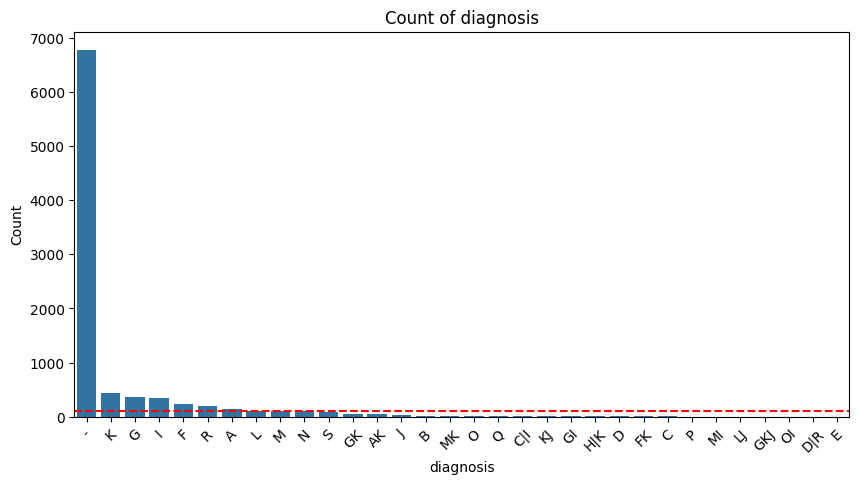

In [19]:
# Function to visualize categorical columns
def visualize_categorical(df, column):
    plt.figure(figsize=(10, 5))
    order = df[column].value_counts().index  
    sns.countplot(x=df[column], order=order)
    plt.axhline(100, color='red', linestyle='--')  # Add a dotted red line at count of 100
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

# Visualize the 'diagnosis' column
visualize_categorical(df, 'diagnosis')

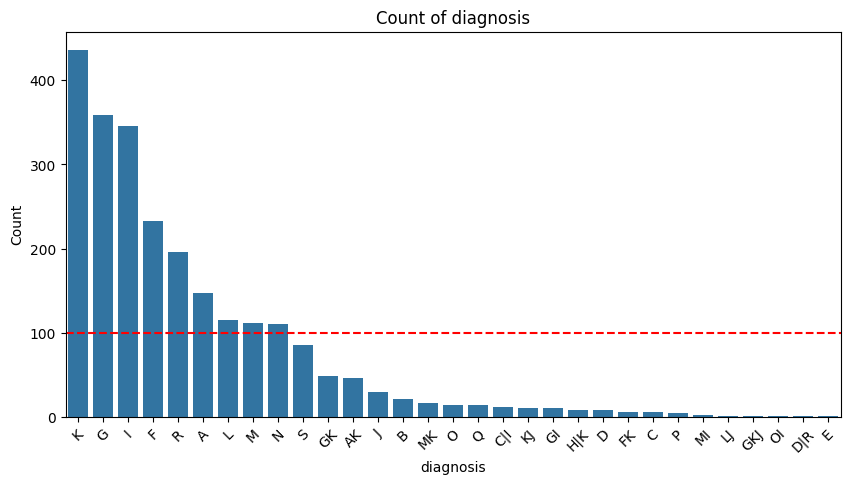

In [20]:
df_normal_filtered_out = df[df['diagnosis'] != '-']
visualize_categorical(df_normal_filtered_out, 'diagnosis')

In [21]:
diagnosis_mapping_names = {
    '-': ('No condition', 'No condition'),
    'A': ('hyperthyroid', 'hyperthyroid conditions'),
    'B': ('T3 toxic', 'hyperthyroid conditions'),
    'C': ('toxic goitre', 'hyperthyroid conditions'),
    'D': ('secondary toxic', 'hyperthyroid conditions'),
    'E': ('hypothyroid', 'hypothyroid conditions'),
    'F': ('primary hypothyroid', 'hypothyroid conditions'),
    'G': ('compensated hypothyroid', 'hypothyroid conditions'),
    'H': ('secondary hypothyroid', 'hypothyroid conditions'),
    'I': ('increased binding protein', 'binding protein'),
    'J': ('decreased binding protein', 'binding protein'),
    'K': ('concurrent non-thyroidal illness', 'general health'),
    'L': ('consistent with replacement therapy', 'replacement therapy'),
    'M': ('underreplaced', 'replacement therapy'),
    'N': ('overreplaced', 'replacement therapy'),
    'O': ('antithyroid drugs', 'antithyroid treatment'),
    'P': ('I131 treatment', 'antithyroid treatment'),
    'Q': ('surgery', 'antithyroid treatment'),
    'R': ('discordant assay results', 'miscellaneous'),
    'S': ('elevated TBG', 'miscellaneous'),
    'T': ('elevated thyroid hormones', 'miscellaneous')
}

In [22]:
diagnosis_counts = df['diagnosis'].value_counts()

counts_df = diagnosis_counts.reset_index()
counts_df.columns = ['diagnosis', 'count']

# Filter counts greater than 100
filtered_counts_df = counts_df[counts_df['count'] > 100].copy()

filtered_counts_df.loc[:, 'full_name'] = filtered_counts_df['diagnosis'].map(lambda x: diagnosis_mapping_names.get(x, ('Unknown', 'Unknown'))[0])
filtered_counts_df.loc[:, 'category'] = filtered_counts_df['diagnosis'].map(lambda x: diagnosis_mapping_names.get(x, ('Unknown', 'Unknown'))[1])

filtered_counts_df = filtered_counts_df[['diagnosis', 'full_name', 'category', 'count']]

filtered_counts_df

diagnosis                            full_name                 category  \
0         -                         No condition             No condition   
1         K     concurrent non-thyroidal illness           general health   
2         G              compensated hypothyroid   hypothyroid conditions   
3         I            increased binding protein          binding protein   
4         F                  primary hypothyroid   hypothyroid conditions   
5         R             discordant assay results            miscellaneous   
6         A                         hyperthyroid  hyperthyroid conditions   
7         L  consistent with replacement therapy      replacement therapy   
8         M                        underreplaced      replacement therapy   
9         N                         overreplaced      replacement therapy   

   count  
0   6771  
1    436  
2    359  
3    346  
4    233  
5    196  
6    147  
7    115  
8    111  
9    110

In [23]:
target_diagnoses = filtered_counts_df['diagnosis'].tolist()

# Create reduced_target_df by filtering df based on target_diagnoses
reduced_target_df = df[df['diagnosis'].isin(target_diagnoses)].copy()

reduced_target_df.head()

age sex  on_thyroxine  query_on_thyroxine  on_antithyroid_medication  \
0   29   F         False               False                      False   
1   29   F         False               False                      False   
2   41   F         False               False                      False   
3   36   F         False               False                      False   
5   60   F         False               False                      False   

    sick  pregnant  thyroid_surgery  I131_treatment  query_hypothyroid  ...  \
0  False     False            False           False               True  ...   
1  False     False            False           False              False  ...   
2  False     False            False           False              False  ...   
3  False     False            False           False              False  ...   
5  False     False            False           False              False  ...   

     TT4  T4U_measured  T4U  FTI_measured  FTI  TBG_measured   TBG  \
0    NaN         False  NaN         False  NaN         False   NaN   
1  128.0         False  NaN         False  NaN         False   NaN   
2    NaN         False  NaN         False  NaN          True  11.0   
3    NaN         False  NaN         False  NaN          True  26.0   
5    NaN         False  NaN         False  NaN          True  26.0   

   referral_source  diagnosis  record_id  
0            other          -  840801013  
1            other          -  840801014  
2            other          -  840801042  
3            other          -  840803046  
5            other          -  840803048  

[5 rows x 31 columns]

In [24]:
reduced_target_df.drop(columns=['referral_source', 'record_id'], inplace=True)

In [25]:
reduced_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8824 entries, 0 to 9171
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        8824 non-null   int64  
 1   sex                        8536 non-null   object 
 2   on_thyroxine               8824 non-null   bool   
 3   query_on_thyroxine         8824 non-null   bool   
 4   on_antithyroid_medication  8824 non-null   bool   
 5   sick                       8824 non-null   bool   
 6   pregnant                   8824 non-null   bool   
 7   thyroid_surgery            8824 non-null   bool   
 8   I131_treatment             8824 non-null   bool   
 9   query_hypothyroid          8824 non-null   bool   
 10  query_hyperthyroid         8824 non-null   bool   
 11  lithium                    8824 non-null   bool   
 12  goitre                     8824 non-null   bool   
 13  tumor                      8824 non-null   bool   
 1

In [26]:
reduced_target_df.isnull().sum()

age                             0
sex                           288
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
TSH                           749
T3_measured                     0
T3                           2507
TT4_measured                    0
TT4                           357
T4U_measured                    0
T4U                           718
FTI_measured                    0
FTI                           711
TBG_measured                    0
TBG                          8562
diagnosis                       0
dtype: int64

In [27]:
reduced_target_df.describe()

age          TSH           T3          TT4          T4U  \
count   8824.000000  8075.000000  6317.000000  8467.000000  8106.000000   
mean      74.480621     5.030415     1.977029   108.860950     0.978403   
std     1207.084603    24.224172     0.864986    36.894359     0.196131   
min        1.000000     0.005000     0.050000     2.000000     0.190000   
25%       37.000000     0.480000     1.500000    88.000000     0.860000   
50%       55.000000     1.400000     1.900000   104.000000     0.960000   
75%       68.000000     2.700000     2.300000   125.000000     1.070000   
max    65526.000000   530.000000    18.000000   600.000000     2.330000   

               FTI         TBG  
count  8113.000000  262.000000  
mean    113.319615   23.158969  
std      39.995915    7.256196  
min       1.400000    0.100000  
25%      94.000000   20.000000  
50%     109.000000   23.000000  
75%     128.000000   27.000000  
max     881.000000   86.000000

## Visualisations

In [28]:
def visualize_numeric(df, column):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histogram
    sns.histplot(df[column].dropna(), bins=30, kde=True, ax=ax[0])
    ax[0].set_title(f'{column} Distribution')
    ax[0].set_xlabel(column)
    ax[0].set_ylabel('Count')
    
    # Scatter plot
    sns.stripplot(x=df[column].dropna(), ax=ax[1])
    ax[1].set_title(f'{column} Scatter Plot')
    ax[1].set_xlabel(column)
    
    plt.tight_layout()
    plt.show()

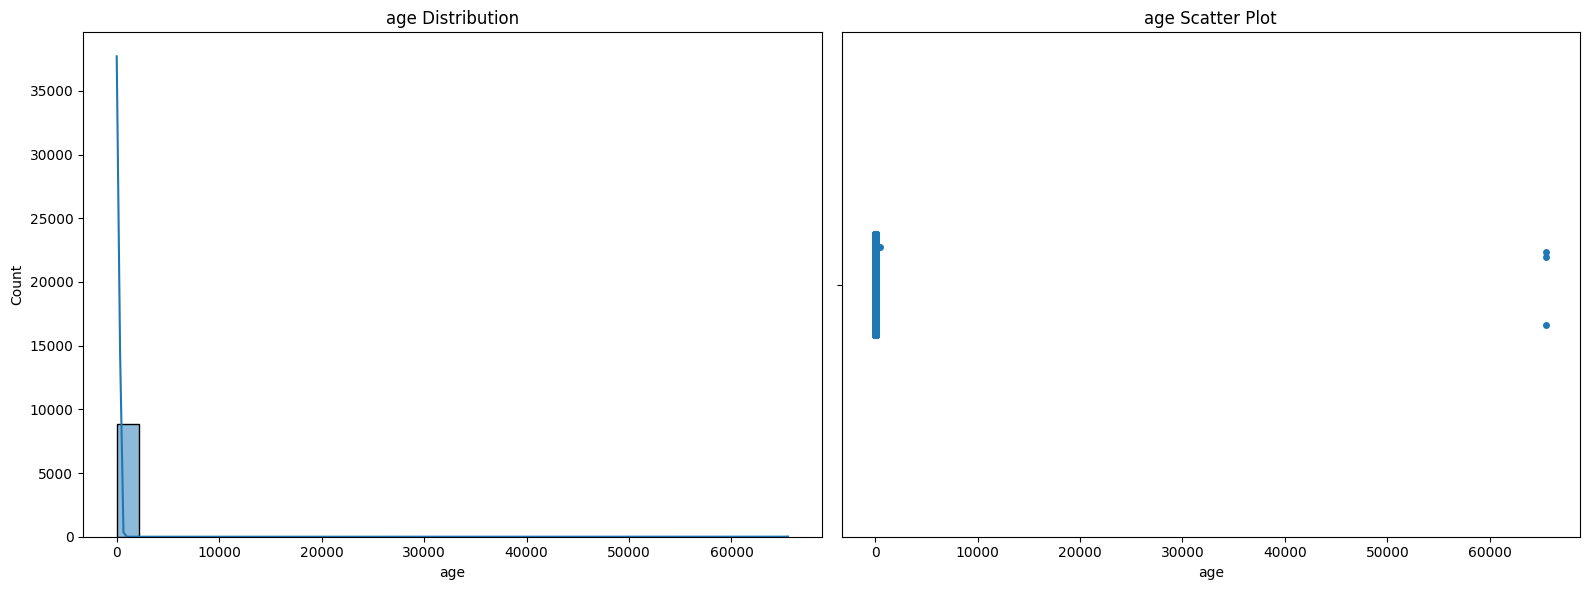

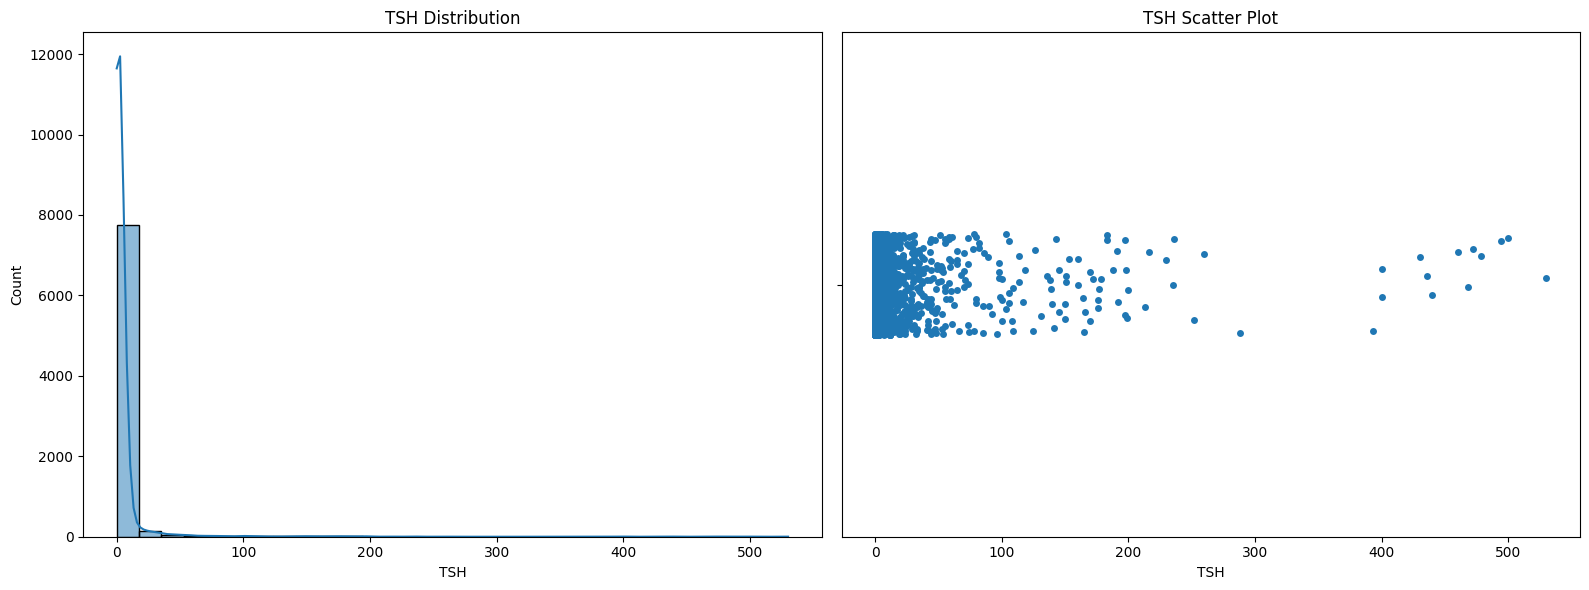

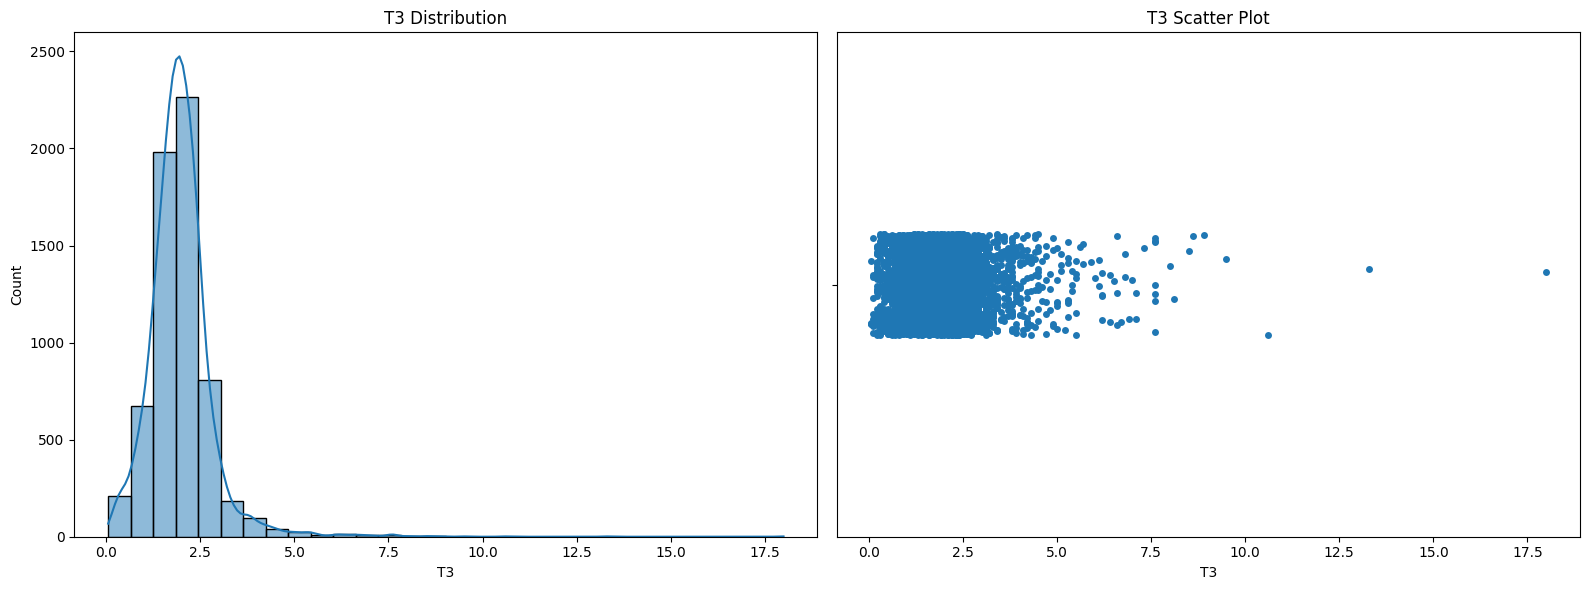

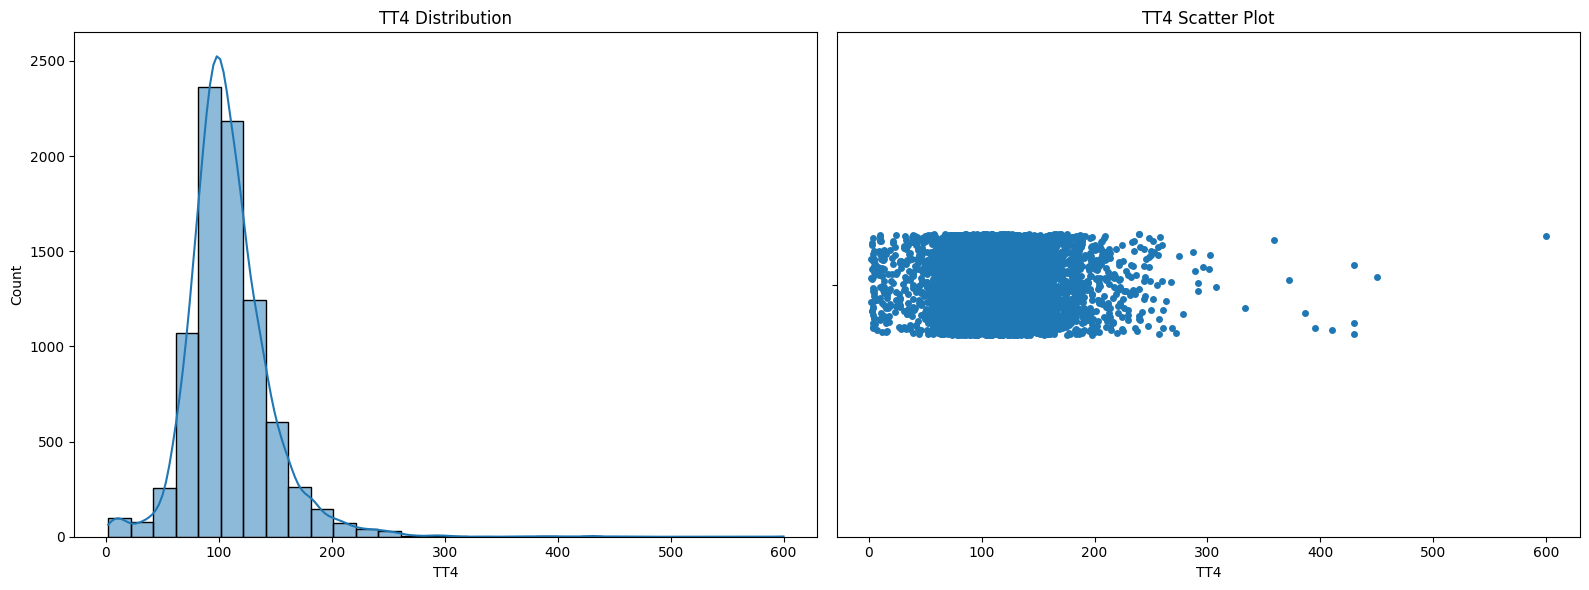

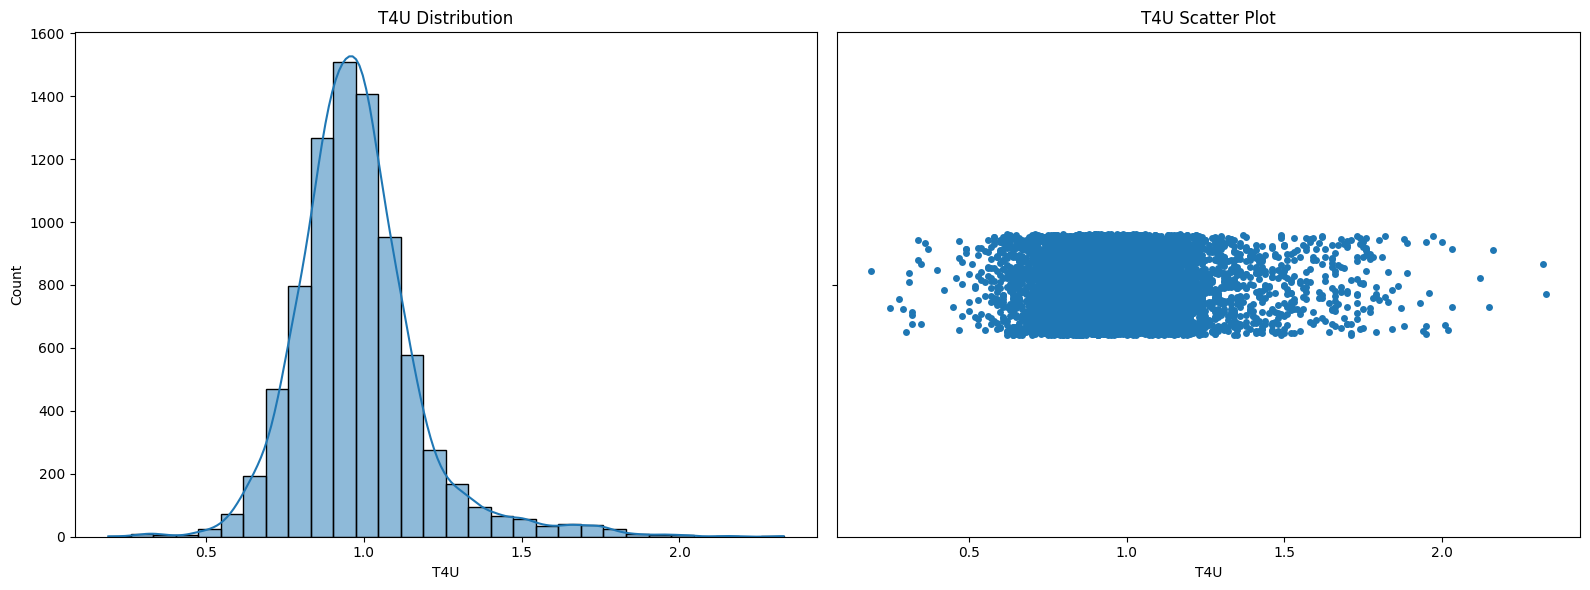

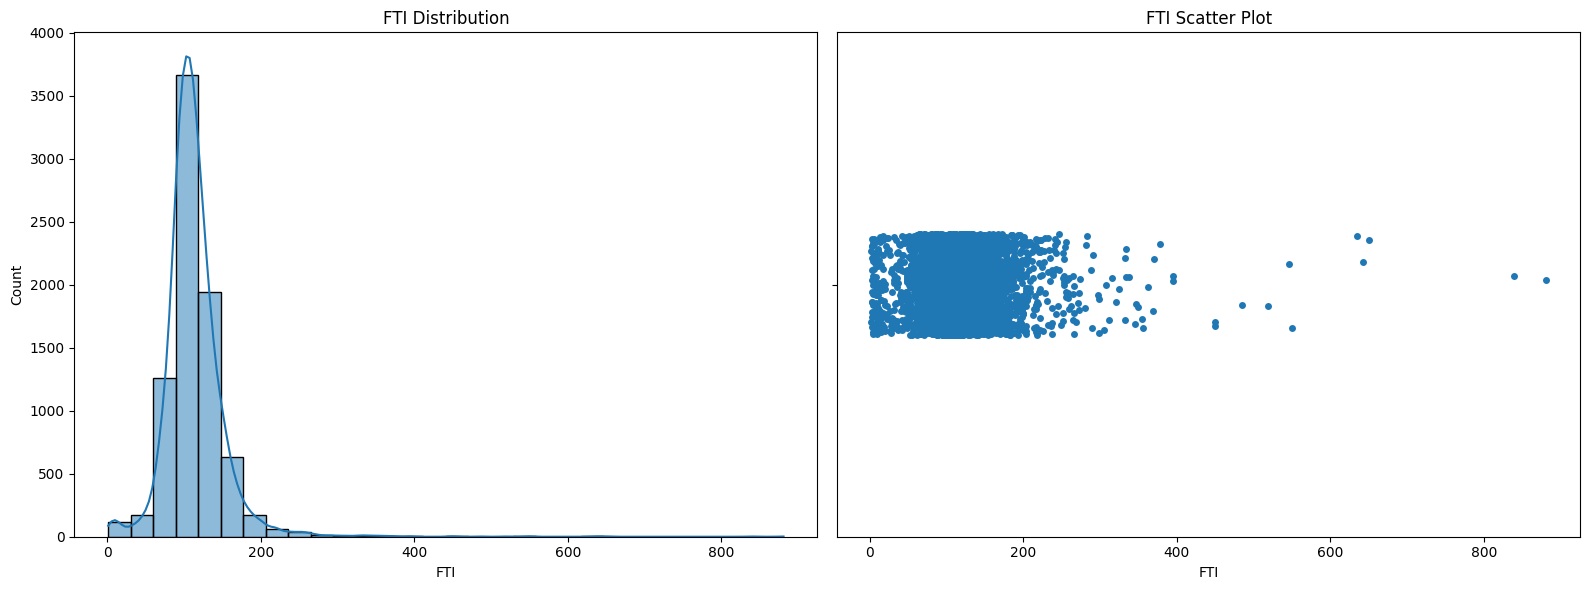

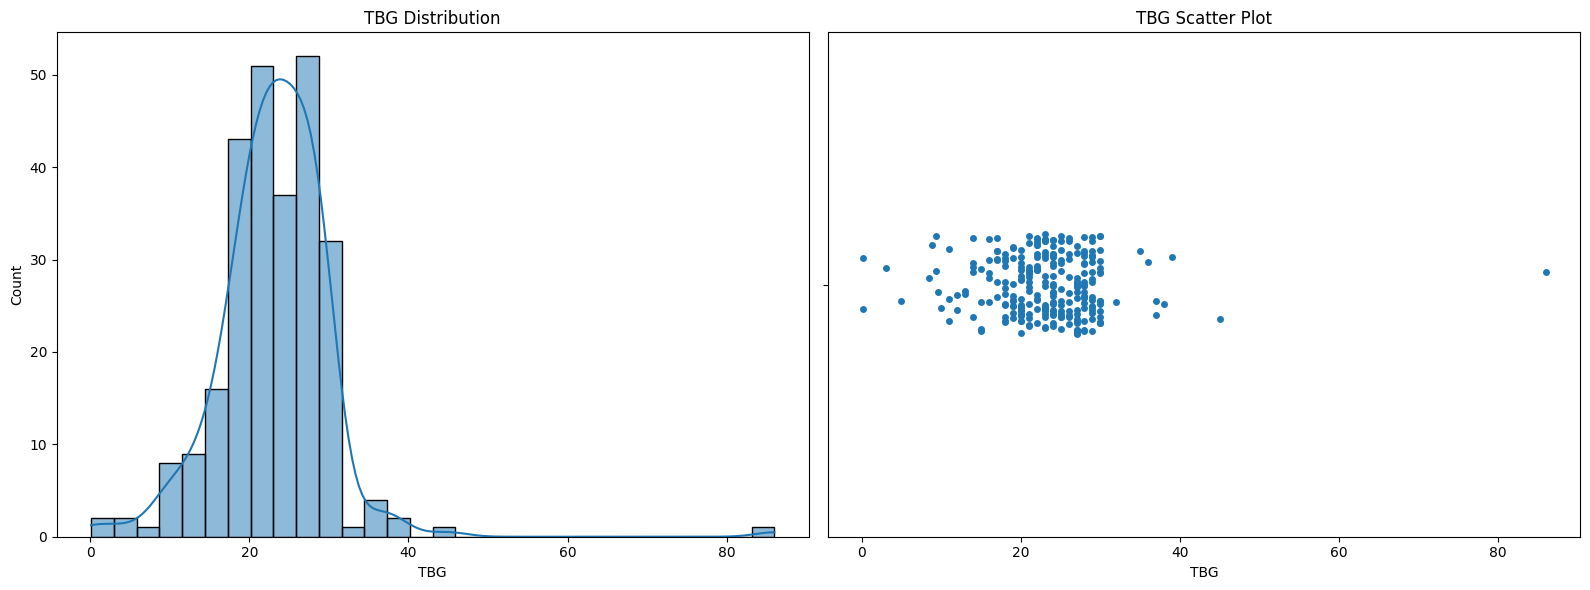

In [29]:
# Convert columns with continuous values to float type
numeric_columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']

for column in numeric_columns:
            visualize_numeric(reduced_target_df, column)

Descriptions of the units used

| Hormone | Unit       | Description                               |
|---------|------------|-------------------------------------------|
| **TSH** | µIU/mL     | micro-international units per milliliter  |
| **T3**  | ng/dL      | nanograms per deciliter                   |
| **TT4** | µg/dL      | micrograms per deciliter                  |
| **T4U** | Unitless   | ratio or percentage                       |
| **FTI** | Unitless   | index or ratio                            |
| **TBG** | µg/mL      | micrograms per milliliter                 |

T3:
- Normal is 0.9 to 2.8 nanomoles per liter (nmol/L)
- https://www.mountsinai.org/health-library/tests/t3-test#:~:text=Normal%20Results&text=Total%20T3%20%2D%2D%2060%20to,per%20liter%20(pmol%2FL)

TT4:
- In newborns up to age 14 days: 11.8-22.6 mcg/dL (152-292 nmol/L)
- 
In babies and older children: 6.4-13.3 mcg/dL (83-172 nmol/
- 

In adults: 5.4-11.5 mcg/dL (57-148 nmo
- https://emedicine.medscape.com/article/2089576-overview?form=fpfl/L)

FTI:
- https://endocrinology.testcatalog.org/show/FRTUP

TBG:

- Normal is 1.1 - 2.1 mg/dL (or 11 - 21 µg/mL)
- Can be 1.5x during infancy
- Can be 2.5x during pregnancy
- [Source](https://www.ncbi.nlm.nih.gov/books/NBK285566/#tyd-serum-trnsprt-2.THYROXINEBI_DING_GLO)
LO)


In [30]:
reduced_target_df[reduced_target_df['age'] > 100]

age sex  on_thyroxine  query_on_thyroxine  on_antithyroid_medication  \
2976    455   F         False               False                      False   
5710  65511   M         False               False                      False   
6392  65512   M         False               False                      False   
8105  65526   F         False               False                      False   

       sick  pregnant  thyroid_surgery  I131_treatment  query_hypothyroid  \
2976  False     False            False           False              False   
5710  False     False            False           False              False   
6392  False     False            False           False              False   
8105  False     False            False           False              False   

      ...   T3  TT4_measured    TT4  T4U_measured   T4U  FTI_measured    FTI  \
2976  ...  2.0          True  118.0          True  1.13          True  104.0   
5710  ...  2.0          True  113.0          True  1.08          True  104.0   
6392  ...  2.8          True  112.0          True  0.84          True  133.0   
8105  ...  NaN          True  132.0          True  1.02          True  129.0   

      TBG_measured  TBG  diagnosis  
2976         False  NaN          -  
5710         False  NaN          -  
6392         False  NaN          -  
8105         False  NaN          -  

[4 rows x 29 columns]

We see that we have age values well above 100 that clearly indicate an error. Because these all have the diagnosis od 'normal' and this is the predominant target in the dataset, we can remove these without much loss of data. 

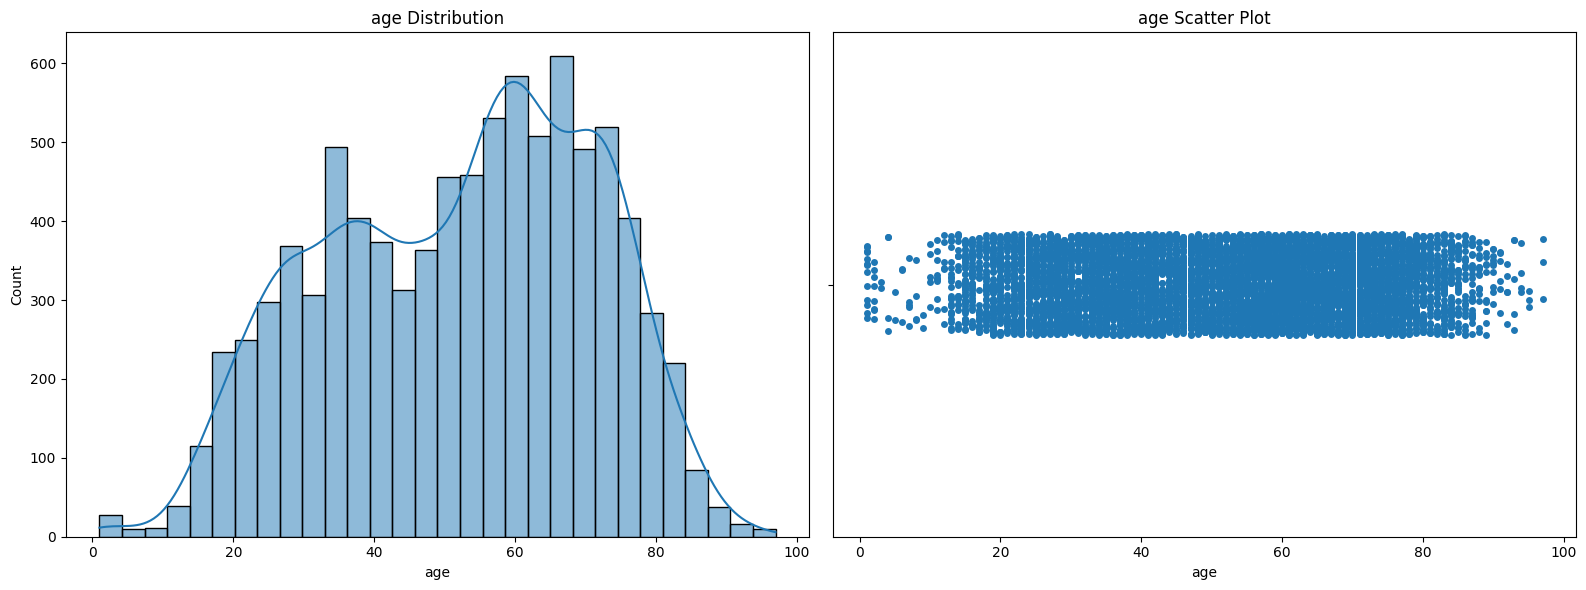

In [31]:
# Remove where age > 100 
reduced_target_df = reduced_target_df[reduced_target_df['age'] <= 100]

visualize_numeric(reduced_target_df, 'age')

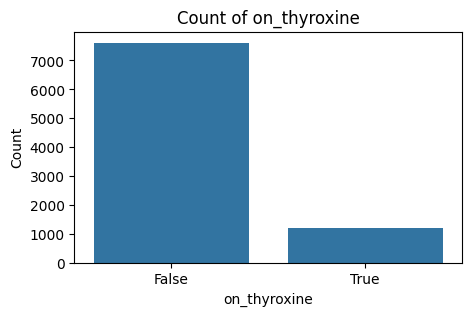

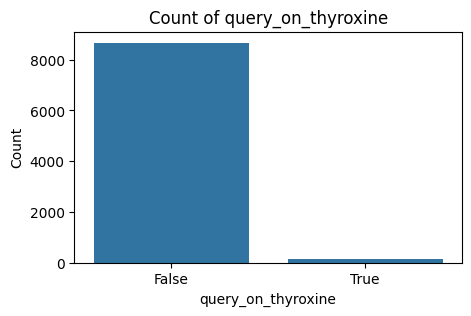

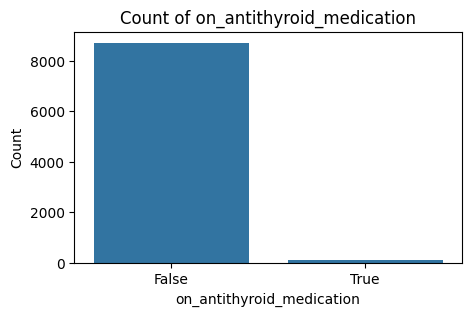

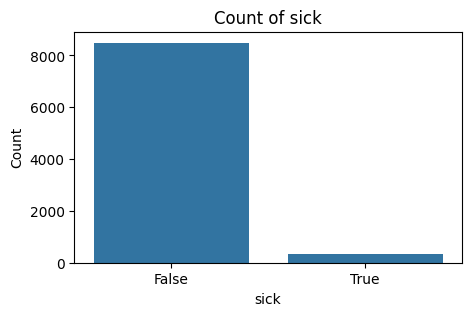

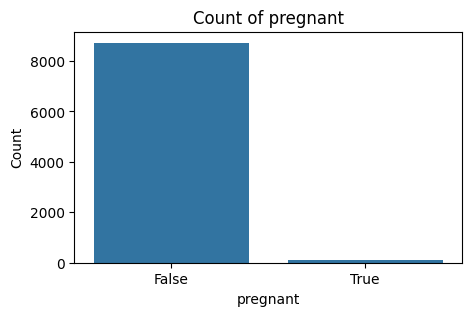

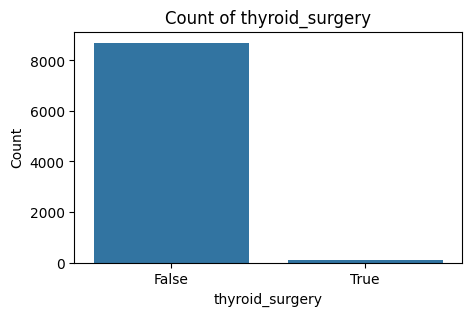

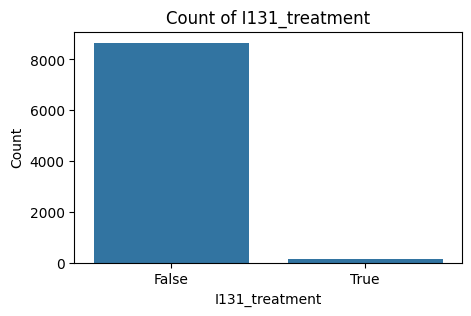

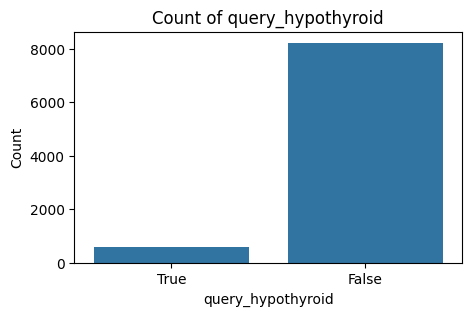

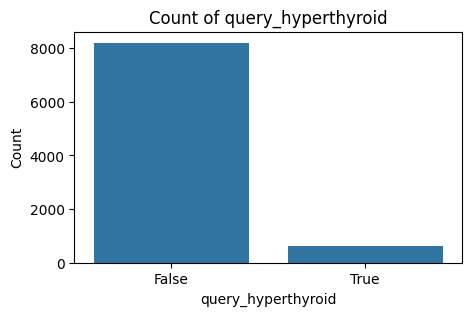

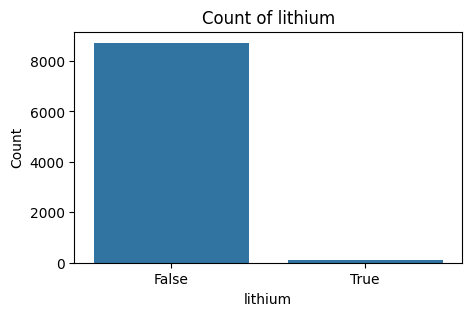

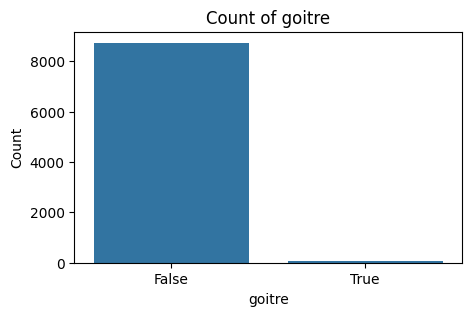

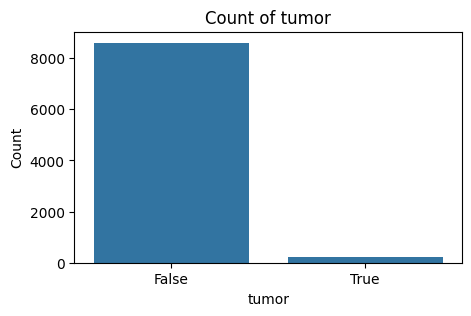

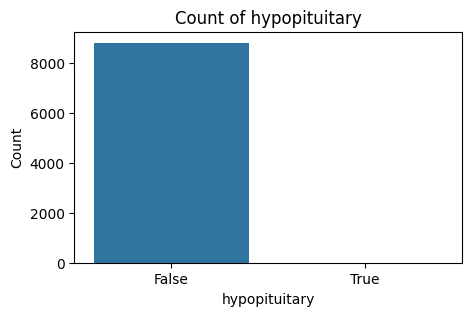

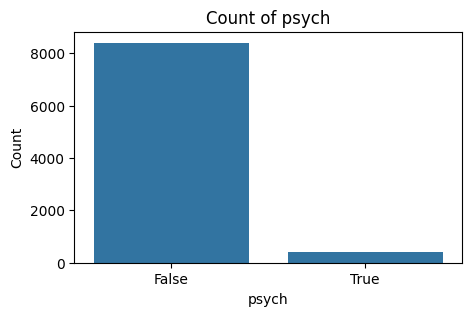

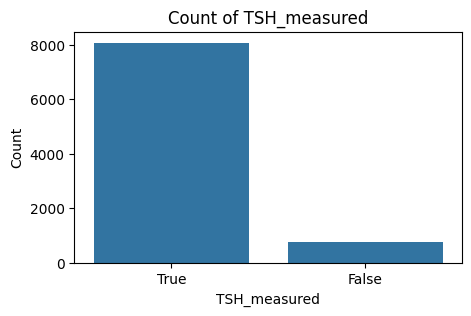

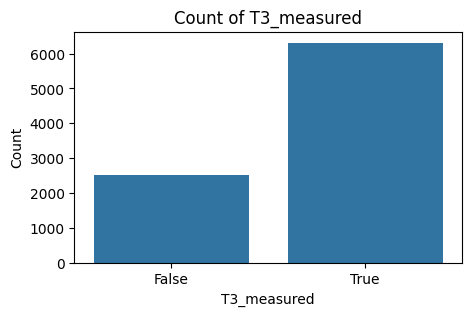

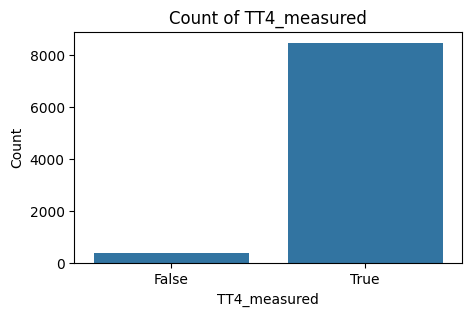

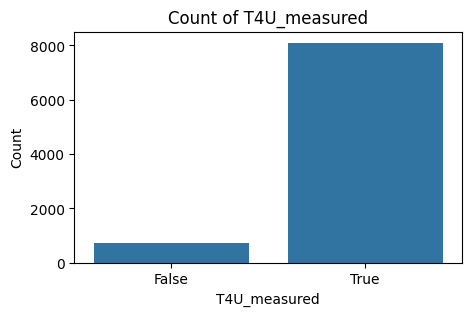

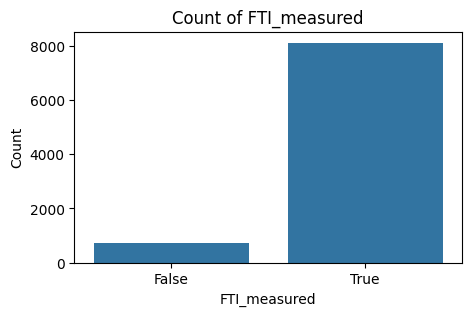

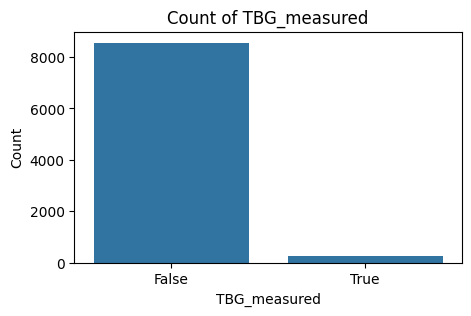

In [32]:
def visualize_boolean(df, column):
    plt.figure(figsize=(5, 3))
    sns.countplot(x=df[column].astype(str))
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()

# List of boolean columns
boolean_columns = [
    'on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication',
    'sick', 'pregnant', 'thyroid_surgery', 'I131_treatment',
    'query_hypothyroid', 'query_hyperthyroid', 'lithium', 'goitre',
    'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'T3_measured',
    'TT4_measured', 'T4U_measured', 'FTI_measured', 'TBG_measured'
]

for column in boolean_columns:
    visualize_boolean(reduced_target_df, column)

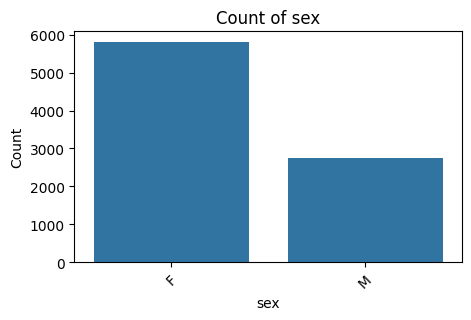

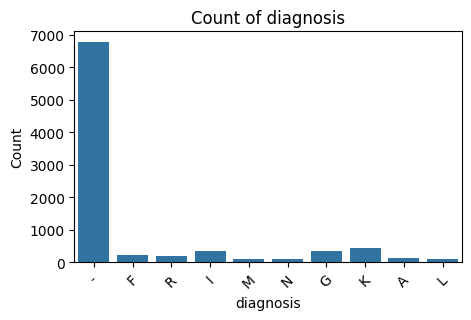

In [33]:
def visualize_categorical(df, column):
    plt.figure(figsize=(5, 3))
    sns.countplot(x=df[column])
    plt.title(f'Count of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    
    
categorical_columns = ['sex', 'diagnosis']

for column in categorical_columns:
    visualize_categorical(reduced_target_df, column)

In [34]:
# Convert boolean columns to 0 and 1
reduced_target_df[boolean_columns] = reduced_target_df[boolean_columns].astype(int)

reduced_target_df.head()

age sex  on_thyroxine  query_on_thyroxine  on_antithyroid_medication  sick  \
0   29   F             0                   0                          0     0   
1   29   F             0                   0                          0     0   
2   41   F             0                   0                          0     0   
3   36   F             0                   0                          0     0   
5   60   F             0                   0                          0     0   

   pregnant  thyroid_surgery  I131_treatment  query_hypothyroid  ...   T3  \
0         0                0               0                  1  ...  NaN   
1         0                0               0                  0  ...  1.9   
2         0                0               0                  0  ...  NaN   
3         0                0               0                  0  ...  NaN   
5         0                0               0                  0  ...  NaN   

   TT4_measured    TT4  T4U_measured  T4U  FTI_measured  FTI  TBG_measured  \
0             0    NaN             0  NaN             0  NaN             0   
1             1  128.0             0  NaN             0  NaN             0   
2             0    NaN             0  NaN             0  NaN             1   
3             0    NaN             0  NaN             0  NaN             1   
5             0    NaN             0  NaN             0  NaN             1   

    TBG  diagnosis  
0   NaN          -  
1   NaN          -  
2  11.0          -  
3  26.0          -  
5  26.0          -  

[5 rows x 29 columns]

In [35]:
# Mapping for the 'sex' column
sex_mapping = {
    'F': 0, 
    'M': 1,
    
}
reduced_target_df['sex'] = reduced_target_df['sex'].map(sex_mapping)

# Create the 'sex_measured' indicator column
reduced_target_df['sex_measured'] = reduced_target_df['sex'].notna().astype(int)

# Insert 'sex_measured' next to 'sex'
reduced_target_df.insert(2, 'sex_measured', reduced_target_df.pop('sex_measured'))

# Mapping for the 'diagnosis' column
diagnosis_mapping = {
    '-': 0,
    'K': 1,
    'G': 2,
    'I': 3,
    'F': 4,
    'R': 5,
    'A': 6,
    'L': 7,
    'M': 8,
    'N': 9
}
reduced_target_df['diagnosis'] = reduced_target_df['diagnosis'].map(diagnosis_mapping)

In [36]:
reduced_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8820 entries, 0 to 9171
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        8820 non-null   int64  
 1   sex                        8532 non-null   float64
 2   sex_measured               8820 non-null   int64  
 3   on_thyroxine               8820 non-null   int64  
 4   query_on_thyroxine         8820 non-null   int64  
 5   on_antithyroid_medication  8820 non-null   int64  
 6   sick                       8820 non-null   int64  
 7   pregnant                   8820 non-null   int64  
 8   thyroid_surgery            8820 non-null   int64  
 9   I131_treatment             8820 non-null   int64  
 10  query_hypothyroid          8820 non-null   int64  
 11  query_hyperthyroid         8820 non-null   int64  
 12  lithium                    8820 non-null   int64  
 13  goitre                     8820 non-null   int64  
 1

In [37]:
# Count the values in the 'diagnosis' column
diagnosis_counts = reduced_target_df['diagnosis'].value_counts()

diagnosis_percentages = (diagnosis_counts / len(reduced_target_df)) * 100
diagnosis_percentages = diagnosis_percentages.map("{:.2f}".format)

diagnosis_summary = pd.DataFrame({
    'Count': diagnosis_counts,
    'Percentage (%)': diagnosis_percentages
})

diagnosis_summary

Count Percentage (%)
diagnosis                      
0           6767          76.72
1            436           4.94
2            359           4.07
3            346           3.92
4            233           2.64
5            196           2.22
6            147           1.67
7            115           1.30
8            111           1.26
9            110           1.25

Text(0.5, 1.0, 'Correlation in Dataset')

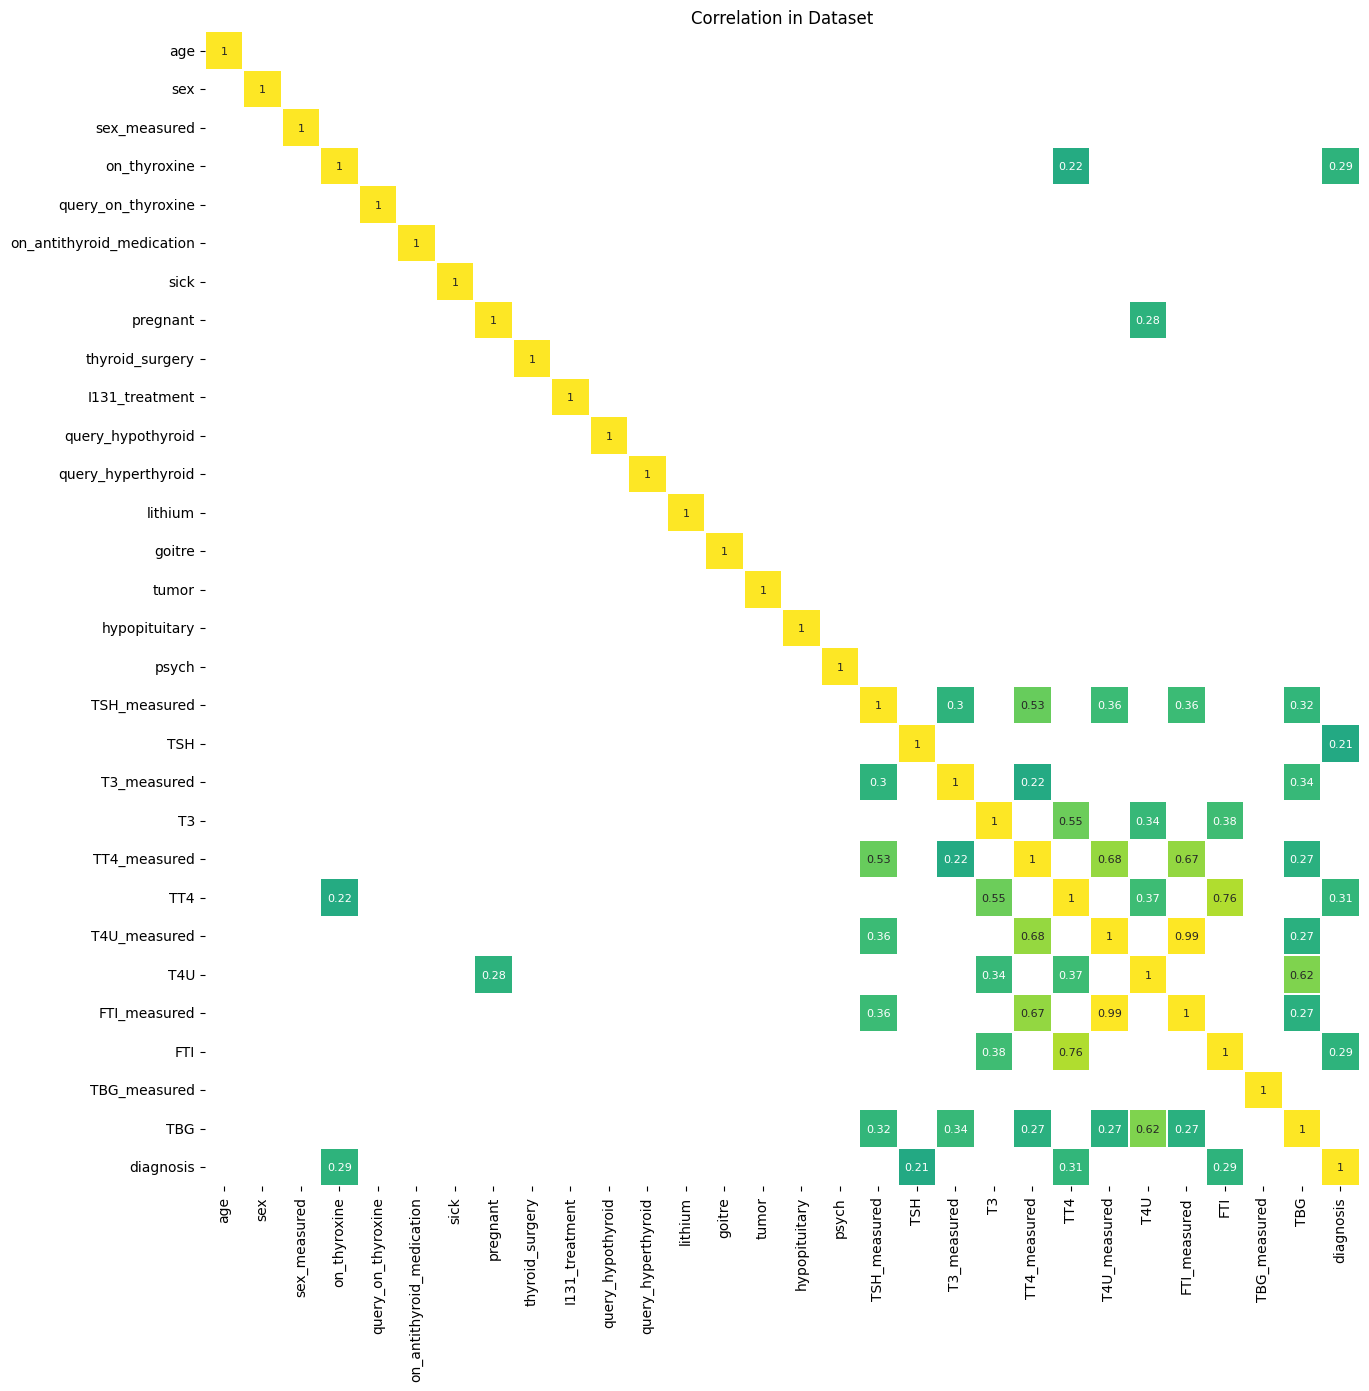

In [38]:
correlation_matrix = reduced_target_df.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix[(correlation_matrix >= 0.2)], cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True, cbar=False);
plt.title('Correlation in Dataset')

## Bucket encoding

In [39]:
# Drop rows with NaN values
tsh_values = reduced_target_df['TSH'].dropna()
t3_values = reduced_target_df['T3'].dropna()
fti_values = reduced_target_df['FTI'].dropna()

# Apply a logarithmic transformation
log_tsh_values = np.log1p(tsh_values)  # log1p is used to handle log(0) by computing log(1 + x)
log_t3_values = np.log1p(t3_values)
log_fti_values = np.log1p(fti_values)

# Define bin edges in the log-transformed space
tsh_log_bin_edges = np.linspace(log_tsh_values.min(), log_tsh_values.max(), 20 + 1) # last parameter is number of bins
t3_log_bin_edges = np.linspace(log_t3_values.min(), log_t3_values.max(), 9 + 1)
fti_log_bin_edges = np.linspace(log_fti_values.min(), log_fti_values.max(), 17 + 1)

# Transform bin edges back to the original space
tsh_bins = np.expm1(tsh_log_bin_edges)  # expm1 is used to reverse log1p
t3_bins = np.expm1(t3_log_bin_edges)
fti_bins = np.expm1(fti_log_bin_edges)

In [40]:
# Define binning ranges
age_bins = range(0, int(reduced_target_df['age'].max() + 5), 5)
t4u_bins = [i * 0.2 for i in range(int(reduced_target_df['T4U'].min() // 0.2), int(reduced_target_df['T4U'].max() // 0.2) + 2)]
tbg_bins = [0, 15, 25, 35, int(reduced_target_df['TBG'].max() + 2)]
tt4_bins = [0, 30, 60, 90, 120, 150, 190, 210, 240, 270, 300, int(reduced_target_df['TT4'].max() + 2)]

# Create a new DataFrame for discretized values and copy other columns
discrete_df = reduced_target_df.copy()

# Discretize the columns and add to the new DataFrame
discrete_df['age_discrete'] = pd.cut(reduced_target_df['age'], bins=age_bins, right=False, labels=False)
discrete_df['TSH_discrete'] = pd.cut(reduced_target_df['TSH'], bins=tsh_bins, right=False, labels=False)
discrete_df['T3_discrete'] = pd.cut(reduced_target_df['T3'], bins=t3_bins, right=False, labels=False)
discrete_df['TT4_discrete'] = pd.cut(reduced_target_df['TT4'], bins=tt4_bins, right=False, labels=False)
discrete_df['T4U_discrete'] = pd.cut(reduced_target_df['T4U'], bins=t4u_bins, right=False, labels=False)
discrete_df['FTI_discrete'] = pd.cut(reduced_target_df['FTI'], bins=fti_bins, right=False, labels=False)
discrete_df['TBG_discrete'] = pd.cut(reduced_target_df['TBG'], bins=tbg_bins, right=False, labels=False)

# Drop the original continuous columns
discrete_df.drop(columns=['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG'], inplace=True)

discrete_df.tail()

sex  sex_measured  on_thyroxine  query_on_thyroxine  \
9167  1.0             1             0                   0   
9168  1.0             1             0                   0   
9169  1.0             1             0                   0   
9170  0.0             1             0                   0   
9171  1.0             1             0                   0   

      on_antithyroid_medication  sick  pregnant  thyroid_surgery  \
9167                          0     0         0                0   
9168                          0     0         0                0   
9169                          0     0         0                0   
9170                          0     0         0                0   
9171                          0     0         0                0   

      I131_treatment  query_hypothyroid  ...  FTI_measured  TBG_measured  \
9167               0                  0  ...             1             0   
9168               0                  0  ...             1             0   
9169               0                  0  ...             1             0   
9170               0                  0  ...             1             0   
9171               0                  1  ...             1             0   

      diagnosis  age_discrete  TSH_discrete  T3_discrete  TT4_discrete  \
9167          0            11           NaN          NaN           2.0   
9168          0             4           NaN          NaN           3.0   
9169          3            13           NaN          NaN           3.0   
9170          0             9           NaN          NaN           2.0   
9171          0             6           NaN          NaN           2.0   

      T4U_discrete  FTI_discrete  TBG_discrete  
9167           4.0          10.0           NaN  
9168           4.0          10.0           NaN  
9169           6.0          10.0           NaN  
9170           4.0          10.0           NaN  
9171           5.0           9.0           NaN  

[5 rows x 30 columns]

In [41]:
exp_df = discrete_df.copy()

exp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8820 entries, 0 to 9171
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sex                        8532 non-null   float64
 1   sex_measured               8820 non-null   int64  
 2   on_thyroxine               8820 non-null   int64  
 3   query_on_thyroxine         8820 non-null   int64  
 4   on_antithyroid_medication  8820 non-null   int64  
 5   sick                       8820 non-null   int64  
 6   pregnant                   8820 non-null   int64  
 7   thyroid_surgery            8820 non-null   int64  
 8   I131_treatment             8820 non-null   int64  
 9   query_hypothyroid          8820 non-null   int64  
 10  query_hyperthyroid         8820 non-null   int64  
 11  lithium                    8820 non-null   int64  
 12  goitre                     8820 non-null   int64  
 13  tumor                      8820 non-null   int64  
 1

In [42]:
exp_df.isnull().sum()

sex                           288
sex_measured                    0
on_thyroxine                    0
query_on_thyroxine              0
on_antithyroid_medication       0
sick                            0
pregnant                        0
thyroid_surgery                 0
I131_treatment                  0
query_hypothyroid               0
query_hyperthyroid              0
lithium                         0
goitre                          0
tumor                           0
hypopituitary                   0
psych                           0
TSH_measured                    0
T3_measured                     0
TT4_measured                    0
T4U_measured                    0
FTI_measured                    0
TBG_measured                    0
diagnosis                       0
age_discrete                    0
TSH_discrete                  810
T3_discrete                  2511
TT4_discrete                  357
T4U_discrete                  718
FTI_discrete                  711
TBG_discrete  

In [43]:
# Calculate the percentage of missing data in each column
missing_percentages = (exp_df.isnull().sum() / len(exp_df)) * 100
missing_percentages = missing_percentages.map("{:.2f}".format)

missing_percentages

sex                           3.27
sex_measured                  0.00
on_thyroxine                  0.00
query_on_thyroxine            0.00
on_antithyroid_medication     0.00
sick                          0.00
pregnant                      0.00
thyroid_surgery               0.00
I131_treatment                0.00
query_hypothyroid             0.00
query_hyperthyroid            0.00
lithium                       0.00
goitre                        0.00
tumor                         0.00
hypopituitary                 0.00
psych                         0.00
TSH_measured                  0.00
T3_measured                   0.00
TT4_measured                  0.00
T4U_measured                  0.00
FTI_measured                  0.00
TBG_measured                  0.00
diagnosis                     0.00
age_discrete                  0.00
TSH_discrete                  9.18
T3_discrete                  28.47
TT4_discrete                  4.05
T4U_discrete                  8.14
FTI_discrete        

In [44]:
# 97% of the TBG cloumn is missing. Better to drop it completely
exp_df.drop(columns=['TBG_discrete'], inplace=True)
exp_df.drop(columns=['TBG_measured'], inplace=True)

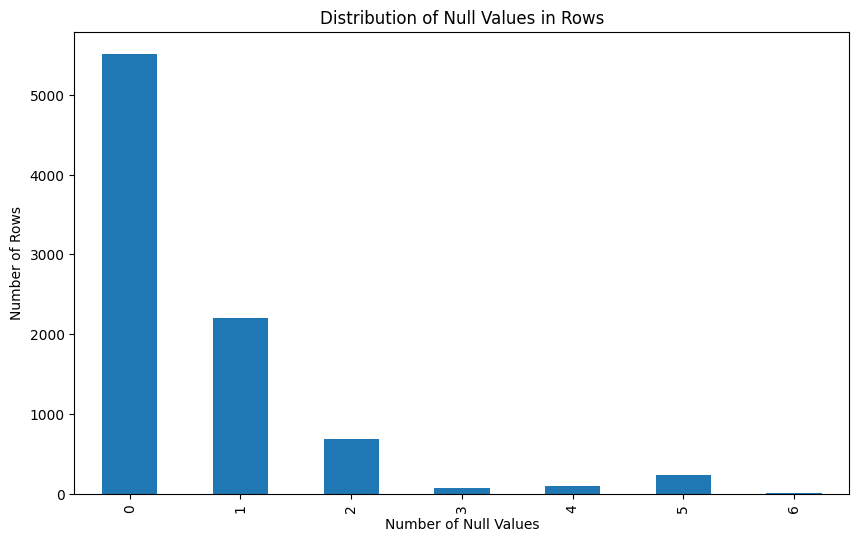

In [45]:
# Count the number of null values in each row
null_counts = exp_df.isnull().sum(axis=1)

# Plot the null value counts in a bar graph
plt.figure(figsize=(10, 6))
null_counts.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Number of Null Values')
plt.ylabel('Number of Rows')
plt.title('Distribution of Null Values in Rows')
plt.show()

In [46]:
def convert_all_to_str(df):
    for col in df.columns:
        # Replace any missing values with -1 for integer conversion
        df[col] = df[col].replace({pd.NA: -1, None: -1, 'nan': -1, np.nan: -1})
        
        df[col] = df[col].astype(int)
        
        df[col] = df[col].astype(str)
    
    return df

exp_df = convert_all_to_str(exp_df)

In [47]:
exp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8820 entries, 0 to 9171
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   sex                        8820 non-null   object
 1   sex_measured               8820 non-null   object
 2   on_thyroxine               8820 non-null   object
 3   query_on_thyroxine         8820 non-null   object
 4   on_antithyroid_medication  8820 non-null   object
 5   sick                       8820 non-null   object
 6   pregnant                   8820 non-null   object
 7   thyroid_surgery            8820 non-null   object
 8   I131_treatment             8820 non-null   object
 9   query_hypothyroid          8820 non-null   object
 10  query_hyperthyroid         8820 non-null   object
 11  lithium                    8820 non-null   object
 12  goitre                     8820 non-null   object
 13  tumor                      8820 non-null   object
 14  hypopituitary

In [48]:
exp_df.tail()

sex sex_measured on_thyroxine query_on_thyroxine  \
9167   1            1            0                  0   
9168   1            1            0                  0   
9169   1            1            0                  0   
9170   0            1            0                  0   
9171   1            1            0                  0   

     on_antithyroid_medication sick pregnant thyroid_surgery I131_treatment  \
9167                         0    0        0               0              0   
9168                         0    0        0               0              0   
9169                         0    0        0               0              0   
9170                         0    0        0               0              0   
9171                         0    0        0               0              0   

     query_hypothyroid  ... TT4_measured T4U_measured FTI_measured diagnosis  \
9167                 0  ...            1            1            1         0   
9168                 0  ...            1            1            1         0   
9169                 0  ...            1            1            1         3   
9170                 0  ...            1            1            1         0   
9171                 1  ...            1            1            1         0   

     age_discrete TSH_discrete T3_discrete TT4_discrete T4U_discrete  \
9167           11           -1          -1            2            4   
9168            4           -1          -1            3            4   
9169           13           -1          -1            3            6   
9170            9           -1          -1            2            4   
9171            6           -1          -1            2            5   

     FTI_discrete  
9167           10  
9168           10  
9169           10  
9170           10  
9171            9  

[5 rows x 28 columns]

# Data Splitting

Final split: Train - 85%, Test - 15%

In [49]:
# The stratify parameter allows us to keep the ratios of thr diagniosis appearances in the sets similar since there is little occurances of them
train_set, test_set = train_test_split(exp_df, test_size=0.15, random_state=42, stratify=exp_df['diagnosis'])

In [50]:
# Separate X and y for the training set
X_train = train_set.drop(columns=['diagnosis'])
y_train = train_set['diagnosis']

# Separate X and y for the testing set
X_test = test_set.drop(columns=['diagnosis'])
y_test = test_set['diagnosis']

In [51]:
# Assess the distribution of our target variable
print("Number of datapints in training set:", len(train_set['diagnosis'].tolist()))
print(train_set['diagnosis'].value_counts())

print("Number of datapints in validation set:", len(test_set['diagnosis'].tolist()))
print(test_set['diagnosis'].value_counts())

Number of datapints in training set: 7497
diagnosis
0    5752
1     371
2     305
3     294
4     198
5     167
6     125
7      98
8      94
9      93
Name: count, dtype: int64
Number of datapints in validation set: 1323
diagnosis
0    1015
1      65
2      54
3      52
4      35
5      29
6      22
7      17
8      17
9      17
Name: count, dtype: int64


# Training

#### State names for columns with mutiple values

In [52]:
# Create the state_names dictionary where values might not appear in the dataset
state_names = {
    'TSH_discrete': [x for x in range(len(tsh_bins) - 1)],
    'T3_discrete': [x for x in range(len(t3_bins) - 1)],
    'TT4_discrete': [x for x in range(len(tt4_bins) - 1)],
    'T4U_discrete': [x for x in range(len(t4u_bins) - 1)],
    'FTI_discrete': [x for x in range(len(fti_bins) - 1)],
    'sex': [0, 1],
}

state_names = {
    key: [str(x) for x in value] + ['-1'] for key, value in state_names.items()
}
state_names['age_discrete'] = [str(x) for x in range(len(age_bins) - 1)]
state_names['hypopituitary'] = ['0', '1']

print("State Names: \n")
for state, data in state_names.items():
    print(f'{state}: {data}')

State Names: 

TSH_discrete: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '-1']
T3_discrete: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '-1']
TT4_discrete: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '-1']
T4U_discrete: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '-1']
FTI_discrete: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '-1']
sex: ['0', '1', '-1']
age_discrete: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
hypopituitary: ['0', '1']


## Baseline Models

### Neural Network

In [53]:
def build_nn_model_with_masking(input_dim, num_classes, mask_value=-2, neurons=64, optimizer='adam', learning_rate=0.001, dropout_rate=0.1, activation='relu'):
    """
    Build a neural network model with a masking layer to ignore a specific value.
    """
    model = models.Sequential()

    model.add(layers.Input(shape=(input_dim,)))
    
    # Add a masking layer that masks the input where the value is `mask_value`
    model.add(layers.Masking(mask_value=mask_value))
    
    # Hidden layers with variable neurons and dropout
    model.add(layers.Dense(neurons, activation=activation))
    model.add(layers.Dropout(dropout_rate))  
    
    model.add(layers.Dense(neurons, activation=activation))
    model.add(layers.Dropout(dropout_rate)) 
    
    # Output layer for classification
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Choose and configure the optimizer
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    # Compile the model with the specified optimizer
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


### Random Bayesian Network Structure

In [54]:
node_names = train_set.columns.tolist()

# Set a seed for reproducibility
np.random.seed(10)

random_structure = BayesianNetwork.get_random(n_nodes = len(node_names), edge_prob = 0.10)
mapping = {i: node_names[i] for i in range(len(node_names))}

random_structure = nx.relabel_nodes(random_structure, mapping)

## Structure Learning - HillClimbSearch

In [55]:
hc = HillClimbSearch(train_set, state_names=state_names)

# Different scoring methods for learning edges
K2Score_structure = hc.estimate(scoring_method= K2Score(train_set), max_indegree=3)
print("K2 score: \n", K2Score(train_set).score(K2Score_structure))
print("K2: \n", K2Score_structure.edges(), "\n")

BDeuScore_structure = hc.estimate(scoring_method= BDeuScore(train_set))
print("BDeu score: \n", BDeuScore(train_set).score(BDeuScore_structure))
print("BDeu: \n", BDeuScore_structure.edges(), "\n")

BicScore_structure = hc.estimate(scoring_method= BicScore(train_set))
print("Bic score: \n", BicScore(train_set).score(BicScore_structure))
print("Bic: \n", BicScore_structure.edges(), "\n")

AicScore_structure = hc.estimate(scoring_method= AICScore(train_set))
print("Aic score: \n", AICScore(train_set).score(AicScore_structure))
print("Aic: \n", AicScore_structure.edges(), "\n")

BDsScore_structure = hc.estimate(scoring_method= BDsScore(train_set) , max_indegree=3)
print("BDs score: \n", BDsScore(train_set).score(BDsScore_structure))
print("BDs: \n", BDsScore_structure.edges(), "\n")

  0%|          | 0/1000000 [00:00<?, ?it/s]

K2 score: 
 128639.83292367488
K2: 
 [('sex', 'T4U_discrete'), ('sex', 'query_hypothyroid'), ('sex', 'tumor'), ('sex_measured', 'sex'), ('sex_measured', 'T4U_discrete'), ('on_thyroxine', 'query_hypothyroid'), ('on_thyroxine', 'sick'), ('on_thyroxine', 'psych'), ('query_on_thyroxine', 'TSH_measured'), ('pregnant', 'T4U_discrete'), ('pregnant', 'age_discrete'), ('pregnant', 'sex'), ('pregnant', 'tumor'), ('I131_treatment', 'age_discrete'), ('I131_treatment', 'query_hypothyroid'), ('query_hyperthyroid', 'on_antithyroid_medication'), ('lithium', 'psych'), ('goitre', 'TSH_measured'), ('hypopituitary', 'query_on_thyroxine'), ('hypopituitary', 'sex'), ('psych', 'sick'), ('psych', 'query_hyperthyroid'), ('TSH_measured', 'TSH_discrete'), ('TSH_measured', 'I131_treatment'), ('TT4_measured', 'query_hyperthyroid'), ('TT4_measured', 'tumor'), ('T4U_measured', 'FTI_measured'), ('T4U_measured', 'query_on_thyroxine'), ('FTI_measured', 'FTI_discrete'), ('FTI_measured', 'TSH_measured'), ('diagnosis', 'T

  0%|          | 0/1000000 [00:00<?, ?it/s]

BDeu score: 
 -94093.60137355237
BDeu: 
 [('sex', 'sex_measured'), ('sex', 'query_hypothyroid'), ('sex', 'tumor'), ('sex', 'psych'), ('sex_measured', 'tumor'), ('on_thyroxine', 'query_hypothyroid'), ('on_thyroxine', 'sex'), ('on_thyroxine', 'I131_treatment'), ('on_thyroxine', 'sick'), ('pregnant', 'age_discrete'), ('pregnant', 'tumor'), ('pregnant', 'hypopituitary'), ('pregnant', 'sex_measured'), ('I131_treatment', 'lithium'), ('query_hypothyroid', 'I131_treatment'), ('query_hyperthyroid', 'on_antithyroid_medication'), ('query_hyperthyroid', 'I131_treatment'), ('query_hyperthyroid', 'query_on_thyroxine'), ('query_hyperthyroid', 'goitre'), ('lithium', 'sex_measured'), ('goitre', 'sex_measured'), ('hypopituitary', 'sex_measured'), ('hypopituitary', 'TT4_measured'), ('hypopituitary', 'query_on_thyroxine'), ('hypopituitary', 'T4U_measured'), ('hypopituitary', 'FTI_measured'), ('hypopituitary', 'thyroid_surgery'), ('hypopituitary', 'TSH_measured'), ('hypopituitary', 'goitre'), ('hypopituita

  0%|          | 0/1000000 [00:00<?, ?it/s]

Bic score: 
 -100674.28137843733
Bic: 
 [('sex', 'sex_measured'), ('sex', 'psych'), ('sex', 'tumor'), ('sex', 'query_hypothyroid'), ('on_thyroxine', 'query_hypothyroid'), ('on_thyroxine', 'I131_treatment'), ('on_thyroxine', 'sick'), ('query_on_thyroxine', 'TSH_measured'), ('pregnant', 'age_discrete'), ('query_hyperthyroid', 'on_antithyroid_medication'), ('query_hyperthyroid', 'I131_treatment'), ('psych', 'lithium'), ('psych', 'thyroid_surgery'), ('TSH_measured', 'TSH_discrete'), ('TSH_measured', 'goitre'), ('T3_measured', 'psych'), ('T4U_measured', 'FTI_measured'), ('FTI_measured', 'FTI_discrete'), ('diagnosis', 'T3_discrete'), ('diagnosis', 'FTI_discrete'), ('diagnosis', 'on_thyroxine'), ('diagnosis', 'T4U_discrete'), ('TSH_discrete', 'diagnosis'), ('T3_discrete', 'T3_measured'), ('T3_discrete', 'query_hyperthyroid'), ('TT4_discrete', 'TT4_measured'), ('T4U_discrete', 'T4U_measured'), ('T4U_discrete', 'sex'), ('T4U_discrete', 'pregnant'), ('FTI_discrete', 'TT4_discrete')] 



  0%|          | 0/1000000 [00:00<?, ?it/s]

Aic score: 
 -96827.3875939339
Aic: 
 [('sex', 'sex_measured'), ('sex', 'query_hypothyroid'), ('sex', 'tumor'), ('sex', 'psych'), ('on_thyroxine', 'sex'), ('on_thyroxine', 'query_hypothyroid'), ('on_thyroxine', 'T3_measured'), ('on_thyroxine', 'sick'), ('on_thyroxine', 'I131_treatment'), ('query_on_thyroxine', 'hypopituitary'), ('pregnant', 'tumor'), ('query_hyperthyroid', 'on_antithyroid_medication'), ('query_hyperthyroid', 'goitre'), ('psych', 'query_hyperthyroid'), ('psych', 'lithium'), ('TSH_measured', 'TSH_discrete'), ('TSH_measured', 'T3_measured'), ('TSH_measured', 'T4U_discrete'), ('TSH_measured', 'goitre'), ('TSH_measured', 'query_hypothyroid'), ('TSH_measured', 'lithium'), ('T3_measured', 'T3_discrete'), ('T3_measured', 'query_hypothyroid'), ('TT4_measured', 'tumor'), ('TT4_measured', 'query_hyperthyroid'), ('T4U_measured', 'query_on_thyroxine'), ('T4U_measured', 'goitre'), ('FTI_measured', 'lithium'), ('diagnosis', 'T3_discrete'), ('diagnosis', 'T4U_discrete'), ('diagnosis',

  0%|          | 0/1000000 [00:00<?, ?it/s]

BDs score: 
 -95344.12555779939
BDs: 
 [('sex', 'sex_measured'), ('sex', 'on_thyroxine'), ('sex', 'query_hypothyroid'), ('sex', 'tumor'), ('on_thyroxine', 'query_hypothyroid'), ('on_thyroxine', 'I131_treatment'), ('on_thyroxine', 'hypopituitary'), ('query_on_thyroxine', 'hypopituitary'), ('pregnant', 'age_discrete'), ('pregnant', 'diagnosis'), ('pregnant', 'goitre'), ('query_hypothyroid', 'I131_treatment'), ('query_hyperthyroid', 'on_antithyroid_medication'), ('query_hyperthyroid', 'I131_treatment'), ('query_hyperthyroid', 'psych'), ('query_hyperthyroid', 'query_on_thyroxine'), ('lithium', 'sex_measured'), ('goitre', 'hypopituitary'), ('hypopituitary', 'thyroid_surgery'), ('psych', 'lithium'), ('TSH_measured', 'T3_measured'), ('TSH_measured', 'query_on_thyroxine'), ('TSH_measured', 'goitre'), ('TSH_measured', 'lithium'), ('T3_measured', 'T3_discrete'), ('T3_measured', 'query_hypothyroid'), ('TT4_measured', 'TSH_discrete'), ('TT4_measured', 'tumor'), ('T4U_measured', 'query_on_thyroxine

In [56]:
def plot_bayesian_network(model, score_method, k=3, highlight_node='diagnosis'):
    # Create a directed graph from the edge graph
    G = nx.DiGraph()
    G.add_edges_from(model.edges())

   # Identify edges interacting with the highlight_node
    connected_edges = [(u, v) for u, v in G.edges() if u == highlight_node or v == highlight_node]

    # Assign colors: 'red' for connected edges and 'black' for others
    edge_colors = ['red' if (u, v) in connected_edges else 'black' for u, v in G.edges()]

    # Assign colors to nodes: 'red' for the highlight_node, 'skyblue' for others
    node_colors = ['red' if node == highlight_node else 'skyblue' for node in G.nodes()]

    # Plot the graph
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G, k=k, iterations=50, seed=40)  
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=12, arrows=True, edge_color=edge_colors)
    plt.title('Bayesian Network Structure: ' + score_method)
    plt.show()

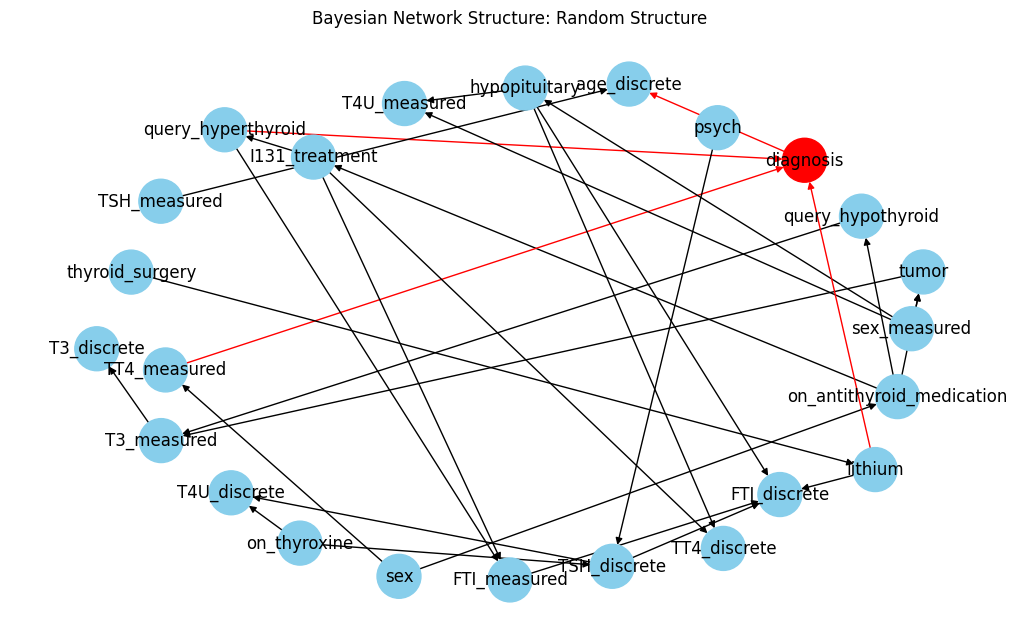

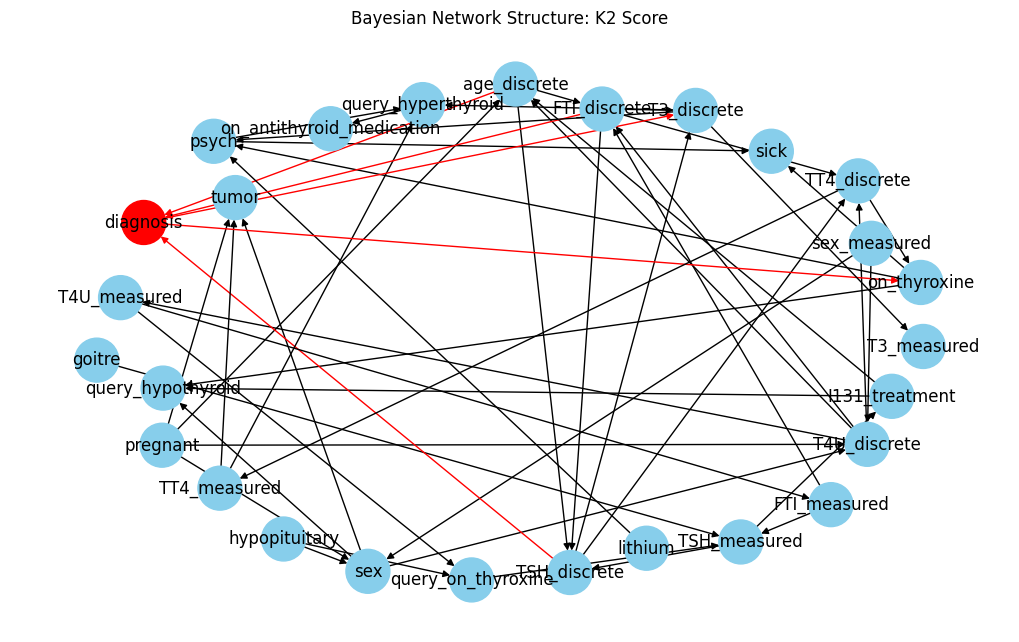

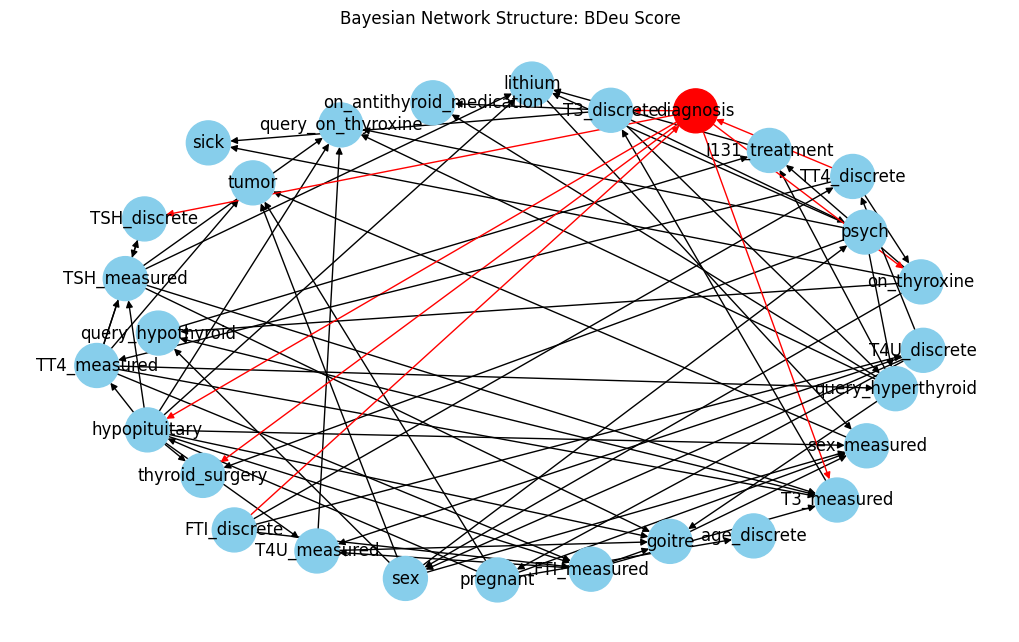

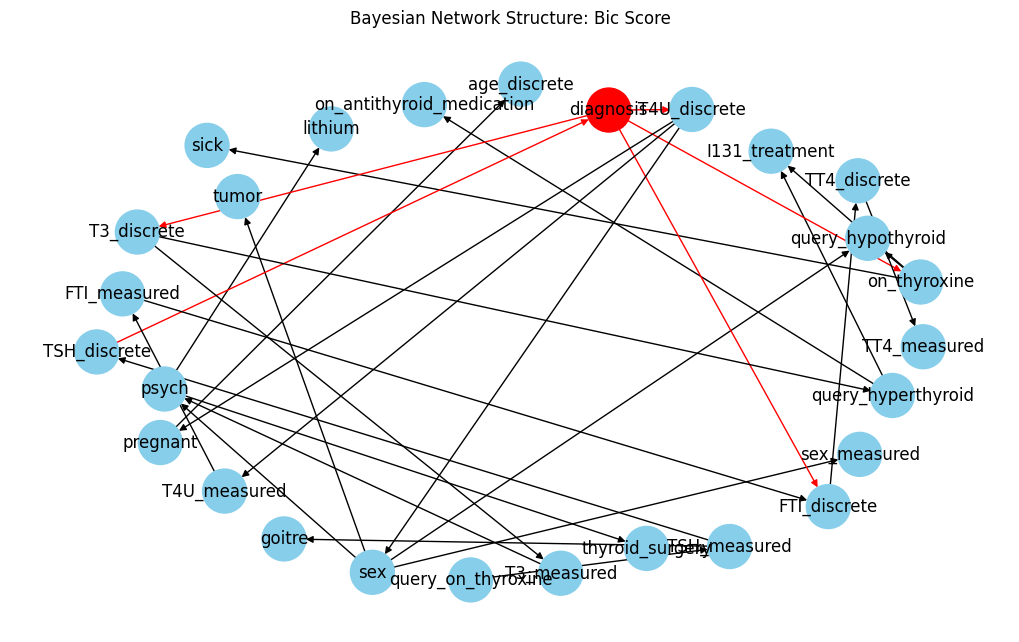

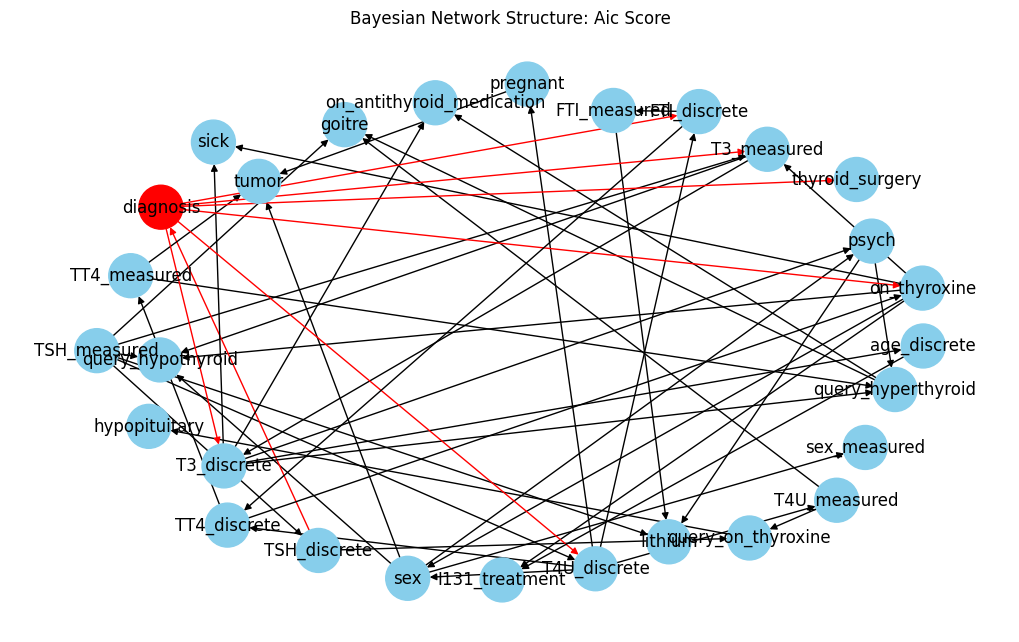

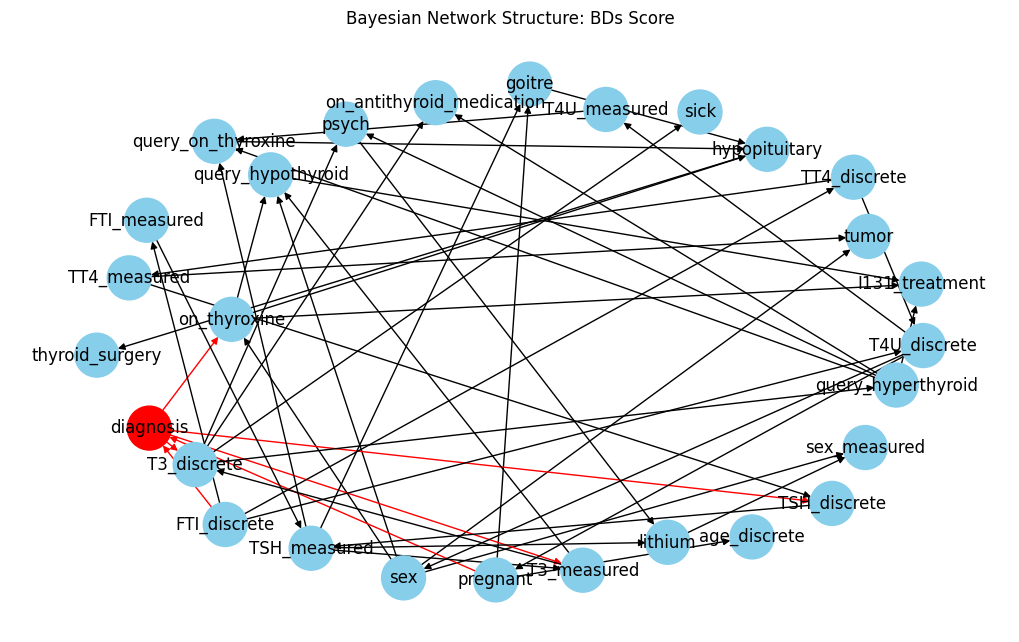

In [57]:
plot_bayesian_network(random_structure, "Random Structure")
plot_bayesian_network(K2Score_structure, "K2 Score")
plot_bayesian_network(BDeuScore_structure, "BDeu Score")
plot_bayesian_network(BicScore_structure, "Bic Score")
plot_bayesian_network(AicScore_structure, "Aic Score")
plot_bayesian_network(BDsScore_structure, "BDs Score")

# Parameter estimation

In [58]:
# Performs inference and calculate evaluation metrics
def evaluate_model(model, val_set_mod, true_labels):
    inference = VariableElimination(model)
    predicted_probabilities = []

    for _, row in val_set_mod.iterrows():
        evidence = row.to_dict()
        phi_query = inference.query(variables=['diagnosis'], evidence=evidence)
        predicted_probabilities.append(phi_query.values)

    predicted_probabilities = np.array(predicted_probabilities)
    predicted_probabilities = np.nan_to_num(predicted_probabilities, nan=1e-15)

    # MAP Predictions (maximum a posteriori)
    MAP_predictions = [int(probs.argmax()) for probs in predicted_probabilities]

    accuracy = accuracy_score(true_labels, MAP_predictions)
    precision = precision_score(true_labels, MAP_predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, MAP_predictions, average='macro')
    f1 = f1_score(true_labels, MAP_predictions, average='macro')
    logloss = log_loss(true_labels, predicted_probabilities)
    auc = roc_auc_score(true_labels, predicted_probabilities, average='macro', multi_class='ovr')
    conf_matrix = confusion_matrix(true_labels, MAP_predictions)
    class_report = classification_report(true_labels, MAP_predictions, zero_division=0)

    return accuracy, precision, recall, f1, logloss, auc, conf_matrix, class_report

# Performs k-fold cross-validation
def run_k_fold_cv(train_set, state_names, model_structure, priors, equivalent_sample_sizes, pseudo_counts, k_folds=5, print_out = True):
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    best_f1_score = -1
    best_model = None
    best_hyperparams = None
    best_metrics = None

    y = train_set['diagnosis']
    
    # grid search on BE
    for prior in priors:
        for equivalent_sample_size in (equivalent_sample_sizes if prior == 'BDeu' else [None]):
            for pseudo_count in (pseudo_counts if prior == 'dirichlet' else [None]):
                fold_accuracy_scores_be = []
                fold_recall_scores_be = []
                fold_f1_scores_be = []
                fold_precision_scores_be = []
                fold_logloss_scores_be = []
                fold_auc_scores_be = []

                # Perform k-fold cross-validation for this hyperparameter combination
                for train_index, val_index in skf.split(train_set, y):
                    train_fold, val_fold = train_set.iloc[train_index], train_set.iloc[val_index]
                    
                    val_set_mod = val_fold.drop(columns=['diagnosis'])
                    true_labels = val_fold['diagnosis'].astype(int).values

                    # Train and evaluate the BE model for each fold
                    BE_model = run_be(train_fold, val_set_mod, true_labels, state_names, model_structure, prior, equivalent_sample_size, pseudo_count)
                    accuracy, precision, recall, f1, logloss, auc, _, _ = evaluate_model(BE_model, val_set_mod, true_labels)
                    fold_f1_scores_be.append(f1)
                    fold_precision_scores_be.append(precision)
                    fold_logloss_scores_be.append(logloss)
                    fold_recall_scores_be.append(recall)
                    fold_accuracy_scores_be.append(accuracy)
                    fold_auc_scores_be.append(auc)

                # Calculate the average F1 score across all folds for this hyperparameter combination
                avg_f1_score_be = np.mean(fold_f1_scores_be)
                avg_precision_score_be = np.mean(fold_precision_scores_be)
                avg_logloss_score_be = np.mean(fold_logloss_scores_be)
                avg_accuracy_score_be = np.mean(fold_accuracy_scores_be)
                avg_recall_score_be = np.mean(fold_recall_scores_be)
                avg_auc_score_be = np.mean(fold_auc_scores_be)

                if print_out:
                    print(f"Hyperparameters: prior={prior}, equiv_sample_size={equivalent_sample_size}, pseudo_count={pseudo_count}, avg F1-score={avg_f1_score_be}")

                # If this BE model is better than the current best, update the best model and hyperparameters
                if avg_f1_score_be > best_f1_score:
                    best_f1_score = avg_f1_score_be
                    best_model = BE_model
                    best_metrics = [avg_accuracy_score_be, avg_precision_score_be, avg_recall_score_be, avg_f1_score_be, avg_logloss_score_be, avg_auc_score_be]
                    best_hyperparams = {
                        'method': 'BE',
                        'prior': prior,
                        'equivalent_sample_size': equivalent_sample_size,
                        'pseudo_count': pseudo_count
                    }
    if print_out: 
        print(f"Best model hyperparameters: {best_hyperparams}")
        print(f"Best model average F1-score: {best_f1_score}")
        print(f"Mest metrics: {best_metrics}")

    # Retrain the best model on the full training set
    final_model = run_be(train_set, None, None, state_names, model_structure, 
                                 best_hyperparams['prior'], 
                                 best_hyperparams['equivalent_sample_size'], 
                                 best_hyperparams['pseudo_count'])

    return final_model, best_hyperparams, best_metrics

# Function for grid search with Bayesian Estimator
def run_be(train_set, val_set_mod, true_labels, state_names, model_structure, prior, equivalent_sample_size, pseudo_count):
    model = BayesianNetwork(model_structure.edges())
    model.add_nodes_from(model_structure.nodes())
    
    # Bayesian Estimator with current hyperparameters
    BEestimator = BayesianEstimator(model, train_set, state_names=state_names)
    if prior == 'BDeu':
        BEparameters = BEestimator.get_parameters(prior_type=prior, n_jobs=4, equivalent_sample_size=equivalent_sample_size)
    elif prior == 'dirichlet':
        BEparameters = BEestimator.get_parameters(prior_type=prior, n_jobs=4, pseudo_counts=pseudo_count)
    else:
        BEparameters = BEestimator.get_parameters(prior_type=prior, n_jobs=4)

    model.add_cpds(*BEparameters)
    return model

In [59]:
def rank_models_on_selected_metrics(train_set, state_names, model_structures, k_folds=5):
    results = []
    model_names = list(model_structures.keys())
    
    # Iterate over each model structure
    for model_name, model_structure in model_structures.items():
        print(f"Running k-fold CV for {model_name}...")
        final_model, _, best_metrics = run_k_fold_cv(train_set, state_names, model_structure, priors=['K2'], equivalent_sample_sizes=[], pseudo_counts=[], k_folds=k_folds, print_out=False)
        
        # Append the best_metrics for this model
        results.append([model_name] + best_metrics)

    columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Logloss', 'AUC']
    metrics_df = pd.DataFrame(results, columns=columns)
    
    # Ranking only based on F1 Score (descending), Logloss (ascending), and AUC (descending)
    metrics_df['F1 Rank'] = metrics_df['F1 Score'].rank(ascending=False, method='min')
    metrics_df['Logloss Rank'] = metrics_df['Logloss'].rank(ascending=True, method='min')
    metrics_df['AUC Rank'] = metrics_df['AUC'].rank(ascending=False, method='min')
    
    # Sum the ranks to get an overall rank (lower total rank is better)
    metrics_df['Total Rank'] = metrics_df[['F1 Rank', 'Logloss Rank', 'AUC Rank']].sum(axis=1)
    
    ranked_df = metrics_df.sort_values(by='Total Rank').reset_index(drop=True)
    
    ranked_df = ranked_df[['Model', 'F1 Score', 'Logloss', 'AUC', 'Total Rank']]
    
    return ranked_df

In [60]:
model_structures = {
    'K2Score_structure': K2Score_structure,
    'BDeuScore_structure': BDeuScore_structure,
    'BicScore_structure': BicScore_structure,
    'AicScore_structure': AicScore_structure,
    'BDsScore_structure': BDsScore_structure
}

ranked_metrics_df = rank_models_on_selected_metrics(train_set, state_names, model_structures)
ranked_metrics_df

Running k-fold CV for K2Score_structure...
Running k-fold CV for BDeuScore_structure...
Running k-fold CV for BicScore_structure...
Running k-fold CV for AicScore_structure...
Running k-fold CV for BDsScore_structure...


Model  F1 Score   Logloss       AUC  Total Rank
0  BDeuScore_structure  0.735402  0.313994  0.983451         3.0
1   BicScore_structure  0.714668  0.320260  0.981316         7.0
2   AicScore_structure  0.692157  0.321289  0.982150         8.0
3   BDsScore_structure  0.674512  0.357302  0.970579        12.0
4    K2Score_structure  0.623924  0.598859  0.957114        15.0

# Hyperparameter Turning

In [64]:
def bayesian_network_hyperparameter_tuning(train_set, state_names, model_structure):
    priors = ['K2', 'dirichlet', 'BDeu']
    equivalent_sample_sizes = [1, 5, 10, 50, 100]  # Only relevant for BDeu
    pseudo_counts = [0.01, 0.05, 0.1, 0.25, 0.5, 1]  # Only relevant for dirichlet
    
    best_model, best_hyperparams, best_metrics = run_k_fold_cv(train_set, state_names, model_structure, priors, equivalent_sample_sizes, pseudo_counts, k_folds=5)
    return best_model, best_hyperparams, best_metrics

In [131]:
BDeu_best_model, BDeu_best_hyperparams, BDeu_best_metrics = bayesian_network_hyperparameter_tuning(train_set, state_names, BDeuScore_structure)

Hyperparameters: prior=K2, equiv_sample_size=None, pseudo_count=None, avg F1-score=0.7354023401329961
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.01, avg F1-score=0.7482526758543875
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.05, avg F1-score=0.7507756666711308
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.1, avg F1-score=0.749423535362293
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.25, avg F1-score=0.7477997020256486
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.5, avg F1-score=0.7411502232911671
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=1, avg F1-score=0.7354023401329961
Hyperparameters: prior=BDeu, equiv_sample_size=1, pseudo_count=None, avg F1-score=0.747156995400122
Hyperparameters: prior=BDeu, equiv_sample_size=5, pseudo_count=None, avg F1-score=0.7485880084603338
Hyperparameters: prior=BDeu, equiv_sample_size=10

In [132]:
Bic_best_model, Bic_best_hyperparams, Bic_best_metrics= bayesian_network_hyperparameter_tuning(train_set, state_names, BicScore_structure)

Hyperparameters: prior=K2, equiv_sample_size=None, pseudo_count=None, avg F1-score=0.7146677934296958
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.01, avg F1-score=0.7268384252131097
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.05, avg F1-score=0.7256860088839118
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.1, avg F1-score=0.7261708442308025
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.25, avg F1-score=0.7235640810214764
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.5, avg F1-score=0.719319577260543
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=1, avg F1-score=0.7146677934296958
Hyperparameters: prior=BDeu, equiv_sample_size=1, pseudo_count=None, avg F1-score=0.7265663164358371
Hyperparameters: prior=BDeu, equiv_sample_size=5, pseudo_count=None, avg F1-score=0.7264772659474135
Hyperparameters: prior=BDeu, equiv_sample_size=1

In [133]:
Aic_best_model, Aic_best_hyperparams, Aic_best_metrics= bayesian_network_hyperparameter_tuning(train_set, state_names, AicScore_structure)

Hyperparameters: prior=K2, equiv_sample_size=None, pseudo_count=None, avg F1-score=0.6921571255209396
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.01, avg F1-score=0.7356170014398217
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.05, avg F1-score=0.7357546290549698
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.1, avg F1-score=0.73518171244405
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.25, avg F1-score=0.7260129632979284
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.5, avg F1-score=0.7138782271225085
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=1, avg F1-score=0.6921571255209396
Hyperparameters: prior=BDeu, equiv_sample_size=1, pseudo_count=None, avg F1-score=0.732772253231429
Hyperparameters: prior=BDeu, equiv_sample_size=5, pseudo_count=None, avg F1-score=0.7338920901343052
Hyperparameters: prior=BDeu, equiv_sample_size=10,

In [134]:
random_best_model, random_best_hyperparams, best_metrics = bayesian_network_hyperparameter_tuning(train_set, state_names, random_structure)

Hyperparameters: prior=K2, equiv_sample_size=None, pseudo_count=None, avg F1-score=0.086835746452426
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.01, avg F1-score=0.08681468467266333
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.05, avg F1-score=0.08681468467266333
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.1, avg F1-score=0.08680812687681265
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.25, avg F1-score=0.08681865776519312
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=0.5, avg F1-score=0.08682720570952371
Hyperparameters: prior=dirichlet, equiv_sample_size=None, pseudo_count=1, avg F1-score=0.086835746452426
Hyperparameters: prior=BDeu, equiv_sample_size=1, pseudo_count=None, avg F1-score=0.08681468467266333
Hyperparameters: prior=BDeu, equiv_sample_size=5, pseudo_count=None, avg F1-score=0.08681468467266333
Hyperparameters: prior=BDeu, equiv_sample_

In [136]:
'''
# Save the best model to a file
with open('BDeu_best_model.pkl', 'wb') as f:
    pickle.dump(BDeu_best_model, f)

with open('random_best_model.pkl', 'wb') as f:
    pickle.dump(random_best_model, f)
'''

"\n# Save the best model to a file\nwith open('BDeu_best_model.pkl', 'wb') as f:\n    pickle.dump(BDeu_best_model, f)\n\nwith open('random_best_model.pkl', 'wb') as f:\n    pickle.dump(random_best_model, f)\n"

### Neural Network 

In [61]:
def evaluate_nn_model(nn_model, feature_group, true_labels, num_classes=10):
    
    # Get probability predictions from the neural network model
    predicted_probabilities = nn_model.predict(feature_group)
    # MAP estimate 
    predicted_classes = np.argmax(predicted_probabilities, axis=1)
    
    accuracy = accuracy_score(true_labels, predicted_classes)
    precision = precision_score(true_labels, predicted_classes, average='macro', zero_division=0)
    recall = recall_score(true_labels, predicted_classes, average='macro')
    f1 = f1_score(true_labels, predicted_classes, average='macro')
    conf_matrix = confusion_matrix(true_labels, predicted_classes)
    logloss = log_loss(true_labels, predicted_probabilities) #, labels=np.arange(num_classes))
    auc = roc_auc_score(true_labels, predicted_probabilities, average='macro', multi_class='ovr') #, labels=np.arange(num_classes))
    class_report =  classification_report(true_labels, predicted_classes, zero_division=0)

    return accuracy, precision, recall, f1, logloss, auc, conf_matrix, class_report

In [62]:
def preprocess_text_data(data):
    if isinstance(data, pd.Series):
        # Convert a single column (Series) from strings to integers
        return data.astype(int)
    
    elif isinstance(data, pd.DataFrame):
        # Convert each column in the DataFrame from strings to integers
        data_processed = data.copy()
        for column in data_processed.columns:
            data_processed[column] = data_processed[column].astype(int)
        return data_processed

In [63]:
# Define the hyperparameter space
param_grid = {
    'epochs': [50],
    'batch_size': [64],
    'optimizer': ['adam', 'sgd'],
    'learning_rate': [0.001, 0.01, 0.02],
    'activation': ['relu', 'tanh']
}

In [116]:
y_train_encoded = preprocess_text_data(y_train)
X_train_encoded = preprocess_text_data(X_train)

nn_classifier = KerasClassifier(
    model=build_nn_model_with_masking, 
    input_dim=X_train_encoded.shape[1], 
    num_classes=10, 
    verbose=0,
    optimizer='adam', 
    learning_rate=0.001,
    activation='relu')

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object with stratified cross-validation
grid = GridSearchCV(estimator=nn_classifier, param_grid=param_grid, scoring='f1_macro', cv=skf)
grid_result = grid.fit(X_train_encoded, y_train_encoded)

print(f"Best model average F1-score: {grid_result.best_score_}") 
print(f"Best Hyperparameters: {grid_result.best_params_}")

Best model average F1-score: 0.7562604031073372
Best Hyperparameters: {'activation': 'relu', 'batch_size': 64, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'adam'}


In [69]:
best_params = grid_result.best_params_

# Build and compile the model with the best hyperparameters
nn_best_model = build_nn_model_with_masking(
    input_dim=X_train_encoded.shape[1],
    num_classes=10,
    mask_value=-2,
    optimizer=best_params['optimizer'], 
    learning_rate=best_params['learning_rate'],
    activation=best_params['activation']
)

# Train the final model on the full training set with the best hyperparameters
nn_best_model.fit(
    X_train_encoded, y_train_encoded,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size']
)

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7496 - loss: 1.0894
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7992 - loss: 0.6993
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8181 - loss: 0.5939
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8291 - loss: 0.5571
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8206 - loss: 0.5588
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8237 - loss: 0.5433
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8276 - loss: 0.5137
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8303 - loss: 0.5072
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8426 - loss: 0.4774
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8431 - loss: 0.4582
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8486 - loss: 0.4554
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [70]:
accuracy, precision, recall, f1, logloss, auc, conf_matrix = evaluate_nn_model(nn_best_model, X_train_encoded, y_train_encoded)
print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1: {f1}, Logloss: {logloss}, AUC: {auc}")

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9027611044417767, Precision: 0.8077486108194851, Recall: 0.7296803008060285, F1: 0.7482579756670422, Logloss: 0.2773729584320237, AUC: 0.9865612903808441


In [137]:
'''
# Save the best model to a file
with open('nn_best_model.pkl', 'wb') as f:
    pickle.dump(nn_best_model, f)
'''

"\n# Save the best model to a file\nwith open('nn_best_model.pkl', 'wb') as f:\n    pickle.dump(nn_best_model, f)\n"

# Model selection 

In [65]:
# Load the model from the file
BDeu_best_model = BayesianNetwork()
with open('BDeu_best_model.pkl', 'rb') as f:
    BDeu_best_model = pickle.load(f)

random_best_model = BayesianNetwork()
with open('random_best_model.pkl', 'rb') as f:
    random_best_model = pickle.load(f)

with open('nn_best_model.pkl', 'rb') as f:
    nn_best_model= pickle.load(f)

2024-11-11 22:03:16.686626: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-11 22:03:16.686739: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: mscluster44.ms.wits.ac.za
2024-11-11 22:03:16.686751: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: mscluster44.ms.wits.ac.za
2024-11-11 22:03:16.686929: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 525.147.5
2024-11-11 22:03:16.686959: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 525.147.5
2024-11-11 22:03:16.686967: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 525.147.5


In [67]:
accuracy, precision, recall, f1, logloss, auc, conf_matrix, class_report = evaluate_model(BDeu_best_model, X_test, y_test.astype(int).values)
print(f' Accuracy: {accuracy}\n Precision: {precision}\n Recall: {recall}\n F1: {f1}\n Logloss: {logloss}\n AUC: {auc}')

 Accuracy: 0.9024943310657596
 Precision: 0.7903928746006825
 Recall: 0.7568506881894306
 F1: 0.7695595205959129
 Logloss: 0.2811604899642791
 AUC: 0.9850546291967064


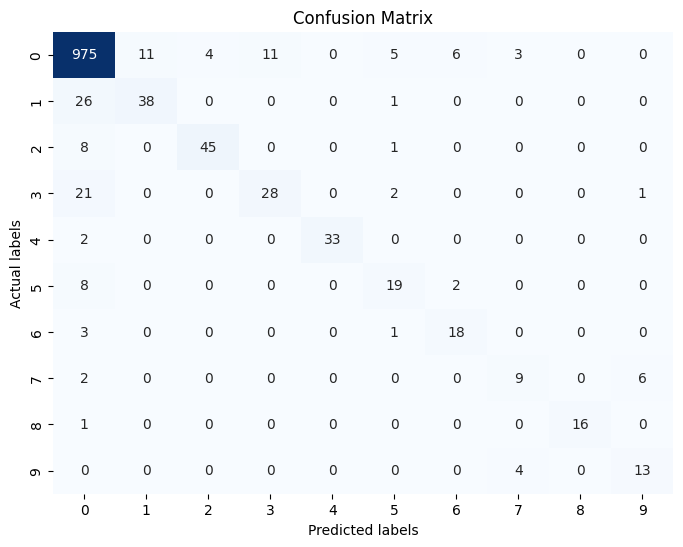

In [81]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

In [82]:
print(class_report)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1015
           1       0.78      0.58      0.67        65
           2       0.92      0.83      0.87        54
           3       0.72      0.54      0.62        52
           4       1.00      0.94      0.97        35
           5       0.66      0.66      0.66        29
           6       0.69      0.82      0.75        22
           7       0.56      0.53      0.55        17
           8       1.00      0.94      0.97        17
           9       0.65      0.76      0.70        17

    accuracy                           0.90      1323
   macro avg       0.79      0.76      0.77      1323
weighted avg       0.90      0.90      0.90      1323



Not really bad at classifying classes that have less datapoints (5 - 9)

In [83]:
accuracy, precision, recall, f1, logloss, auc, conf_matrix, class_report = evaluate_model(random_best_model, X_test, y_test.astype(int).values)
print(f' Accuracy: {accuracy}\n Precision: {precision}\n Recall: {recall}\n F1: {f1}\n Logloss: {logloss}\n AUC: {auc}')

 Accuracy: 0.7664399092970522
 Precision: 0.07676003028009085
 Recall: 0.09990147783251233
 F1: 0.08681506849315068
 Logloss: 0.9893668055294266
 AUC: 0.6031592180869237


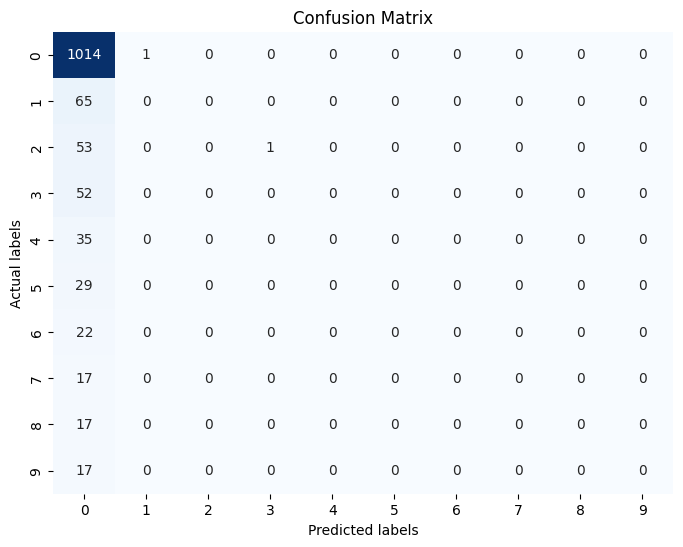

In [84]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

In [85]:
print(class_report)

              precision    recall  f1-score   support

           0       0.77      1.00      0.87      1015
           1       0.00      0.00      0.00        65
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00        52
           4       0.00      0.00      0.00        35
           5       0.00      0.00      0.00        29
           6       0.00      0.00      0.00        22
           7       0.00      0.00      0.00        17
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00        17

    accuracy                           0.77      1323
   macro avg       0.08      0.10      0.09      1323
weighted avg       0.59      0.77      0.67      1323



In [86]:
y_test_encoded = preprocess_text_data(y_test)
X_test_encoded = preprocess_text_data(X_test)

accuracy, precision, recall, f1, logloss, auc, conf_matrix, class_report = evaluate_nn_model(nn_best_model, X_test_encoded, y_test_encoded)
print(f"Accuracy: {accuracy}\n Precision: {precision}\n Recall: {recall}\n F1: {f1}\n Logloss: {logloss}\n AUC: {auc}")

42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step 
Accuracy: 0.9032501889644747
 Precision: 0.775109673657225
 Recall: 0.712182118084755
 F1: 0.7250181396726157
 Logloss: 0.2992376336640042
 AUC: 0.9827966225451121


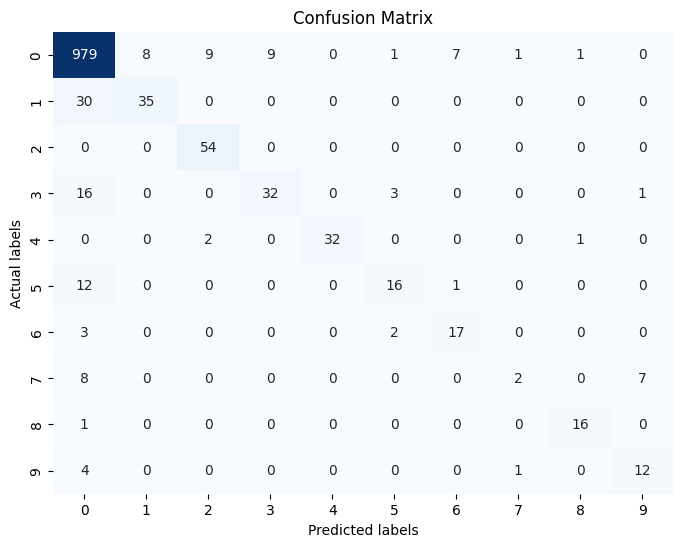

In [87]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')
plt.show()

In [88]:
print(class_report)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      1015
           1       0.81      0.54      0.65        65
           2       0.83      1.00      0.91        54
           3       0.78      0.62      0.69        52
           4       1.00      0.91      0.96        35
           5       0.73      0.55      0.63        29
           6       0.68      0.77      0.72        22
           7       0.50      0.12      0.19        17
           8       0.89      0.94      0.91        17
           9       0.60      0.71      0.65        17

    accuracy                           0.90      1323
   macro avg       0.78      0.71      0.73      1323
weighted avg       0.90      0.90      0.90      1323



# Category Information Importance

In [66]:
# Group features into respective categories

demographic = X_test[['age_discrete', 'sex', 'sex_measured']]

biological= X_test[['TSH_discrete', 'T3_discrete', 'TT4_discrete', 'T4U_discrete', 'FTI_discrete']]

biological_indicators = X_test[['TSH_measured', 'T3_measured', 'TT4_measured', 'T4U_measured', 'FTI_measured']]

medications_and_treatments = X_test[['on_thyroxine', 'query_on_thyroxine', 'on_antithyroid_medication', 'lithium', 'thyroid_surgery', 'I131_treatment']]

physiological_conditions = X_test[['sick', 'pregnant', 'query_hypothyroid', 'query_hyperthyroid', 
                                   'psych', 'goitre', 'tumor', 'hypopituitary']]

In [67]:
groups = {
    'Demographic': demographic,
    'Biological': biological,
    'Biological Indicators': biological_indicators,
    'Medications and Treatments': medications_and_treatments,
    'Physiological Conditions': physiological_conditions
}

In [68]:
def fill_missing_columns(feature_group, X_test, input_dim, mask_value):
    """
    Add missing columns to the feature group, filling them with the mask value.
    
    Parameters:
    - feature_group: DataFrame containing features for the current group.
    - X_test: The full test dataset to use for reference.
    - input_dim: The expected number of input features for the model.
    - mask_value: The value to use for missing columns.
    
    Returns:
    - feature_group_filled: DataFrame with missing columns filled in.
    """
    # Create a full mask array with the correct shape
    full_masked_input = np.full((feature_group.shape[0], input_dim), mask_value)
    
    # For each column in the feature group, fill in the corresponding part of the masked input
    for col in feature_group.columns:
        full_masked_input[:, X_test.columns.get_loc(col)] = feature_group[col]
    
    return full_masked_input

In [69]:
def evaluate_model_by_group(model, groups, true_labels, X_test=None, nn=False, input_dim=None, mask_value=-2):
    """
    Evaluate a model (neural network or other) by feature group.
    
    Parameters:
    - model: The model to evaluate (neural network or non-neural network model).
    - groups: Dictionary of feature groups to evaluate the model with.
    - true_labels: The true labels for evaluation.
    - nn: Boolean flag to indicate if the model is a neural network.
    - X_test: The full test dataset for reference when filling missing columns (only for nn=True).
    - input_dim: Number of input features expected by the neural network (only for nn=True).
    - mask_value: The value to use for masking missing columns (only for nn=True).
    """
    evaluation_results = []
    
    for group_name, feature_group in groups.items():
        # If the model is a neural network, fill missing columns with mask value
        if nn:
            feature_group_filled = fill_missing_columns(feature_group, X_test, input_dim, mask_value)
            accuracy, precision, recall, f1, logloss, auc, _, _ = evaluate_nn_model(
                model, feature_group_filled, true_labels
            )
        else:
            accuracy, precision, recall, f1, logloss, auc, _, _ = evaluate_model(
                model, feature_group, true_labels
            )
        
        evaluation_results.append({
            'group': group_name,
            'f1_score': f1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'logloss': logloss,
            'auc': auc,
        })
    
    results_df = pd.DataFrame(evaluation_results)
    sorted_results_df = results_df.sort_values(by='f1_score', ascending=False).reset_index(drop=True)
    
    return sorted_results_df

In [70]:
def plot_multibar_graph(df, columns, x_col, title):
    # Set width of bar
    bar_width = 0.25
    
    # Set position of bar on X axis
    x = np.arange(len(df[x_col]))
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot bars for each metric
    for i, col in enumerate(columns):
        ax.bar(x + i * bar_width, df[col], width=bar_width, label=col)
    
        # Add text annotations (rounded to 2 decimal places)
        for j, value in enumerate(df[col]):
            ax.text(x[j] + i * bar_width, value + 0.01, f'{value:.2f}', ha='center', fontsize=9)
    
    # Add labels and title
    ax.set_xlabel(x_col)
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(df[x_col], rotation=45, ha='right')
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [71]:
BDeu_group_results_df = evaluate_model_by_group(BDeu_best_model, groups, y_test.astype(int).values)

BDeu_group_results_df

group  f1_score  accuracy  precision    recall  \
0                  Biological  0.547868  0.870748   0.561808  0.540752   
1    Physiological Conditions  0.093896  0.767196   0.116917  0.103649   
2                 Demographic  0.086826  0.767196   0.076720  0.100000   
3  Medications and Treatments  0.086826  0.767196   0.076720  0.100000   
4       Biological Indicators  0.086778  0.766440   0.076702  0.099901   

    logloss       auc  
0  0.357040  0.975383  
1  0.996959  0.562805  
2  1.011463  0.583283  
3  0.937830  0.666317  
4  0.996329  0.584157

In [74]:
# Focus on relevant metrics
metrics = ['f1_score', 'auc', 'logloss']

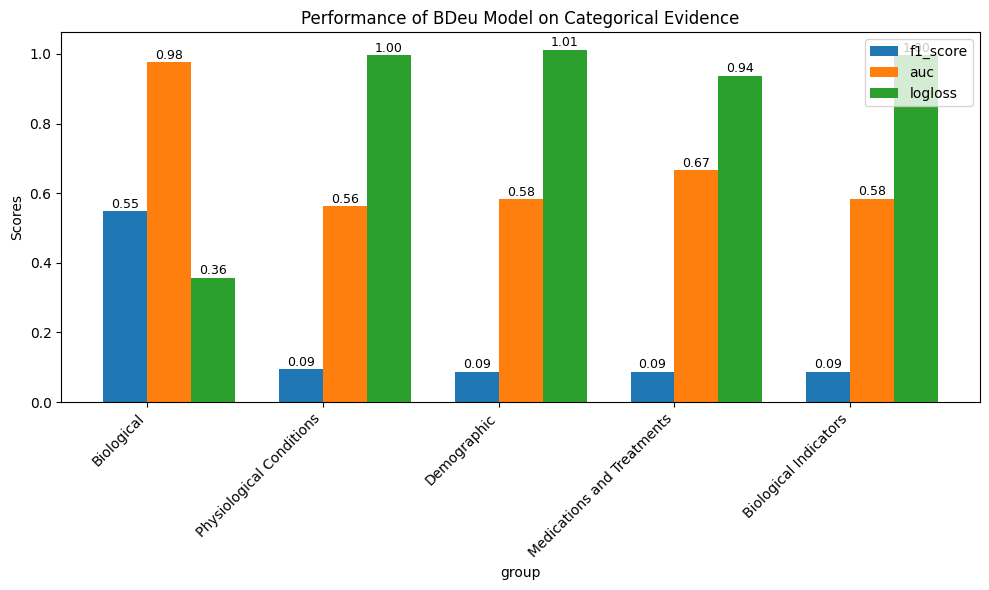

In [75]:
# Plot the multibar graph
plot_multibar_graph(BDeu_group_results_df, metrics, 'group', 'Performance of BDeu Model on Categorical Evidence')

In [97]:
random_group_results_df = evaluate_model_by_group(random_best_model, groups, y_test.astype(int).values)

random_group_results_df

group  f1_score  accuracy  precision  recall  \
0                 Demographic  0.086826  0.767196    0.07672     0.1   
1                  Biological  0.086826  0.767196    0.07672     0.1   
2       Biological Indicators  0.086826  0.767196    0.07672     0.1   
3  Medications and Treatments  0.086826  0.767196    0.07672     0.1   
4    Physiological Conditions  0.086826  0.767196    0.07672     0.1   

    logloss       auc  
0  1.001109  0.564594  
1  1.024804  0.505534  
2  1.020302  0.485260  
3  1.025267  0.499498  
4  1.016891  0.531505

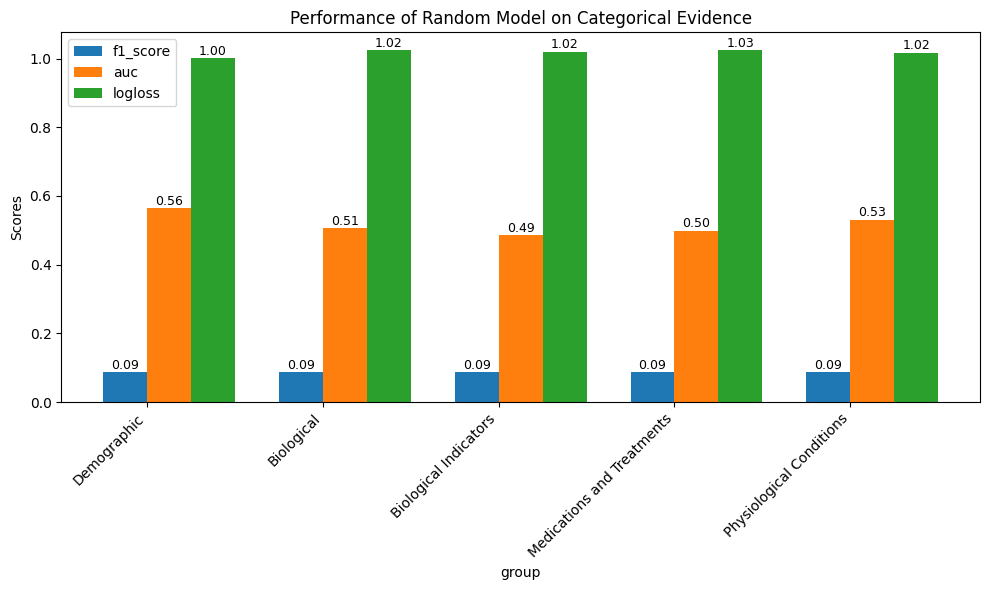

In [98]:
# Plot the multibar graph
plot_multibar_graph(random_group_results_df, metrics, 'group', 'Performance of Random Model on Categorical Evidence')

In [108]:
nn_group_results_df = evaluate_model_by_group(
    model=nn_best_model,        
    groups=groups,            
    X_test=X_test_encoded,             
    true_labels=y_test_encoded,
    input_dim=X_test_encoded.shape[1],
    mask_value=-2, 
    nn= True
)

nn_group_results_df

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


group  f1_score  accuracy  precision  recall  \
0                  Biological  0.097321  0.070295   0.092588  0.2355   
1       Biological Indicators  0.009623  0.049131   0.005054  0.1000   
2                 Demographic  0.003271  0.016629   0.001663  0.1000   
3    Physiological Conditions  0.003271  0.016629   0.001663  0.1000   
4  Medications and Treatments  0.002537  0.012850   0.001285  0.1000   

    logloss       auc  
0  4.874742  0.677831  
1  2.846728  0.515713  
2  4.195557  0.483372  
3  5.938097  0.556836  
4  7.558095  0.578178

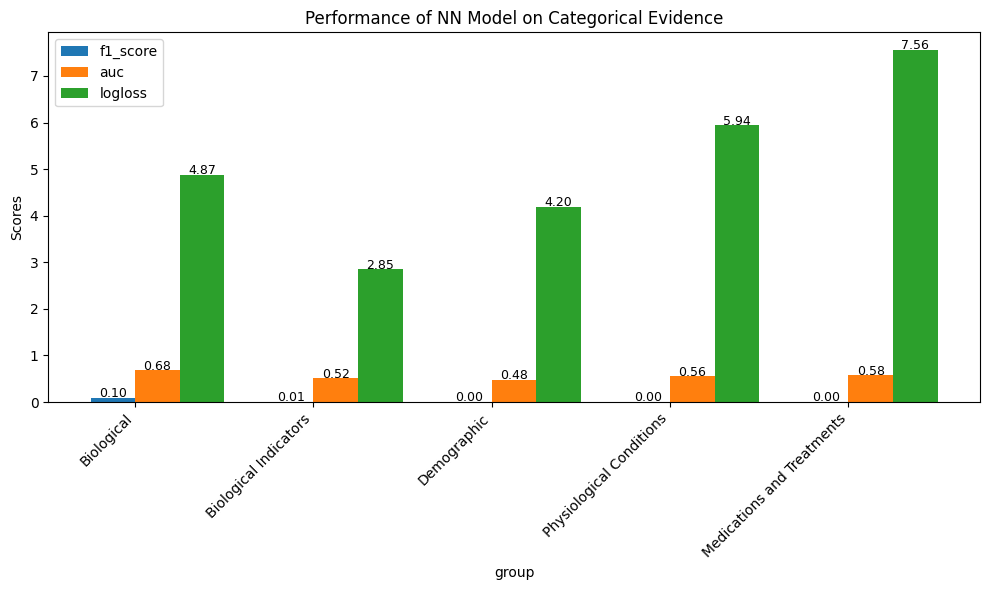

In [109]:
plot_multibar_graph(nn_group_results_df, metrics, 'group', 'Performance of NN Model on Categorical Evidence')

In [72]:
def evaluate_model_by_group_combinations(model, groups, true_labels,  X_test = None, input_dim=None, mask_value=-2, nn=False, num_classes=10):
    """
    Evaluate a model using all possible combinations of feature groups.
    If nn is True, it evaluates a neural network, otherwise it evaluates other models.
    """
    evaluation_results = []
    
    # Generate all possible combinations of the groups (1 to len(groups))
    group_names = list(groups.keys())
    for r in range(1, len(groups) + 1):
        for group_combination in itertools.combinations(group_names, r):
            # Combine the features for the current combination of groups
            combined_features = pd.concat([groups[group] for group in group_combination], axis=1)
            
            if nn:
                combined_features_filled = fill_missing_columns(combined_features, X_test, input_dim, mask_value)
                accuracy, precision, recall, f1, logloss, auc, _, _ = evaluate_nn_model(
                    model, combined_features_filled, true_labels, num_classes=num_classes
                )
            else:
                accuracy, precision, recall, f1, logloss, auc, _, _ = evaluate_model(
                    model, combined_features, true_labels
                )
                
            evaluation_results.append({
                'groups_combined': group_combination,
                'f1_score': f1,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'logloss': logloss,
                'auc': auc,
                'combination_length': len(group_combination)
            })
    
    results_df = pd.DataFrame(evaluation_results)
    
    sorted_results_df = results_df.sort_values(by=['f1_score', 'combination_length'], ascending=[False, True]).reset_index(drop=True)
    
    return sorted_results_df

In [77]:
BDeu_group_combo_results_df = evaluate_model_by_group_combinations(BDeu_best_model, groups, y_test.astype(int).values)
BDeu_group_combo_results_df

groups_combined  f1_score  accuracy  \
0   (Biological, Biological Indicators, Medication...  0.769560  0.902494   
1   (Demographic, Biological, Biological Indicator...  0.769560  0.902494   
2   (Biological, Medications and Treatments, Physi...  0.767977  0.901738   
3   (Demographic, Biological, Medications and Trea...  0.767977  0.901738   
4   (Biological, Biological Indicators, Medication...  0.765296  0.901738   
5   (Demographic, Biological, Biological Indicator...  0.765296  0.901738   
6            (Biological, Medications and Treatments)  0.762822  0.900227   
7   (Demographic, Biological, Medications and Trea...  0.762822  0.900227   
8   (Demographic, Biological, Physiological Condit...  0.573083  0.872260   
9   (Demographic, Biological, Biological Indicator...  0.570594  0.872260   
10             (Biological, Physiological Conditions)  0.569332  0.873772   
11  (Biological, Biological Indicators, Physiologi...  0.569332  0.873772   
12                          (Demographic, Biological)  0.557449  0.871504   
13   (Demographic, Biological, Biological Indicators)  0.554841  0.871504   
14                                      (Biological,)  0.547868  0.870748   
15                (Biological, Biological Indicators)  0.547868  0.870748   
16  (Demographic, Biological Indicators, Medicatio...  0.100415  0.767196   
17  (Biological Indicators, Medications and Treatm...  0.100238  0.767952   
18                        (Physiological Conditions,)  0.093896  0.767196   
19            (Demographic, Physiological Conditions)  0.093896  0.767196   
20  (Medications and Treatments, Physiological Con...  0.093896  0.767196   
21  (Demographic, Medications and Treatments, Phys...  0.093896  0.767196   
22  (Demographic, Biological Indicators, Physiolog...  0.093847  0.766440   
23  (Biological Indicators, Physiological Conditions)  0.090507  0.766440   
24                                     (Demographic,)  0.086826  0.767196   
25                      (Medications and Treatments,)  0.086826  0.767196   
26                           (Biological Indicators,)  0.086778  0.766440   
27               (Demographic, Biological Indicators)  0.086778  0.766440   
28          (Demographic, Medications and Treatments)  0.086729  0.765684   
29  (Biological Indicators, Medications and Treatm...  0.086681  0.764928   
30  (Demographic, Biological Indicators, Medicatio...  0.086681  0.764928   

    precision    recall   logloss       auc  combination_length  
0    0.790393  0.756851  0.281160  0.985055                   4  
1    0.790393  0.756851  0.281160  0.985055                   5  
2    0.790304  0.753994  0.281756  0.985009                   3  
3    0.790304  0.753994  0.281757  0.985034                   4  
4    0.785853  0.752305  0.282068  0.984949                   3  
5    0.785853  0.752305  0.281778  0.984984                   4  
6    0.783921  0.749350  0.283852  0.984842                   2  
7    0.783921  0.749350  0.283786  0.984843                   3  
8    0.629872  0.560014  0.355837  0.976150                   3  
9    0.625551  0.558326  0.355263  0.976193                   4  
10   0.622575  0.558076  0.356640  0.975350                   2  
11   0.622575  0.558076  0.356058  0.975456                   3  
12   0.573736  0.549685  0.355082  0.976184                   2  
13   0.569283  0.547997  0.354492  0.976230                   3  
14   0.561808  0.540752  0.357040  0.975383                   1  
15   0.561808  0.540752  0.356449  0.975502                   2  
16   0.134142  0.107298  0.878849  0.761963                   4  
17   0.127017  0.107397  0.881826  0.758847                   3  
18   0.116917  0.103649  0.996959  0.562805                   1  
19   0.116917  0.103649  0.990225  0.587287                   2  
20   0.116917  0.103649  0.909430  0.715235                   2  
21   0.116917  0.103649  0.906211  0.714973                   3  
22   0.116900  0.103551  0.962736  0.650484            

In [107]:
random_group_combo_results_df = evaluate_model_by_group_combinations(random_best_model, groups, y_test.astype(int).values)
random_group_combo_results_df

groups_combined  f1_score  accuracy  \
0   (Medications and Treatments, Physiological Con...  0.086864  0.767196   
1   (Demographic, Medications and Treatments, Phys...  0.086864  0.767196   
2   (Biological, Medications and Treatments, Physi...  0.086864  0.767196   
3   (Biological Indicators, Medications and Treatm...  0.086864  0.767196   
4   (Demographic, Biological, Medications and Trea...  0.086864  0.767196   
5   (Biological, Biological Indicators, Medication...  0.086864  0.767196   
6                                      (Demographic,)  0.086826  0.767196   
7                                       (Biological,)  0.086826  0.767196   
8                            (Biological Indicators,)  0.086826  0.767196   
9                       (Medications and Treatments,)  0.086826  0.767196   
10                        (Physiological Conditions,)  0.086826  0.767196   
11                          (Demographic, Biological)  0.086826  0.767196   
12          (Demographic, Medications and Treatments)  0.086826  0.767196   
13            (Demographic, Physiological Conditions)  0.086826  0.767196   
14                (Biological, Biological Indicators)  0.086826  0.767196   
15           (Biological, Medications and Treatments)  0.086826  0.767196   
16             (Biological, Physiological Conditions)  0.086826  0.767196   
17  (Biological Indicators, Medications and Treatm...  0.086826  0.767196   
18  (Biological Indicators, Physiological Conditions)  0.086826  0.767196   
19  (Demographic, Biological, Medications and Trea...  0.086826  0.767196   
20  (Demographic, Biological, Physiological Condit...  0.086826  0.767196   
21  (Biological, Biological Indicators, Medication...  0.086826  0.767196   
22  (Biological, Biological Indicators, Physiologi...  0.086826  0.767196   
23  (Demographic, Biological Indicators, Medicatio...  0.086815  0.766440   
24  (Demographic, Biological, Biological Indicator...  0.086815  0.766440   
25               (Demographic, Biological Indicators)  0.086778  0.766440   
26   (Demographic, Biological, Biological Indicators)  0.086778  0.766440   
27  (Demographic, Biological Indicators, Medicatio...  0.086778  0.766440   
28  (Demographic, Biological Indicators, Physiolog...  0.086778  0.766440   
29  (Demographic, Biological, Biological Indicator...  0.086778  0.766440   
30  (Demographic, Biological, Biological Indicator...  0.086778  0.766440   

    precision    recall   logloss       auc  combination_length  
0    0.076778  0.100000  1.016419  0.526866                   2  
1    0.076778  0.100000  0.992657  0.583494                   3  
2    0.076778  0.100000  1.016419  0.526866                   3  
3    0.076778  0.100000  1.011322  0.538989                   3  
4    0.076778  0.100000  0.992657  0.583494                   4  
5    0.076778  0.100000  1.011322  0.538989                   4  
6    0.076720  0.100000  1.001109  0.564594                   1  
7    0.076720  0.100000  1.024804  0.505534                   1  
8    0.076720  0.100000  1.020302  0.485260                   1  
9    0.076720  0.100000  1.025267  0.499498                   1  
10   0.076720  0.100000  1.016891  0.531505                   1  
11   0.076720  0.100000  1.000855  0.568687                   2  
12   0.076720  0.100000  1.001144  0.563772                   2  
13   0.076720  0.100000  0.993270  0.582840                   2  
14   0.076720  0.100000  1.020006  0.507085                   2  
15   0.076720  0.100000  1.025274  0.424063                   2  
16   0.076720  0.100000  1.016930  0.508763                   2  
17   0.076720  0.100000  1.020036  0.512142                   2  
18   0.076720  0.100000  1.012208  0.537376                   2  
19   0.076720  0.100000  1.001160  0.564230                   3  
20   0.076720  0.100000  0.993290  0.582306                   3  
21   0.076720  0.100000  1.020036  0.512142                   3  
22   0.076720  0.100000  1.012294  0.488100            

In [112]:
nn_group_combo_results_df = evaluate_model_by_group_combinations(
    model=nn_best_model,        
    groups=groups,      
    true_labels=y_test_encoded,  
    X_test =  X_test_encoded,
    input_dim=X_test.shape[1],  
    mask_value=-2,       
    nn=True,              
    num_classes=10          
)

nn_group_combo_results_df

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━

groups_combined  f1_score  accuracy  \
0   (Demographic, Biological, Biological Indicator...  0.725018  0.903250   
1   (Demographic, Biological, Biological Indicator...  0.692879  0.873016   
2   (Biological, Biological Indicators, Medication...  0.491885  0.597884   
3    (Demographic, Biological, Biological Indicators)  0.390316  0.788360   
4   (Demographic, Biological, Biological Indicator...  0.380370  0.808012   
5   (Biological, Biological Indicators, Medication...  0.333603  0.383220   
6   (Biological, Biological Indicators, Physiologi...  0.285599  0.560847   
7                 (Biological, Biological Indicators)  0.193184  0.284958   
8              (Biological, Physiological Conditions)  0.098659  0.074830   
9                                       (Biological,)  0.097321  0.070295   
10               (Demographic, Biological Indicators)  0.086915  0.765684   
11  (Demographic, Biological Indicators, Medicatio...  0.086915  0.765684   
12  (Demographic, Biological Indicators, Medicatio...  0.086864  0.767196   
13  (Demographic, Biological Indicators, Physiolog...  0.086826  0.767196   
14           (Biological, Medications and Treatments)  0.081368  0.071807   
15  (Demographic, Biological, Physiological Condit...  0.075465  0.059713   
16  (Biological, Medications and Treatments, Physi...  0.068883  0.070295   
17                          (Demographic, Biological)  0.049229  0.054422   
18  (Demographic, Biological, Medications and Trea...  0.041035  0.055178   
19  (Demographic, Biological, Medications and Trea...  0.035258  0.058201   
20  (Biological Indicators, Medications and Treatm...  0.016920  0.077098   
21  (Biological Indicators, Physiological Conditions)  0.009644  0.049131   
22                           (Biological Indicators,)  0.009623  0.049131   
23  (Biological Indicators, Medications and Treatm...  0.009400  0.049131   
24          (Demographic, Medications and Treatments)  0.008177  0.016629   
25            (Demographic, Physiological Conditions)  0.003473  0.017385   
26  (Demographic, Medications and Treatments, Phys...  0.003281  0.016629   
27                                     (Demographic,)  0.003271  0.016629   
28                        (Physiological Conditions,)  0.003271  0.016629   
29                      (Medications and Treatments,)  0.002537  0.012850   
30  (Medications and Treatments, Physiological Con...  0.002537  0.012850   

    precision    recall   logloss       auc  combination_length  
0    0.775110  0.712182  0.299238  0.982797                   5  
1    0.701255  0.718966  0.373353  0.978876                   4  
2    0.451558  0.707939  0.979591  0.949638                   4  
3    0.437665  0.424182  0.801253  0.946981                   3  
4    0.466499  0.388492  0.742921  0.949261                   4  
5    0.394995  0.538213  1.677534  0.924619                   3  
6    0.336932  0.429025  1.516961  0.908097                   3  
7    0.289289  0.388246  1.883193  0.908312                   2  
8    0.075729  0.246468  4.722197  0.684083                   2  
9    0.092588  0.235500  4.874742  0.677831                   1  
10   0.076976  0.099803  1.791390  0.473781                   2  
11   0.076976  0.099803  1.890226  0.646665                   3  
12   0.076778  0.100000  1.919255  0.650118                   4  
13   0.076720  0.100000  1.882298  0.485264                   3  
14   0.071629  0.262677  4.963784  0.716543                   2  
15   0.058923  0.209859  3.783170  0.706104                   3  
16   0.051196  0.233972  4.862999  0.748753                   3  
17   0.052485  0.197109  3.846070  0.701321                   2  
18   0.043132  0.203893  3.483973  0.794186                   4  
19   0.065686  0.206911  3.639911  0.786823                   3  
20   0.076408  0.103645  2.480746  0.590686                   2  
21   0.005066  0.100000  2.318761  0.526923                   2  
22   0.005054  0.100000  2.846728  0.515713            

# Feature importance

In [73]:
def evaluate_model_by_feature(model, X_test, true_labels, nn=False, input_dim=None, mask_value=-2, num_classes=10):
    """
    Evaluate a model (neural network or other model) on each individual feature in X_test.
    
    Parameters:
    - nn: Set to True if evaluating a neural network, otherwise False.
    - input_dim: The number of input features expected by the neural network.
    - mask_value: The value to use for masking missing columns in the neural network.
    - num_classes: The number of classes for multi-class classification (used for logloss and AUC).
    """
    evaluation_results = []
    
    for feature_name in X_test.columns:
        feature_data = X_test[[feature_name]]  # Subset the DataFrame to the current feature
        
        if nn:
            feature_data_filled = fill_missing_columns(feature_data, X_test, input_dim, mask_value)
            accuracy, precision, recall, f1, logloss, auc, _, _ = evaluate_nn_model(
                model, feature_data_filled, true_labels, num_classes=num_classes
            )
        else:
            accuracy, precision, recall, f1, logloss, auc, _, _ = evaluate_model(
                model, feature_data, true_labels
            )
        
        evaluation_results.append({
            'feature': feature_name,
            'f1_score': f1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'logloss': logloss,
            'auc': auc,
        })
    
    results_df = pd.DataFrame(evaluation_results)
    
    sorted_results_df = results_df.sort_values(by=['f1_score', 'logloss'], ascending=[False, True]).reset_index(drop=True)
    
    return sorted_results_df


In [74]:
def create_feature_group_mapping(groups, group_colors):
    """
    Create a mapping of each feature to its corresponding group color.
    
    Parameters:
    - groups: Dictionary of group names to DataFrames containing features.
    - group_colors: Dictionary mapping group names to colors.
    
    Returns:
    - Dictionary mapping features to colors.
    """
    feature_group_mapping = {}
    for group_name, feature_df in groups.items():
        for feature in feature_df.columns:
            feature_group_mapping[feature] = group_colors.get(group_name, 'black')  # Default to black if not found
    return feature_group_mapping

def plot_feature_heatmap(feature_results_df, title, feature_group_mapping, metrics, cmap='coolwarm', group_colors=None):
    """
    Plot a heatmap of feature performance with y-axis labels colored based on feature groups.
    
    Parameters:
    - feature_results_df: DataFrame containing evaluation results with a 'feature' column.
    - title: Title of the heatmap.
    - feature_group_mapping: Dictionary mapping features to group colors.
    - metrics: List of metrics to include in the heatmap.
    - cmap: Color map for the heatmap.
    - group_colors: Dictionary mapping group names to colors (for the legend).
    """
    feature_df_heatmap = feature_results_df[['feature'] + metrics].set_index('feature')

    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(feature_df_heatmap, annot=True, cmap=cmap, fmt=".2f")
    plt.title(title)

    color_y_axis_labels(ax, feature_group_mapping)

    # Add legend for group colors if provided
    if group_colors:
        legend_patches = [Patch(color=color, label=group) for group, color in group_colors.items()]
        plt.legend(handles=legend_patches, title="Feature Groups", bbox_to_anchor=(1.2, 1), loc='upper left')

    plt.subplots_adjust(right=0.85)
    plt.tight_layout()
    plt.show()

def color_y_axis_labels(ax, feature_group_mapping):
    y_labels = ax.get_yticklabels()
    for label in y_labels:
        feature = label.get_text()
        if feature in feature_group_mapping:
            label.set_color(feature_group_mapping[feature])
    ax.figure.canvas.draw()

group_colors = {
    'Demographic': 'blue',
    'Biological': 'green',
    'Biological Indicators': 'orange',
    'Medications and Treatments': 'purple',
    'Physiological Conditions': 'red'
}

# Create the feature-to-color mapping once
feature_group_mapping = create_feature_group_mapping(groups, group_colors)

In [145]:
BDeu_feature_results_df = evaluate_model_by_feature(BDeu_best_model, X_test, y_test.astype(int).values)
BDeu_feature_results_df

feature  f1_score  accuracy  precision    recall  \
0                TSH_discrete  0.228815  0.812547   0.221833  0.254010   
1                FTI_discrete  0.214732  0.790627   0.213273  0.219248   
2                 T3_discrete  0.204093  0.788360   0.229323  0.194707   
3                TT4_discrete  0.199158  0.783825   0.242241  0.191938   
4                T4U_discrete  0.153830  0.780801   0.225488  0.146789   
5               hypopituitary  0.086864  0.767196   0.076778  0.100000   
6                on_thyroxine  0.086826  0.767196   0.076720  0.100000   
7                    pregnant  0.086826  0.767196   0.076720  0.100000   
8                TSH_measured  0.086826  0.767196   0.076720  0.100000   
9                 T3_measured  0.086826  0.767196   0.076720  0.100000   
10                        sex  0.086826  0.767196   0.076720  0.100000   
11         query_hyperthyroid  0.086826  0.767196   0.076720  0.100000   
12               TT4_measured  0.086826  0.767196   0.076720  0.100000   
13               age_discrete  0.086826  0.767196   0.076720  0.100000   
14               FTI_measured  0.086826  0.767196   0.076720  0.100000   
15               T4U_measured  0.086826  0.767196   0.076720  0.100000   
16                      psych  0.086826  0.767196   0.076720  0.100000   
17            thyroid_surgery  0.086826  0.767196   0.076720  0.100000   
18                       sick  0.086826  0.767196   0.076720  0.100000   
19                      tumor  0.086826  0.767196   0.076720  0.100000   
20             I131_treatment  0.086826  0.767196   0.076720  0.100000   
21               sex_measured  0.086826  0.767196   0.076720  0.100000   
22          query_hypothyroid  0.086826  0.767196   0.076720  0.100000   
23         query_on_thyroxine  0.086826  0.767196   0.076720  0.100000   
24                    lithium  0.086826  0.767196   0.076720  0.100000   
25                     goitre  0.086826  0.767196   0.076720  0.100000   
26  on_antithyroid_medication  0.086826  0.767196   0.076720  0.100000   

     logloss       auc  
0   0.713075  0.791027  
1   0.757267  0.809318  
2   0.820672  0.714463  
3   0.773878  0.815345  
4   0.939483  0.602300  
5   1.024320  0.500855  
6   0.937393  0.663603  
7   1.005762  0.518102  
8   1.008957  0.535777  
9   1.010829  0.528877  
10  1.015387  0.550890  
11  1.019101  0.521793  
12  1.019662  0.516030  
13  1.021344  0.547635  
14  1.021987  0.513188  
15  1.022000  0.513188  
16  1.022922  0.520569  
17  1.023608  0.502968  
18  1.023706  0.505558  
19  1.023781  0.508408  
20  1.023913  0.509752  
21  1.024823  0.505887  
22  1.024865  0.501549  
23  1.024927  0.502393  
24  1.025070  0.499542  
25  1.025129  0.498621  
26  1.025333  0.499878

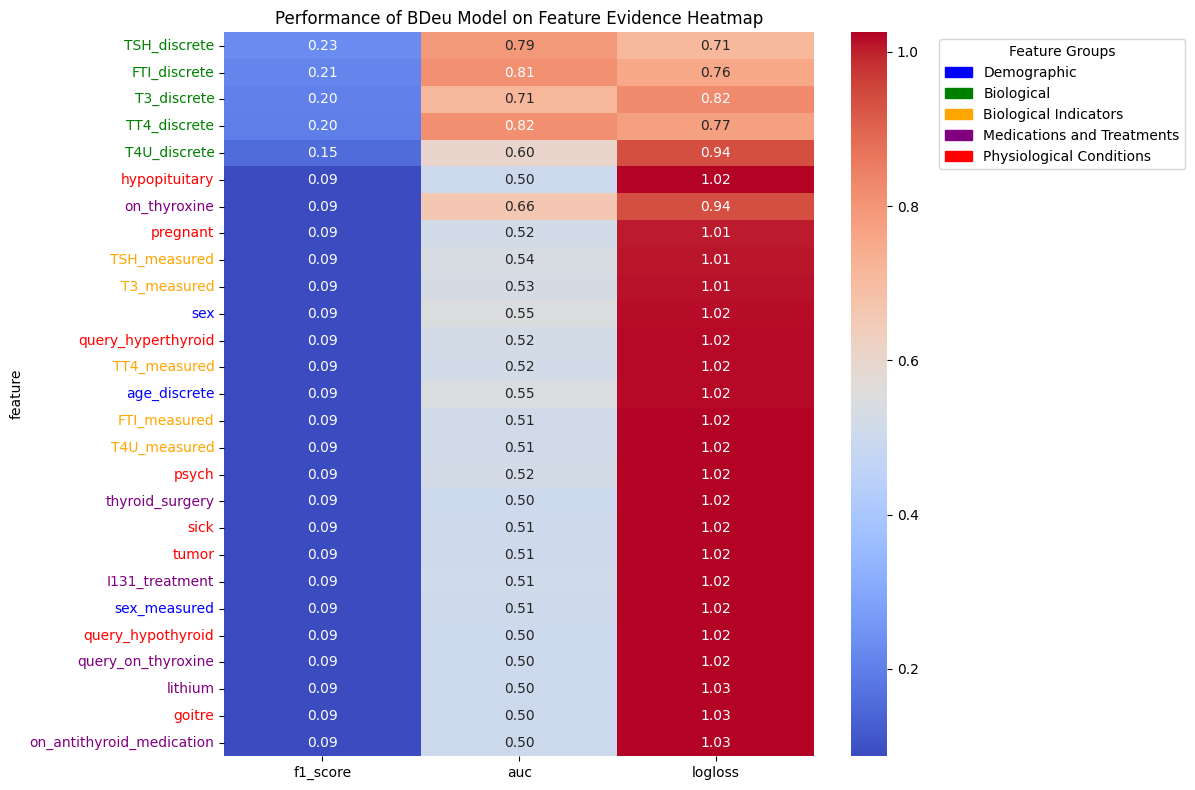

In [146]:
plot_feature_heatmap(
    BDeu_feature_results_df, 
    'Performance of BDeu Model on Feature Evidence Heatmap', 
    feature_group_mapping, 
    metrics,
    group_colors=group_colors)

In [115]:
random_feature_results_df = evaluate_model_by_feature(random_best_model, X_test, y_test.astype(int).values)
random_feature_results_df

feature  f1_score  accuracy  precision  recall  \
0                age_discrete  0.086826  0.767196    0.07672     0.1   
1          query_hyperthyroid  0.086826  0.767196    0.07672     0.1   
2                TT4_measured  0.086826  0.767196    0.07672     0.1   
3                TT4_discrete  0.086826  0.767196    0.07672     0.1   
4             thyroid_surgery  0.086826  0.767196    0.07672     0.1   
5           query_hypothyroid  0.086826  0.767196    0.07672     0.1   
6                       tumor  0.086826  0.767196    0.07672     0.1   
7                sex_measured  0.086826  0.767196    0.07672     0.1   
8                on_thyroxine  0.086826  0.767196    0.07672     0.1   
9          query_on_thyroxine  0.086826  0.767196    0.07672     0.1   
10                       sick  0.086826  0.767196    0.07672     0.1   
11                   pregnant  0.086826  0.767196    0.07672     0.1   
12                     goitre  0.086826  0.767196    0.07672     0.1   
13              hypopituitary  0.086826  0.767196    0.07672     0.1   
14                      psych  0.086826  0.767196    0.07672     0.1   
15               TSH_measured  0.086826  0.767196    0.07672     0.1   
16               T4U_measured  0.086826  0.767196    0.07672     0.1   
17               TSH_discrete  0.086826  0.767196    0.07672     0.1   
18               T4U_discrete  0.086826  0.767196    0.07672     0.1   
19                T3_discrete  0.086826  0.767196    0.07672     0.1   
20                T3_measured  0.086826  0.767196    0.07672     0.1   
21  on_antithyroid_medication  0.086826  0.767196    0.07672     0.1   
22               FTI_measured  0.086826  0.767196    0.07672     0.1   
23               FTI_discrete  0.086826  0.767196    0.07672     0.1   
24                    lithium  0.086826  0.767196    0.07672     0.1   
25             I131_treatment  0.086826  0.767196    0.07672     0.1   
26                        sex  0.086826  0.767196    0.07672     0.1   

     logloss       auc  
0   1.000828  0.569570  
1   1.016891  0.519459  
2   1.020301  0.516030  
3   1.024910  0.494192  
4   1.025045  0.500199  
5   1.025046  0.521672  
6   1.025046  0.505830  
7   1.025046  0.500000  
8   1.025046  0.500000  
9   1.025046  0.500000  
10  1.025046  0.500000  
11  1.025046  0.500000  
12  1.025046  0.500000  
13  1.025046  0.500000  
14  1.025046  0.500000  
15  1.025046  0.500000  
16  1.025046  0.500000  
17  1.025046  0.500000  
18  1.025046  0.500000  
19  1.025046  0.456434  
20  1.025046  0.466046  
21  1.025046  0.501878  
22  1.025089  0.495042  
23  1.025106  0.619702  
24  1.025141  0.498755  
25  1.025181  0.497892  
26  1.025352  0.443852

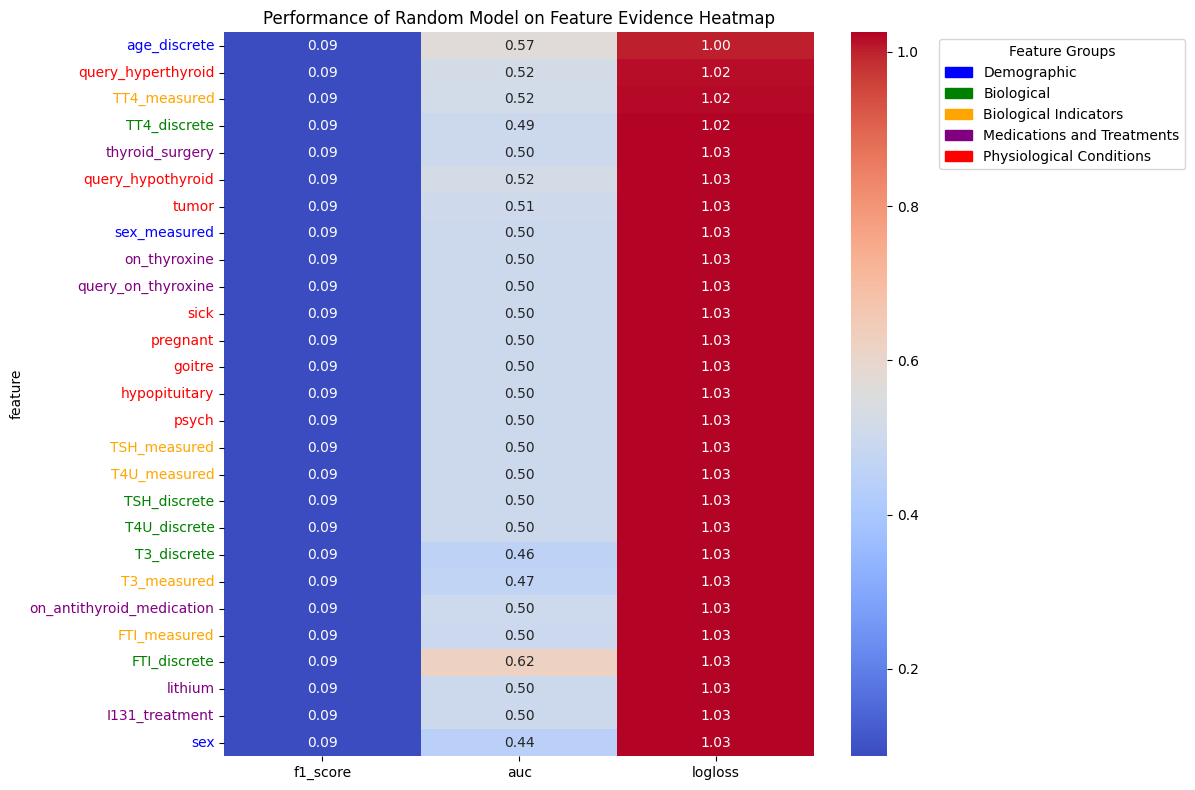

In [127]:
plot_feature_heatmap(
    random_feature_results_df, 
    'Performance of Random Model on Feature Evidence Heatmap', 
    feature_group_mapping, 
    metrics,
    group_colors=group_colors)

In [117]:
nn_feature_results_df = evaluate_model_by_feature(
    model=nn_best_model,        
    X_test=X_test,          
    true_labels=y_test_encoded,  
    nn=True,               
    input_dim=X_test.shape[1],  
    mask_value=-2,        
    num_classes=10         
)

nn_feature_results_df

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
42/42 ━━━━━━━━━━━━━━━━

feature  f1_score  accuracy  precision    recall  \
0                TSH_discrete  0.050126  0.057445   0.032091  0.200000   
1                T4U_discrete  0.011303  0.040816   0.006145  0.109091   
2                age_discrete  0.003271  0.016629   0.001663  0.100000   
3                FTI_discrete  0.003271  0.016629   0.001663  0.100000   
4                FTI_measured  0.003271  0.016629   0.001663  0.100000   
5                sex_measured  0.003271  0.016629   0.001663  0.100000   
6                       psych  0.003271  0.016629   0.001663  0.100000   
7                 T3_measured  0.003271  0.016629   0.001663  0.100000   
8                        sick  0.003271  0.016629   0.001663  0.100000   
9                T4U_measured  0.003271  0.016629   0.001663  0.100000   
10                     goitre  0.003271  0.016629   0.001663  0.100000   
11               TT4_measured  0.003271  0.016629   0.001663  0.100000   
12               TT4_discrete  0.003271  0.016629   0.001663  0.100000   
13         query_on_thyroxine  0.003271  0.016629   0.001663  0.100000   
14                    lithium  0.003271  0.016629   0.001663  0.100000   
15          query_hypothyroid  0.003271  0.016629   0.001663  0.100000   
16  on_antithyroid_medication  0.003271  0.016629   0.001663  0.100000   
17                T3_discrete  0.003271  0.016629   0.001663  0.100000   
18              hypopituitary  0.003271  0.016629   0.001663  0.100000   
19                   pregnant  0.003271  0.016629   0.001663  0.100000   
20               TSH_measured  0.003271  0.016629   0.001663  0.100000   
21            thyroid_surgery  0.003271  0.016629   0.001663  0.100000   
22                        sex  0.003271  0.016629   0.001663  0.100000   
23         query_hyperthyroid  0.003271  0.016629   0.001663  0.100000   
24                      tumor  0.003271  0.016629   0.001663  0.100000   
25             I131_treatment  0.003271  0.016629   0.001663  0.100000   
26               on_thyroxine  0.002537  0.012850   0.001285  0.100000   

     logloss       auc  
0   5.645308  0.696464  
1   7.088142  0.525764  
2   4.410145  0.491278  
3   4.887604  0.590736  
4   5.159036  0.504445  
5   5.340445  0.493932  
6   5.574424  0.512192  
7   5.609924  0.528378  
8   5.670727  0.506449  
9   5.744436  0.498068  
10  5.745849  0.499408  
11  5.840844  0.497923  
12  5.881480  0.652268  
13  5.890107  0.498444  
14  5.954519  0.500065  
15  5.978706  0.503201  
16  5.997689  0.498872  
17  6.073590  0.497639  
18  6.123437  0.499392  
19  6.189794  0.514091  
20  6.202607  0.481969  
21  6.243462  0.500356  
22  6.269192  0.474194  
23  6.273697  0.526012  
24  6.336468  0.505737  
25  6.366875  0.493655  
26  7.318229  0.577768

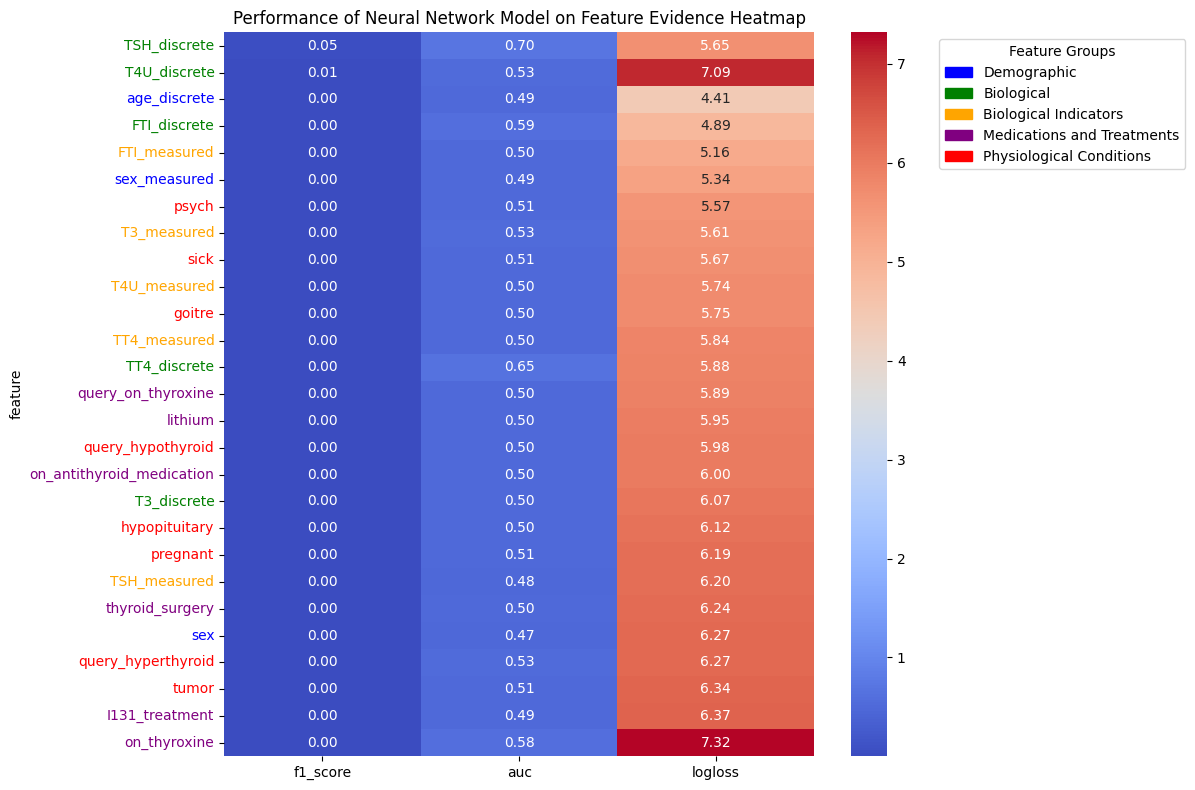

In [128]:
plot_feature_heatmap(
    nn_feature_results_df, 
    'Performance of Neural Network Model on Feature Evidence Heatmap', 
    feature_group_mapping, 
    metrics,
    group_colors=group_colors)

# Reverse Inference

In [75]:
def most_likely_symptom_profile(bn_model, diagnosis_value, symptom_variables):
    inference = VariableElimination(bn_model)
    evidence = {'diagnosis': diagnosis_value}
    map_estimates = {}
    
    # Perform MAP query for each symptom variable
    for symptom in symptom_variables:
        map_value = inference.map_query(variables=[symptom], evidence=evidence, show_progress=False)
        map_estimates[symptom] = map_value[symptom]  

    return map_estimates

In [76]:
def filter_most_likely_by_group(most_likely_df, grouping):
    filtered_columns =  ['diagnosis'] + ['diagnosis_name'] + list(grouping)
    filtered_df = most_likely_df[filtered_columns]
    
    return filtered_df

In [77]:
def decode_symptom_profile(encoded_df, sex_mapping, diagnosis_mapping, diagnosis_mapping_names, bins_dict, boolean_columns):
    """
    Decode the encoded symptom profile DataFrame to convert values back to their original representations.

    Parameters:
    - encoded_df (pd.DataFrame): The DataFrame containing encoded symptom profiles.
    - sex_mapping (dict): Mapping for sex encoding.
    - diagnosis_mapping (dict): Mapping for diagnosis encoding.
    - diagnosis_mapping_names (dict): Mapping for diagnosis names and categories.
    - bins_dict (dict): Dictionary where keys are column names and values are the bins/ranges for discretized columns.
    - boolean_columns (list): List of columns that should be interpreted as boolean values (0,1 -> False, True).

    Returns:
    - pd.DataFrame: A DataFrame with the decoded symptom profiles.
    """
    # Inverse mappings for categorical data
    inv_sex_mapping = {v: k for k, v in sex_mapping.items()}
    inv_diagnosis_mapping = {v: k for k, v in diagnosis_mapping.items()}
    
    decoded_df = encoded_df.copy()

    # Decode the categorical columns
    if 'sex' in decoded_df.columns:
        decoded_df['sex'] = decoded_df['sex'].astype(int, errors='ignore').map(inv_sex_mapping)
    if 'diagnosis' in decoded_df.columns:
        decoded_df['diagnosis'] = decoded_df['diagnosis'].astype(int, errors='ignore').map(inv_diagnosis_mapping)
        decoded_df['diagnosis_name'] = decoded_df['diagnosis'].map(lambda x: diagnosis_mapping_names.get(x, ('Unknown', 'Unknown'))[0])
        decoded_df['diagnosis_category'] = decoded_df['diagnosis'].map(lambda x: diagnosis_mapping_names.get(x, ('Unknown', 'Unknown'))[1])

    # Decode boolean columns (0 -> False, 1 -> True)
    for column in boolean_columns:
        if column in decoded_df.columns:
            decoded_df[column] = decoded_df[column].replace({'0': False, '1': True})

    # Decode discretized columns based on bins
    for column, bins in bins_dict.items():
        if column in decoded_df.columns:
            decoded_df[column] = pd.to_numeric(decoded_df[column], errors='coerce')
            decoded_df[column] = decoded_df[column].apply(
                lambda x: f"{bins[int(x)]:.2f} - {bins[int(x) + 1]:.2f}" if pd.notna(x) and x < len(bins) - 1 else 'Unknown'
            )
    return decoded_df

bins_dict = {
    'age_discrete': age_bins,
    'TSH_discrete': tsh_bins,
    'T3_discrete': t3_bins,
    'TT4_discrete': tt4_bins,
    'T4U_discrete': t4u_bins,
    'FTI_discrete': fti_bins
}

BDeu ##################

In [184]:
diagnosis_values = sorted(test_set['diagnosis'].unique())

symptom_variables = X_test.columns
results = []

# Loop over each diagnosis value and get the MAP estimates
for diagnosis_value in diagnosis_values:
    map_estimates = most_likely_symptom_profile(BDeu_best_model, diagnosis_value, symptom_variables)
    map_estimates['diagnosis'] = diagnosis_value
    results.append(map_estimates)

BDeu_symp_profile_df = pd.DataFrame(results)
BDeu_symp_profile_df

sex sex_measured on_thyroxine query_on_thyroxine on_antithyroid_medication  \
0   0            1            0                  0                         0   
1   0            1            0                  0                         0   
2   0            1            0                  0                         0   
3   0            1            0                  0                         0   
4   0            1            0                  0                         0   
5   0            1            0                  0                         0   
6   0            1            0                  0                         0   
7   0            1            1                  0                         0   
8   0            1            1                  0                         0   
9   0            1            1                  0                         0   

  sick pregnant thyroid_surgery I131_treatment query_hypothyroid  ...  \
0    0        0               0              0                 0  ...   
1    0        0               0              0                 0  ...   
2    0        0               0              0                 0  ...   
3    0        0               0              0                 0  ...   
4    0        0               0              0                 0  ...   
5    0        0               0              0                 0  ...   
6    0        0               0              0                 0  ...   
7    0        0               0              0                 0  ...   
8    0        0               0              0                 0  ...   
9    0        0               0              0                 0  ...   

  TT4_measured T4U_measured FTI_measured age_discrete TSH_discrete  \
0            1            1            1           12            2   
1            1            1            1           12            0   
2            1            1            1           12            6   
3            1            1            1           12            0   
4            1            1            1           12           12   
5            1            1            1           12            0   
6            1            1            1           12            0   
7            1            1            1           12            0   
8            1            1            1           12            6   
9            1            1            1           12            0   

  T3_discrete TT4_discrete T4U_discrete FTI_discrete diagnosis  
0           3            3            4           11         0  
1           1            2            4           11         1  
2           2            2            4           10         2  
3           4            5            5           10         3  
4          -1            0            5            9         4  
5           3            5            4           12         5  
6           4            5            4           12         6  
7          -1            5            4           12         7  
8          -1            3            4           10         8  
9          -1            5            4           12         9  

[10 rows x 28 columns]

In [196]:
boolean_columns.append('sex_measured')

decoded_BDeu_symp_profile_df = decode_symptom_profile(
    BDeu_symp_profile_df,
    sex_mapping=sex_mapping,
    diagnosis_mapping=diagnosis_mapping,
    diagnosis_mapping_names=diagnosis_mapping_names,
    bins_dict=bins_dict,
    boolean_columns=boolean_columns
)

decoded_BDeu_symp_profile_df

sex  sex_measured  on_thyroxine  query_on_thyroxine  \
0   F          True         False               False   
1   F          True         False               False   
2   F          True         False               False   
3   F          True         False               False   
4   F          True         False               False   
5   F          True         False               False   
6   F          True         False               False   
7   F          True          True               False   
8   F          True          True               False   
9   F          True          True               False   

   on_antithyroid_medication   sick  pregnant  thyroid_surgery  \
0                      False  False     False            False   
1                      False  False     False            False   
2                      False  False     False            False   
3                      False  False     False            False   
4                      False  False     False            False   
5                      False  False     False            False   
6                      False  False     False            False   
7                      False  False     False            False   
8                      False  False     False            False   
9                      False  False     False            False   

   I131_treatment  query_hypothyroid  ...  FTI_measured   age_discrete  \
0           False              False  ...          True  60.00 - 65.00   
1           False              False  ...          True  60.00 - 65.00   
2           False              False  ...          True  60.00 - 65.00   
3           False              False  ...          True  60.00 - 65.00   
4           False              False  ...          True  60.00 - 65.00   
5           False              False  ...          True  60.00 - 65.00   
6           False              False  ...          True  60.00 - 65.00   
7           False              False  ...          True  60.00 - 65.00   
8           False              False  ...          True  60.00 - 65.00   
9           False              False  ...          True  60.00 - 65.00   

    TSH_discrete   T3_discrete     TT4_discrete  T4U_discrete  \
0    0.88 - 1.57   1.76 - 2.80   90.00 - 120.00   0.80 - 1.00   
1    0.01 - 0.38   0.45 - 1.00    60.00 - 90.00   0.80 - 1.00   
2    5.59 - 8.02   1.00 - 1.76    60.00 - 90.00   0.80 - 1.00   
3    0.01 - 0.38   2.80 - 4.25  150.00 - 190.00   1.00 - 1.20   
4  42.24 - 58.17  18.00 - 0.05     0.00 - 30.00   1.00 - 1.20   
5    0.01 - 0.38   1.76 - 2.80  150.00 - 190.00   0.80 - 1.00   
6    0.01 - 0.38   2.80 - 4.25  150.00 - 190.00   0.80 - 1.00   
7    0.01 - 0.38  18.00 - 0.05  150.00 - 190.00   0.80 - 1.00   
8    5.59 - 8.02  18.00 - 0.05   90.00 - 120.00   0.80 - 1.00   
9    0.01 - 0.38  18.00 - 0.05  150.00 - 190.00   0.80 - 1.00   

      FTI_discrete  diagnosis                       diagnosis_name  \
0  108.67 - 154.23          -                         No condition   
1  108.67 - 154.23          K     concurrent non-thyroidal illness   
2   76.48 - 108.67          G              compensated hypothyroid   
3   76.48 - 108.67          I            increased binding protein   
4    53.74 - 76.48          F                  primary hypothyroid   
5  154.23 - 218.72          R             discordant assay results   
6  154.23 - 218.72          A                         hyperthyroid   
7  154.23 - 218.72          L  consistent with replacement therapy   
8   76.48 - 108.67          M                        underreplaced   
9  154.23 - 218.72          N                         overreplaced   

        diagnosis_category  
0             No condition  
1           general health  
2   hypothyroid conditions  
3          binding protein  
4   hypothyroid conditions  
5            miscellaneous  
6  hyperthyroid conditions  
7      replacement therapy  
8      replacement therapy  
9      replacement therapy  

[10 rows x 30 columns]

In [199]:
print(f"Most likely symptom profile for Demographic grouping")
demographic_df = filter_most_likely_by_group(decoded_BDeu_symp_profile_df, demographic.columns)
demographic_df

Most likely symptom profile for Demographic grouping


diagnosis                       diagnosis_name   age_discrete sex  \
0         -                         No condition  60.00 - 65.00   F   
1         K     concurrent non-thyroidal illness  60.00 - 65.00   F   
2         G              compensated hypothyroid  60.00 - 65.00   F   
3         I            increased binding protein  60.00 - 65.00   F   
4         F                  primary hypothyroid  60.00 - 65.00   F   
5         R             discordant assay results  60.00 - 65.00   F   
6         A                         hyperthyroid  60.00 - 65.00   F   
7         L  consistent with replacement therapy  60.00 - 65.00   F   
8         M                        underreplaced  60.00 - 65.00   F   
9         N                         overreplaced  60.00 - 65.00   F   

   sex_measured  
0          True  
1          True  
2          True  
3          True  
4          True  
5          True  
6          True  
7          True  
8          True  
9          True

In [200]:
print(f"Most likely symptom profile for Biological grouping")
biological_df = filter_most_likely_by_group(decoded_BDeu_symp_profile_df, biological.columns)
biological_df

Most likely symptom profile for Biological grouping


diagnosis                       diagnosis_name   TSH_discrete   T3_discrete  \
0         -                         No condition    0.88 - 1.57   1.76 - 2.80   
1         K     concurrent non-thyroidal illness    0.01 - 0.38   0.45 - 1.00   
2         G              compensated hypothyroid    5.59 - 8.02   1.00 - 1.76   
3         I            increased binding protein    0.01 - 0.38   2.80 - 4.25   
4         F                  primary hypothyroid  42.24 - 58.17  18.00 - 0.05   
5         R             discordant assay results    0.01 - 0.38   1.76 - 2.80   
6         A                         hyperthyroid    0.01 - 0.38   2.80 - 4.25   
7         L  consistent with replacement therapy    0.01 - 0.38  18.00 - 0.05   
8         M                        underreplaced    5.59 - 8.02  18.00 - 0.05   
9         N                         overreplaced    0.01 - 0.38  18.00 - 0.05   

      TT4_discrete T4U_discrete     FTI_discrete  
0   90.00 - 120.00  0.80 - 1.00  108.67 - 154.23  
1    60.00 - 90.00  0.80 - 1.00  108.67 - 154.23  
2    60.00 - 90.00  0.80 - 1.00   76.48 - 108.67  
3  150.00 - 190.00  1.00 - 1.20   76.48 - 108.67  
4     0.00 - 30.00  1.00 - 1.20    53.74 - 76.48  
5  150.00 - 190.00  0.80 - 1.00  154.23 - 218.72  
6  150.00 - 190.00  0.80 - 1.00  154.23 - 218.72  
7  150.00 - 190.00  0.80 - 1.00  154.23 - 218.72  
8   90.00 - 120.00  0.80 - 1.00   76.48 - 108.67  
9  150.00 - 190.00  0.80 - 1.00  154.23 - 218.72

In [201]:
print(f"Most likely symptom profile for Physiological Conditions grouping")
physio_df = filter_most_likely_by_group(decoded_BDeu_symp_profile_df, physiological_conditions.columns)
physio_df

Most likely symptom profile for Physiological Conditions grouping


diagnosis                       diagnosis_name   sick  pregnant  \
0         -                         No condition  False     False   
1         K     concurrent non-thyroidal illness  False     False   
2         G              compensated hypothyroid  False     False   
3         I            increased binding protein  False     False   
4         F                  primary hypothyroid  False     False   
5         R             discordant assay results  False     False   
6         A                         hyperthyroid  False     False   
7         L  consistent with replacement therapy  False     False   
8         M                        underreplaced  False     False   
9         N                         overreplaced  False     False   

   query_hypothyroid  query_hyperthyroid  psych  goitre  tumor  hypopituitary  
0              False               False  False   False  False          False  
1              False               False  False   False  False          False  
2              False               False  False   False  False          False  
3              False               False  False   False  False          False  
4              False               False  False   False  False          False  
5              False               False  False   False  False          False  
6              False               False  False   False  False          False  
7              False               False  False   False  False          False  
8              False               False  False   False  False          False  
9              False               False  False   False  False          False

In [202]:
print(f"Most likely symptom profile for Medications and Treatments grouping")
medications_and_treatments_df = filter_most_likely_by_group(decoded_BDeu_symp_profile_df, medications_and_treatments.columns)
medications_and_treatments_df

Most likely symptom profile for Medications and Treatments grouping


diagnosis                       diagnosis_name  on_thyroxine  \
0         -                         No condition         False   
1         K     concurrent non-thyroidal illness         False   
2         G              compensated hypothyroid         False   
3         I            increased binding protein         False   
4         F                  primary hypothyroid         False   
5         R             discordant assay results         False   
6         A                         hyperthyroid         False   
7         L  consistent with replacement therapy          True   
8         M                        underreplaced          True   
9         N                         overreplaced          True   

   query_on_thyroxine  on_antithyroid_medication  lithium  thyroid_surgery  \
0               False                      False    False            False   
1               False                      False    False            False   
2               False                      False    False            False   
3               False                      False    False            False   
4               False                      False    False            False   
5               False                      False    False            False   
6               False                      False    False            False   
7               False                      False    False            False   
8               False                      False    False            False   
9               False                      False    False            False   

   I131_treatment  
0           False  
1           False  
2           False  
3           False  
4           False  
5           False  
6           False  
7           False  
8           False  
9           False

Random ##################

In [203]:
results = []

# Loop over each diagnosis value and get the MAP estimates
for diagnosis_value in diagnosis_values:
    map_estimates = most_likely_symptom_profile(random_best_model, diagnosis_value, symptom_variables)
    map_estimates['diagnosis'] = diagnosis_value
    results.append(map_estimates)

random_symp_profile_df = pd.DataFrame(results)
random_symp_profile_df

sex sex_measured on_thyroxine query_on_thyroxine on_antithyroid_medication  \
0   0            1            0                  0                         0   
1   0            1            0                  0                         0   
2   0            1            0                  0                         0   
3   0            1            0                  0                         0   
4   0            1            0                  0                         0   
5   0            1            0                  0                         0   
6   0            1            0                  0                         0   
7   0            1            0                  0                         0   
8   0            1            0                  0                         0   
9   0            1            0                  0                         0   

  sick pregnant thyroid_surgery I131_treatment query_hypothyroid  ...  \
0    0        0               0              0                 0  ...   
1    0        0               0              0                 0  ...   
2    0        0               0              0                 0  ...   
3    0        0               0              0                 0  ...   
4    0        0               0              0                 0  ...   
5    0        0               0              0                 0  ...   
6    0        0               0              0                 0  ...   
7    0        0               0              0                 0  ...   
8    0        0               0              0                 0  ...   
9    0        0               0              0                 0  ...   

  TT4_measured T4U_measured FTI_measured age_discrete TSH_discrete  \
0            1            1            1           12            0   
1            1            1            1           14            0   
2            1            1            1           11            0   
3            1            1            1            5            0   
4            1            1            1           12            0   
5            1            1            1           12            0   
6            1            1            1           11            0   
7            1            1            1           11            0   
8            1            1            1           12            0   
9            1            1            1           11            0   

  T3_discrete TT4_discrete T4U_discrete FTI_discrete diagnosis  
0           3            3            4           11         0  
1           3            3            4           11         1  
2           3            3            4           11         2  
3           3            3            4           11         3  
4           3            3            4           11         4  
5           3            3            4           11         5  
6           3            3            4           11         6  
7           3            3            4           11         7  
8           3            3            4           11         8  
9           3            3            4           11         9  

[10 rows x 28 columns]

In [204]:
decoded_random_symp_profile_df = decode_symptom_profile(
    random_symp_profile_df,
    sex_mapping=sex_mapping,
    diagnosis_mapping=diagnosis_mapping,
    diagnosis_mapping_names=diagnosis_mapping_names,
    bins_dict=bins_dict,
    boolean_columns=boolean_columns
)

decoded_random_symp_profile_df

sex  sex_measured  on_thyroxine  query_on_thyroxine  \
0   F          True         False               False   
1   F          True         False               False   
2   F          True         False               False   
3   F          True         False               False   
4   F          True         False               False   
5   F          True         False               False   
6   F          True         False               False   
7   F          True         False               False   
8   F          True         False               False   
9   F          True         False               False   

   on_antithyroid_medication   sick  pregnant  thyroid_surgery  \
0                      False  False     False            False   
1                      False  False     False            False   
2                      False  False     False            False   
3                      False  False     False            False   
4                      False  False     False            False   
5                      False  False     False            False   
6                      False  False     False            False   
7                      False  False     False            False   
8                      False  False     False            False   
9                      False  False     False            False   

   I131_treatment  query_hypothyroid  ...  FTI_measured   age_discrete  \
0           False              False  ...          True  60.00 - 65.00   
1           False              False  ...          True  70.00 - 75.00   
2           False              False  ...          True  55.00 - 60.00   
3           False              False  ...          True  25.00 - 30.00   
4           False              False  ...          True  60.00 - 65.00   
5           False              False  ...          True  60.00 - 65.00   
6           False              False  ...          True  55.00 - 60.00   
7           False              False  ...          True  55.00 - 60.00   
8           False              False  ...          True  60.00 - 65.00   
9           False              False  ...          True  55.00 - 60.00   

   TSH_discrete  T3_discrete    TT4_discrete  T4U_discrete     FTI_discrete  \
0   0.01 - 0.38  1.76 - 2.80  90.00 - 120.00   0.80 - 1.00  108.67 - 154.23   
1   0.01 - 0.38  1.76 - 2.80  90.00 - 120.00   0.80 - 1.00  108.67 - 154.23   
2   0.01 - 0.38  1.76 - 2.80  90.00 - 120.00   0.80 - 1.00  108.67 - 154.23   
3   0.01 - 0.38  1.76 - 2.80  90.00 - 120.00   0.80 - 1.00  108.67 - 154.23   
4   0.01 - 0.38  1.76 - 2.80  90.00 - 120.00   0.80 - 1.00  108.67 - 154.23   
5   0.01 - 0.38  1.76 - 2.80  90.00 - 120.00   0.80 - 1.00  108.67 - 154.23   
6   0.01 - 0.38  1.76 - 2.80  90.00 - 120.00   0.80 - 1.00  108.67 - 154.23   
7   0.01 - 0.38  1.76 - 2.80  90.00 - 120.00   0.80 - 1.00  108.67 - 154.23   
8   0.01 - 0.38  1.76 - 2.80  90.00 - 120.00   0.80 - 1.00  108.67 - 154.23   
9   0.01 - 0.38  1.76 - 2.80  90.00 - 120.00   0.80 - 1.00  108.67 - 154.23   

   diagnosis                       diagnosis_name       diagnosis_category  
0          -                         No condition             No condition  
1          K     concurrent non-thyroidal illness           general health  
2          G              compensated hypothyroid   hypothyroid conditions  
3          I            increased binding protein          binding protein  
4          F                  primary hypothyroid   hypothyroid conditions  
5          R             discordant assay results            miscellaneous  
6          A                         hyperthyroid  hyperthyroid conditions  
7          L  consistent with replacement therapy      replacement therapy  
8          M                        underreplaced      replacement therapy  
9          N                         overreplaced      replacement therapy  

[10 rows x 30 columns]

In [205]:
print(f"Most likely symptom profile for Biological grouping")
biological_df = filter_most_likely_by_group(decoded_random_symp_profile_df, biological.columns)
biological_df

Most likely symptom profile for Biological grouping


diagnosis                       diagnosis_name TSH_discrete  T3_discrete  \
0         -                         No condition  0.01 - 0.38  1.76 - 2.80   
1         K     concurrent non-thyroidal illness  0.01 - 0.38  1.76 - 2.80   
2         G              compensated hypothyroid  0.01 - 0.38  1.76 - 2.80   
3         I            increased binding protein  0.01 - 0.38  1.76 - 2.80   
4         F                  primary hypothyroid  0.01 - 0.38  1.76 - 2.80   
5         R             discordant assay results  0.01 - 0.38  1.76 - 2.80   
6         A                         hyperthyroid  0.01 - 0.38  1.76 - 2.80   
7         L  consistent with replacement therapy  0.01 - 0.38  1.76 - 2.80   
8         M                        underreplaced  0.01 - 0.38  1.76 - 2.80   
9         N                         overreplaced  0.01 - 0.38  1.76 - 2.80   

     TT4_discrete T4U_discrete     FTI_discrete  
0  90.00 - 120.00  0.80 - 1.00  108.67 - 154.23  
1  90.00 - 120.00  0.80 - 1.00  108.67 - 154.23  
2  90.00 - 120.00  0.80 - 1.00  108.67 - 154.23  
3  90.00 - 120.00  0.80 - 1.00  108.67 - 154.23  
4  90.00 - 120.00  0.80 - 1.00  108.67 - 154.23  
5  90.00 - 120.00  0.80 - 1.00  108.67 - 154.23  
6  90.00 - 120.00  0.80 - 1.00  108.67 - 154.23  
7  90.00 - 120.00  0.80 - 1.00  108.67 - 154.23  
8  90.00 - 120.00  0.80 - 1.00  108.67 - 154.23  
9  90.00 - 120.00  0.80 - 1.00  108.67 - 154.23

#### Distribution comparison

In [78]:
def symptom_probability_distribution(bn_model, diagnosis_value, symptom_variables):
    inference = VariableElimination(bn_model)
    
    evidence = {'diagnosis': diagnosis_value}
    
    # Query the full probability distribution for each symptom variable
    probability_distributions = {}
    
    for symptom in symptom_variables:
        # Get the probability distribution for the symptom given the diagnosis
        query_result = inference.query(variables=[symptom], evidence=evidence)
        probability_distributions[symptom] = query_result

    return probability_distributions

In [79]:
def plot_double_bar_distribution(variable, predicted_distribution, true_data, target_variable_value, variables_to_plot, diagnosis_mapping, diagnosis_mapping_names):
    """
    Plots the predicted and true probability distributions for a given variable, filtered by a target variable value.

    Parameters:
    - variable (str): The name of the variable to plot.
    - predicted_distribution: The predicted distribution (DiscreteFactor) with state names and values.
    - true_data (DataFrame): The DataFrame containing true data.
    - target_variable_value: The specific value of the target variable to filter true data.
    - variables_to_plot (list): List of variable names (columns) to include in the plot.
    """
    if variable not in variables_to_plot:
        return

    # Extract the predicted values and probabilities from the DiscreteFactor
    predicted_values = predicted_distribution.state_names[variable]
    predicted_probabilities = predicted_distribution.values

    predicted_values = [float(val) for val in predicted_values]
    filtered_true_data = true_data[true_data['diagnosis'] == target_variable_value]

    # Calculate the true distribution of the variable
    true_value_counts = filtered_true_data[variable].value_counts(normalize=True).sort_index()
    true_values = true_value_counts.index.astype(int).to_list()
    true_probabilities = true_value_counts.values

    # Ensure both predicted and true values cover the same range
    all_values = sorted(set(predicted_values).union(set(true_values)))

    # Align predicted probabilities with the full range of values
    predicted_probabilities_aligned = [
        predicted_probabilities[predicted_values.index(val)] if val in predicted_values else 0
        for val in all_values
    ]

    # Align true probabilities with the full range of values
    true_probabilities_aligned = [
        true_probabilities[true_values.index(val)] if val in true_values else 0
        for val in all_values
    ]

    # Get decoded diagnosis name
    inv_diagnosis_mapping = {v: k for k, v in diagnosis_mapping.items()}
    diagnosis_int = inv_diagnosis_mapping.get(int(target_variable_value), 'Unknown')
    diagnosis_name = diagnosis_mapping_names.get(diagnosis_int, ('Unknown', 'Unknown'))[0]
    diagnosis_category = diagnosis_mapping_names.get(diagnosis_int, ('Unknown', 'Unknown'))[1]

    # Plot the distributions
    plt.figure(figsize=(10, 6))

    bar_width = 0.35
    index = np.arange(len(all_values))

    # Plot the predicted probabilities
    plt.bar(index, predicted_probabilities_aligned, bar_width, label='Predicted', alpha=0.6, color='blue')

    # Plot the true probabilities
    plt.bar(index + bar_width, true_probabilities_aligned, bar_width, label='True', alpha=0.6, color='green')

    plt.xlabel(f'{variable}')
    plt.ylabel('Probability')
    plt.title(f'Predicted vs True Probability Distribution of {variable} (Diagnosis = {diagnosis_name})')
    plt.xticks(index + bar_width / 2, all_values, rotation=45)
    plt.legend()
    plt.show()

BDeu Model

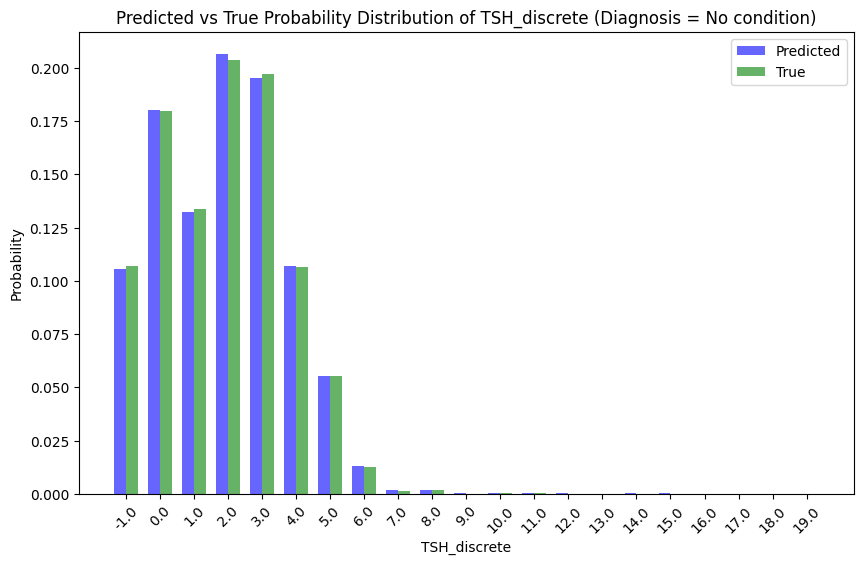

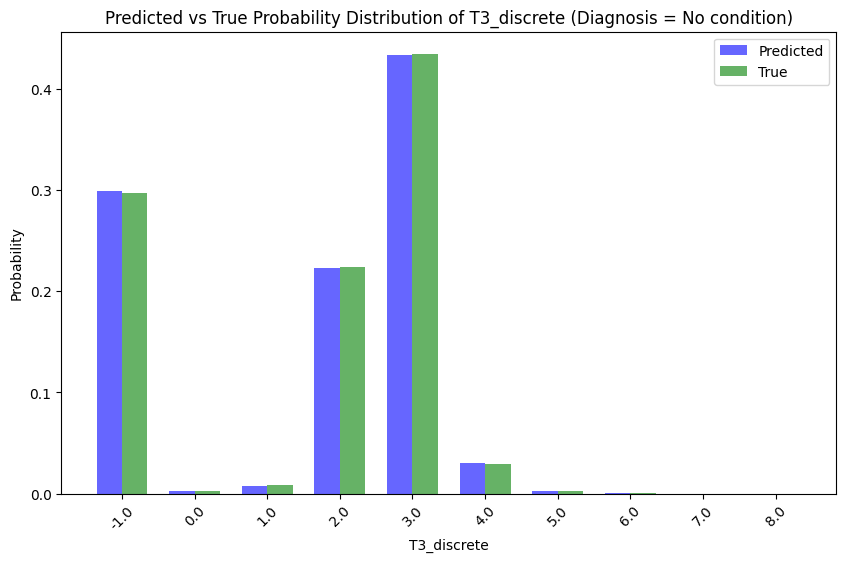

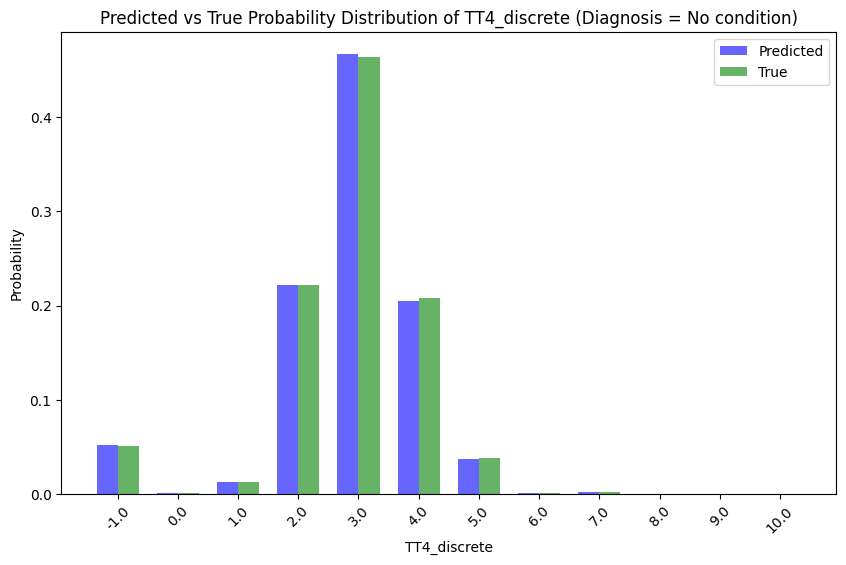

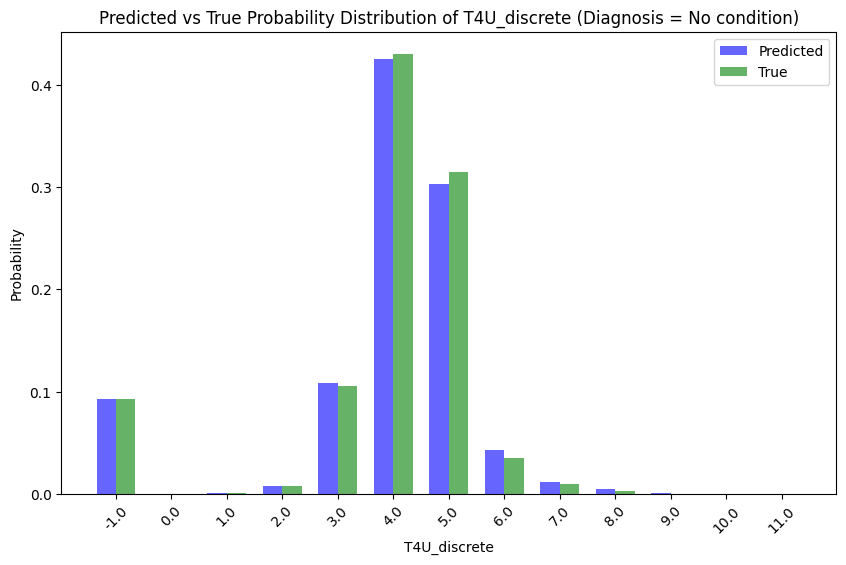

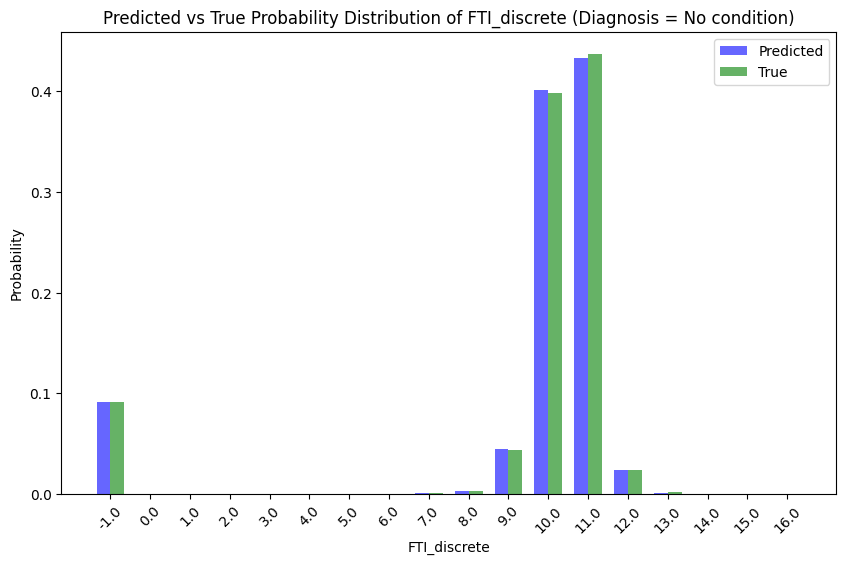

In [80]:
diagnosis_value = '0'  

# Get probability distributions for each symptom given the diagnosis
prob_distributions = symptom_probability_distribution(BDeu_best_model, diagnosis_value, X_test.columns)

variables_to_plot = biological.columns

# Loop through the symptom variables and plot their predicted vs true distributions
for symptom, distribution in prob_distributions.items():
    if symptom in variables_to_plot: 
        plot_double_bar_distribution(symptom, distribution, exp_df, diagnosis_value, variables_to_plot, diagnosis_mapping, diagnosis_mapping_names)

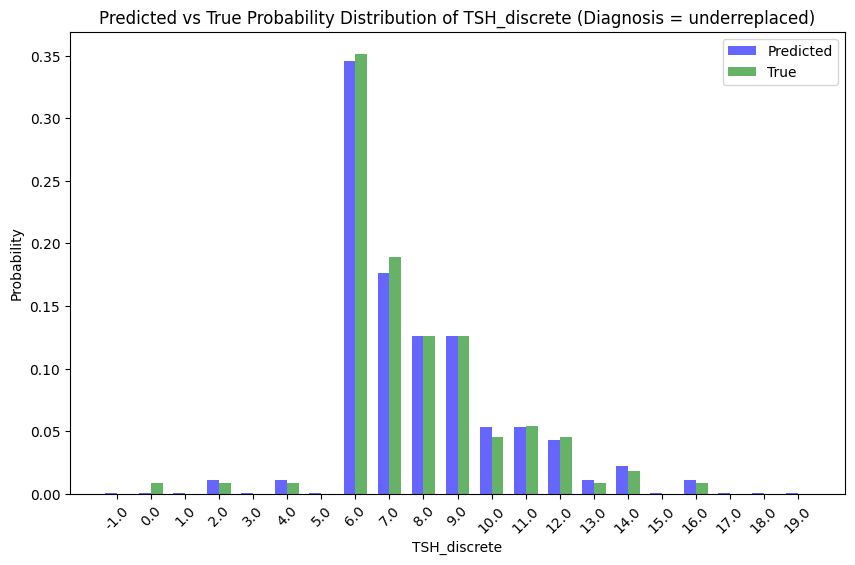

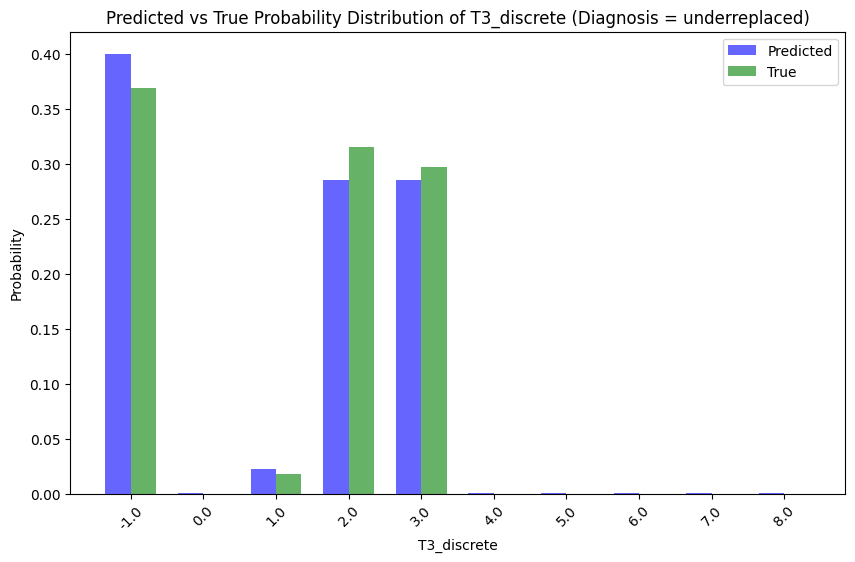

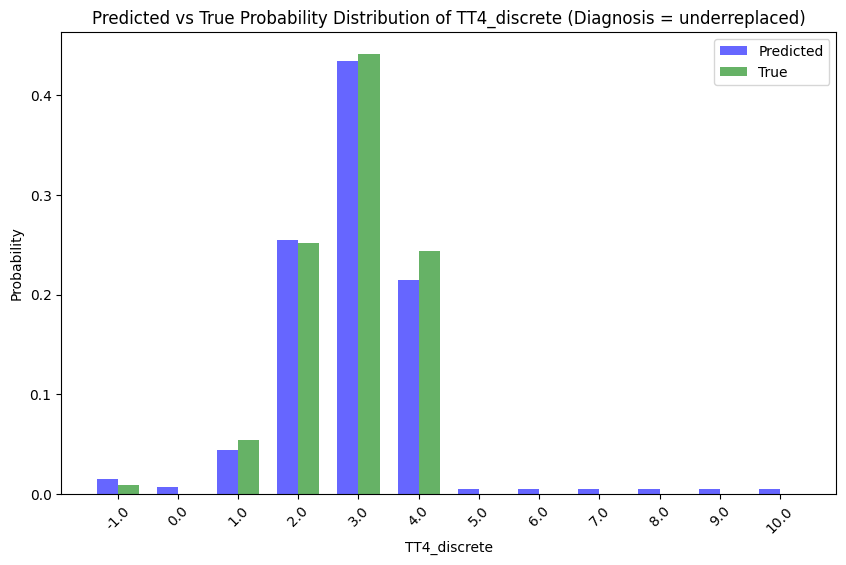

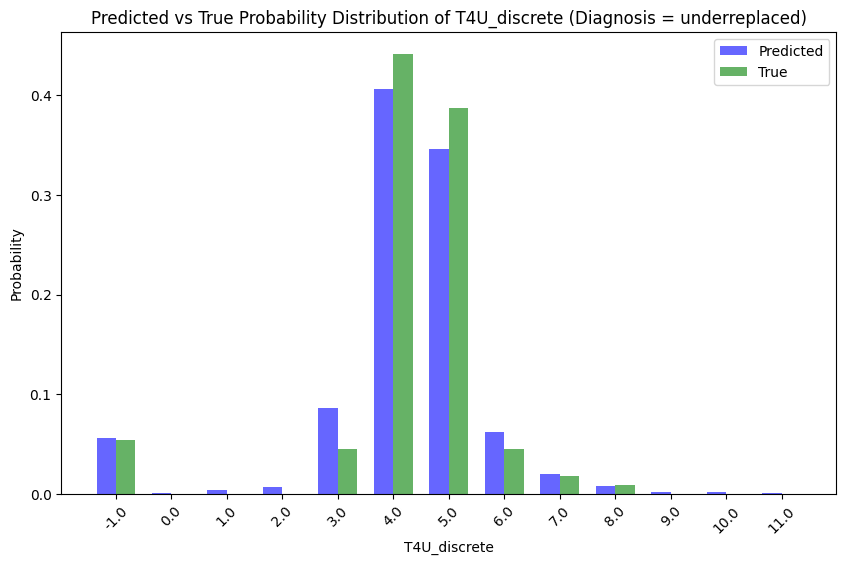

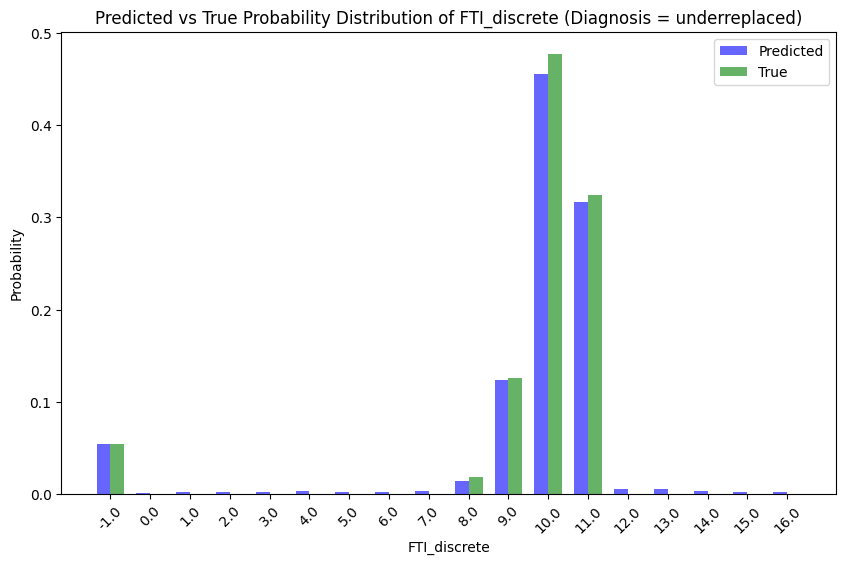

In [81]:
diagnosis_value = '8'  

# Get probability distributions for each symptom given the diagnosis
prob_distributions = symptom_probability_distribution(BDeu_best_model, diagnosis_value, X_test.columns)

variables_to_plot = biological.columns

# Loop through the symptom variables and plot their predicted vs true distributions
for symptom, distribution in prob_distributions.items():
    if symptom in variables_to_plot: 
        plot_double_bar_distribution(symptom, distribution, exp_df, diagnosis_value, variables_to_plot, diagnosis_mapping, diagnosis_mapping_names)

Random Model

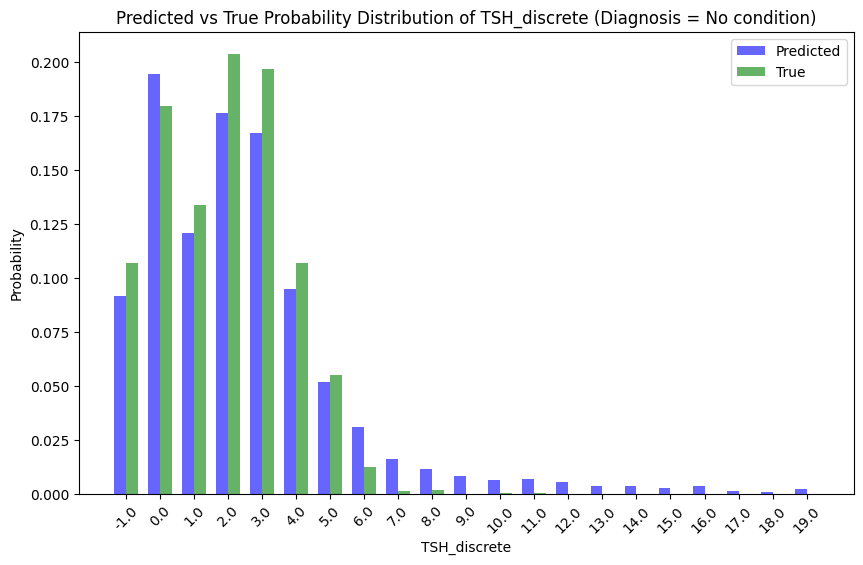

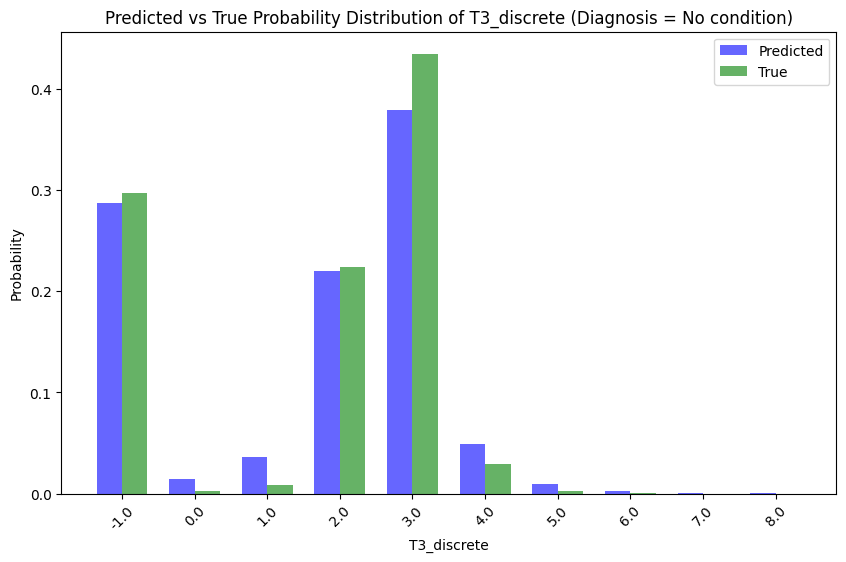

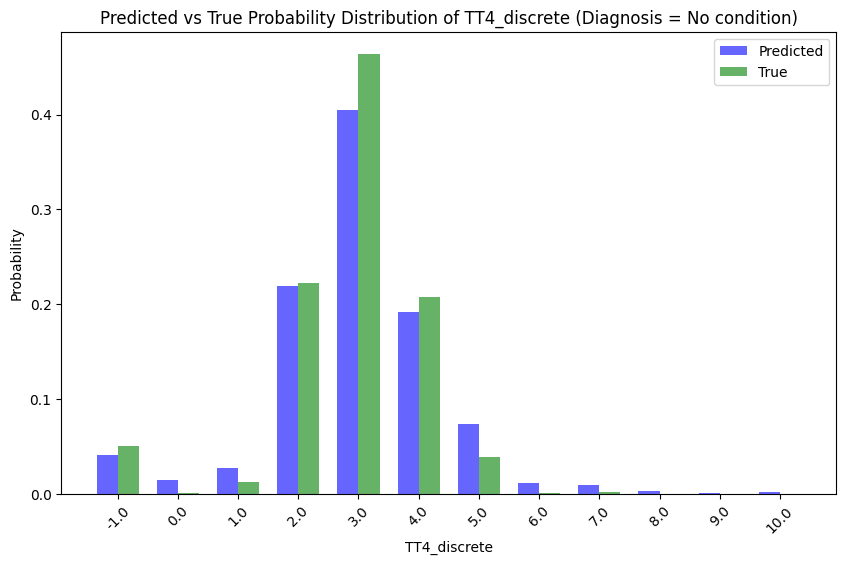

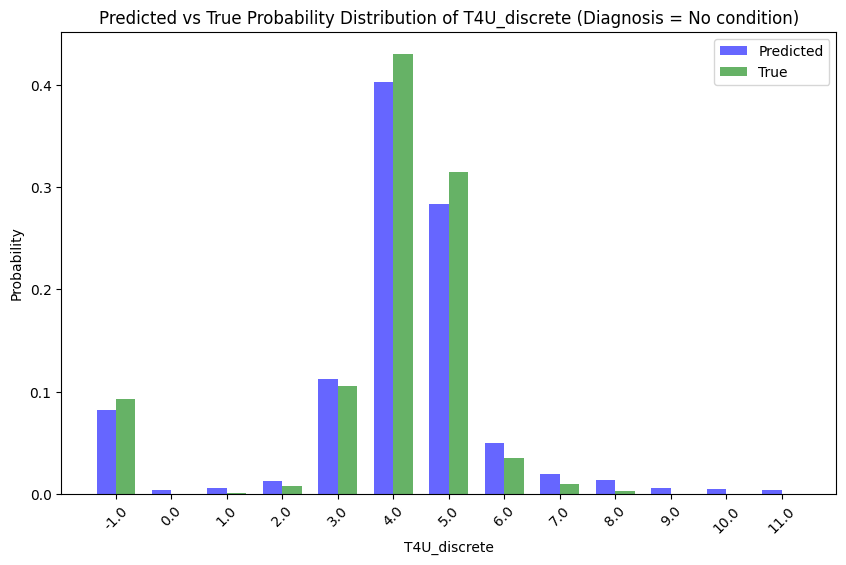

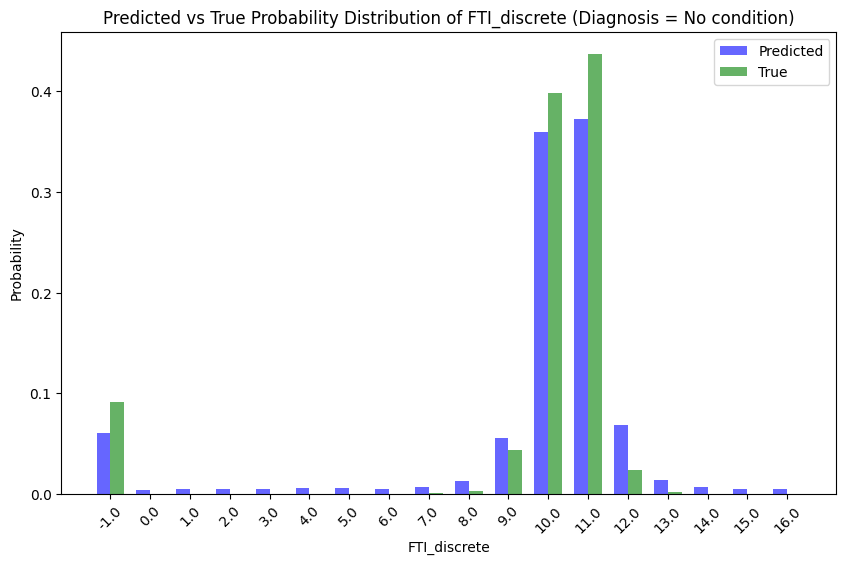

In [82]:
diagnosis_value = '0'  

# Get probability distributions for each symptom given the diagnosis
prob_distributions = symptom_probability_distribution(random_best_model, diagnosis_value, X_test.columns)

variables_to_plot = biological.columns

# Loop through the symptom variables and plot their predicted vs true distributions
for symptom, distribution in prob_distributions.items():
    if symptom in variables_to_plot: 
        plot_double_bar_distribution(symptom, distribution, exp_df, diagnosis_value, variables_to_plot, diagnosis_mapping, diagnosis_mapping_names)

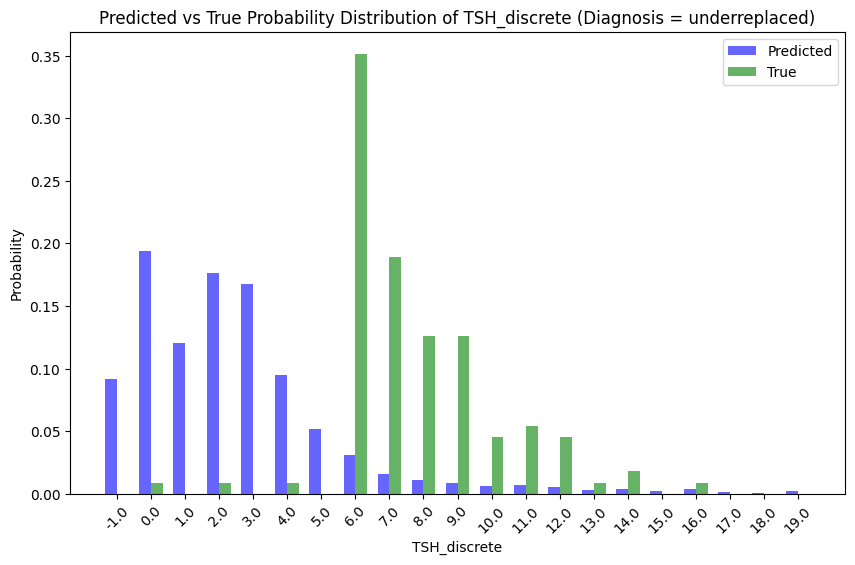

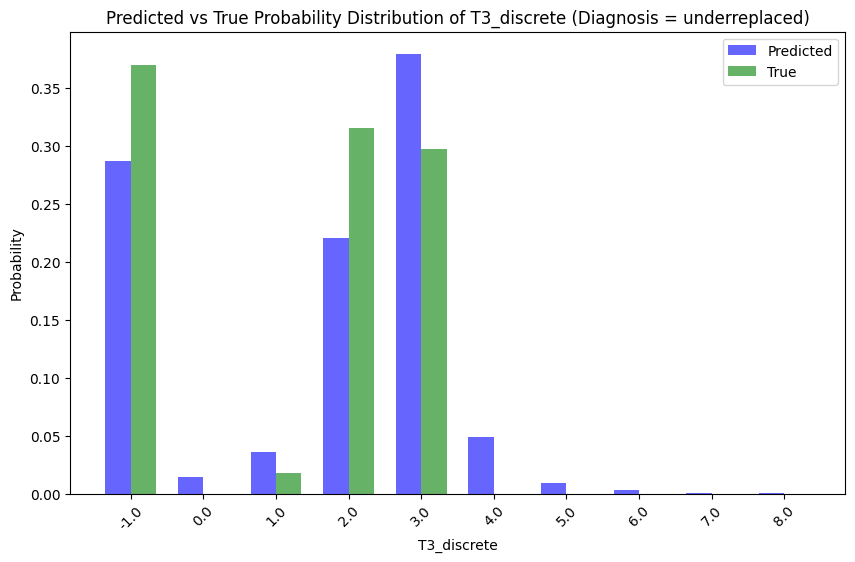

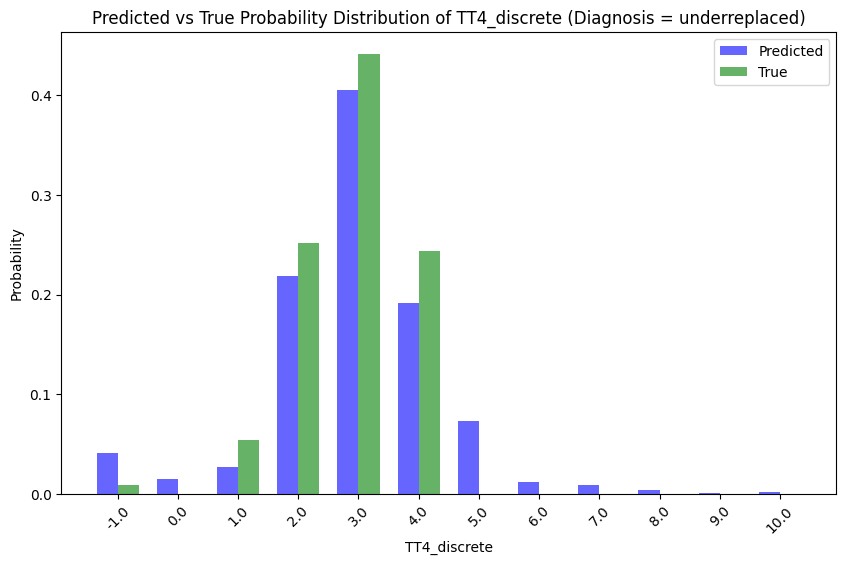

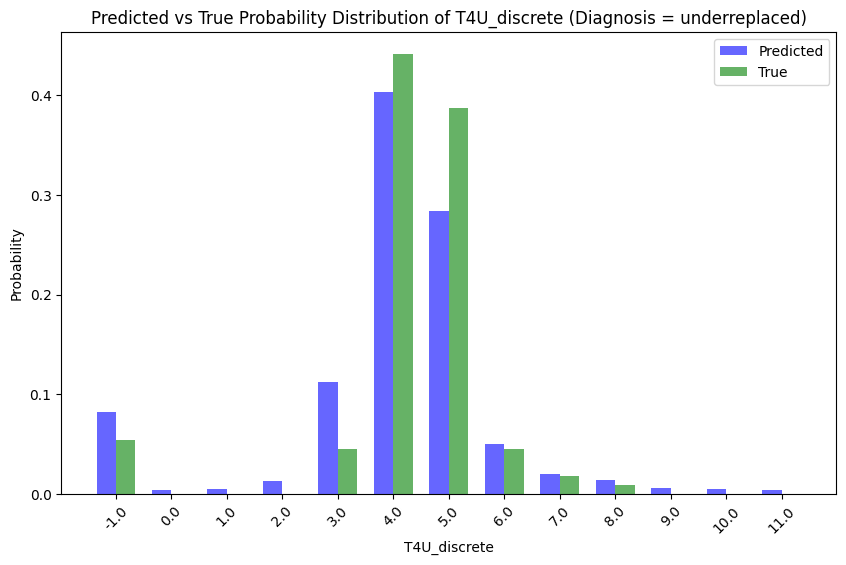

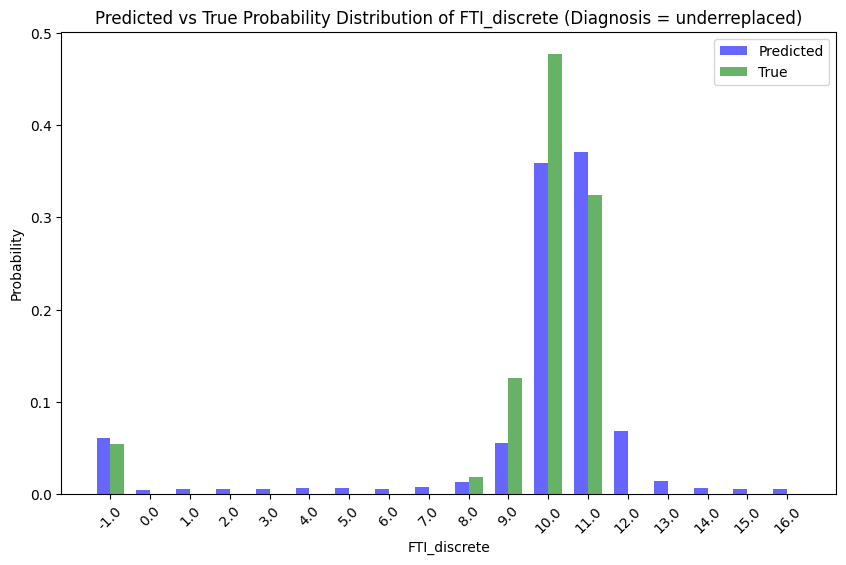

In [83]:
diagnosis_value = '8'  

# Get probability distributions for each symptom given the diagnosis
prob_distributions = symptom_probability_distribution(random_best_model, diagnosis_value, X_test.columns)

variables_to_plot = biological.columns

# Loop through the symptom variables and plot their predicted vs true distributions
for symptom, distribution in prob_distributions.items():
    if symptom in variables_to_plot: 
        plot_double_bar_distribution(symptom, distribution, exp_df, diagnosis_value, variables_to_plot, diagnosis_mapping, diagnosis_mapping_names)

In [ ]:
# Print the probability distribution tables for each symptom
'''
print(f"Probability distributions for symptoms given diagnosis {diagnosis_value}:")
for symptom, distribution in prob_distributions.items():
    print(f"\n{symptom}:")
    print(distribution)
'''